<img src='data/project_main_image.jpg'>

# 1. Анализ и обработка данных

## 1. Базовый анализ и очистка данных

Перед началом исследования импортируем все необходимые нам библиотеки:

In [ ]:
# Чтение и работа с данными
import pandas as pd
import numpy as np

# Визуализация данных и распределений
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Статистические тесты
from scipy import stats

# Кодировка и масштабирование столбцов
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# Разбиение данных на выборки
from sklearn.model_selection import train_test_split

# ML-модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Оптимизация гиперпараметров модели
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# Метрики оценки качества моделей
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

# Визуальная настройка графиков
sns.set_theme("notebook") 
sns.set_palette("dark")
plt.rcParams["patch.force_edgecolor"] = True

# Игнорирование возможных предупреждений
import warnings 
warnings.filterwarnings("ignore")

Теперь нам необходимо понять, с какими данными нам предстоит работать, произвести их базовую очистку, и изучить статистическую характеристику признаков.

Познакомимся с нашими данными:

In [660]:
# Читаем наш датасет 
data = pd.read_csv('data/International_Education_Costs.csv', sep=',')

print(f'Размер исходных данных: {data.shape}')
data.head(5)

Размер исходных данных: (907, 12)


,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.00
1,UK,London,Imperial College London,Data Science,Master,1.0,41200,75.8,1800,485,800,0.79
2,Canada,Toronto,University of Toronto,Business Analytics,Master,2.0,38500,72.5,1600,235,900,1.35
3,Australia,Melbourne,University of Melbourne,Engineering,Master,2.0,42000,71.2,1400,450,650,1.52
4,Germany,Munich,Technical University of Munich,Mechanical Engineering,Master,2.0,500,70.5,1100,75,550,0.92


Нам предстоит работать с более чем 900 записями о стоимости международного образования, включающими в себя подробную финансовую информацию о студентах, получающих или получивших высшее образование за рубежом.

Помимо финансовой информации датасет также содержит информацию о том, в какой стране, городе и университете студент получает или получил образование, включая наименование программы уровень образования и длительность программы.

Проведём анализ структуры данных.

Выведем основную информацию о типах данных в столбцах:

In [661]:
# Выводим основную информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            907 non-null    object 
 1   City               907 non-null    object 
 2   University         907 non-null    object 
 3   Program            907 non-null    object 
 4   Level              907 non-null    object 
 5   Duration_Years     907 non-null    float64
 6   Tuition_USD        907 non-null    int64  
 7   Living_Cost_Index  907 non-null    float64
 8   Rent_USD           907 non-null    int64  
 9   Visa_Fee_USD       907 non-null    int64  
 10  Insurance_USD      907 non-null    int64  
 11  Exchange_Rate      907 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 85.2+ KB


Проверим датасет на наличие в нём пропусков:

In [662]:
# Выводим информацию о пропусках в данных
print(f'Всего пропусков в данных: {data.isnull().sum().sum()}')
data.isnull().sum()

Всего пропусков в данных: 0


Country              0
City                 0
University           0
Program              0
Level                0
Duration_Years       0
Tuition_USD          0
Living_Cost_Index    0
Rent_USD             0
Visa_Fee_USD         0
Insurance_USD        0
Exchange_Rate        0
dtype: int64

Судя по полученным результатам данные не имеют пропусков. Проверим, не указаны ли они в неявном виде? 

In [663]:
# Проверяем данные на наличие записей хотя бы с одним значением равным 0
rows_with_zero = data[data.eq(0).any(axis=1)]

if not rows_with_zero.empty:
    print('Некоторые записи содержат ноль в признаках')
else:
    print('Нет записей с нулевыми значениями признаков.')

Некоторые записи содержат ноль в признаках


Как и ожидалось, в значениях признаков для некоторых записей имеются нули — избавимся от них:

In [664]:
# # Находим и удаляем записи с 0 значениями признаков
data.drop(data[(data == 0).any(axis=1)].index, inplace=True)

# Проверяем результат очистки 
print(f'Размер данных после очистки: {data.shape}')

Размер данных после очистки: (804, 12)


Изучим основные описательные статистики признаков, чтобы уже на этом этапе понимать их распределение:

In [665]:
# Выводим основные описательные статистики для числовых столбцов
data.describe().round()

,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate
count,804.0,804.0,804.0,804.0,804.0,804.0,804.0
mean,3.0,18845.0,64.0,988.0,215.0,704.0,698.0
std,1.0,16428.0,14.0,535.0,146.0,333.0,4032.0
min,1.0,400.0,28.0,150.0,40.0,200.0,0.0
25%,2.0,3875.0,55.0,550.0,100.0,450.0,1.0
50%,3.0,13650.0,67.0,950.0,160.0,650.0,1.0
75%,4.0,32500.0,72.0,1400.0,235.0,800.0,5.0
max,5.0,62000.0,122.0,2500.0,490.0,1500.0,42150.0


1. `Длительность обучения (Duration_Years)` — средняя длительность получения образования составляет 3 года, с небольшим стандартным отклонением (в 1 год), что указывает на относительно стабильные данные. Большинство представленных программ длятся от 2 до 4 лет, что типично для бакалавриата и магистратуры.

2. `Стоимость обучения (Tuition_USD)` — средняя стоимость обучения равняется — $18.845, но разброс значений очень велик (стандартное отклонение $16.428). Минимальная стоимость составляет $400, а максимальная достигает $62.000, что говорит о значительном различии в ценах между учебными заведениями или их программами.

3. `Индекс стоимости жизни (Living_Cost_Index)` — среднее значение для индекса — 64, с разбросом от 28 до 122. Это указывает на существенные различия в уровне жизни между регионами. Например, 25% данных имеют индекс ниже 55, что вполне соответствует более доступным городам.

4. `Стоимость аренды жилья (Rent_USD)` — средняя стоимость аренды — $988, но диапазон очень широк: от $150 до $2.500. Половина данных находится между $550 и $1.400, что отражает разнообразие рынка жилья в разных регионах мира.

5. `Стоимость визового сбора (Visa_Fee_USD)` — средняя сумма сбора — $215, с минимумом в $40 и максимумом в $490. Стандартное отклонение в $146 показывает, что визовые сборы сильно зависят от страны.

6. `Стоимость ежегодного страхования (Insurance_USD)` — средняя стоимость страхования — $704, с диапазоном от $200 до $1.500. Половина значений лежит в пределах $450 и $800, что указывает на возможные стандартные тарифы для студентов.

7. `Обменный курс за USD (Exchange_Rate)` — среднее значение курса обмена валют — 698 единиц местной валюты, но стандартное отклонение (4,032 единиц) и максимум (42,150 единиц соответственно) указывает на наличие стран с гиперинфляцией (как пример — Иран: 42150 иранских риал за $1).

Перейдём от числовых признаков к категориям, а именно странам, городам, университетам с программами и уровнем предлагаемого образования:

In [666]:
# Выводим основные описательные статистики для столбцов типа 'object'
data.describe(include='object')

,Country,City,University,Program,Level
count,804,804,804,804,804
unique,66,487,551,70,3
top,UK,Singapore,University of Washington,Computer Science,Master
freq,93,18,6,298,389


1. `Страны (Country)`:

    * У нас имеется 66 уникальных стран в датасете.

    * Самая часто встречающаяся страна: Великобритания (UK, 93 наблюдений) — это говорит о популярности британского образования среди выбранных студентов. Возможно, данные собраны из англоязычных программ или UK лидирует по количеству доступных курсов образования.

2. `Города (City)`:

    * 487 уникальных городов при 804 записях.

    * Самый часто встречающейся город: Сингапур (Singapore, 18 раз наблюдений) — высокая уникальность городов говорит о том, что большинство университетов расположены в разных местах. Сингапур — исключение (возможно, там несколько программ одного вуза или он популярен у выбранных студентов).

3. `Университеты (University)`:

    * 551 уникальный учебных заведений на 804 записи.

    * Самый часто встречающейся: Университет Вашингтона (University of Washington, 6 наблюдений) — большинство университетов же встречаются по 1–2 раза. Университет Вашингтона выделяется, но незначительно — возможно, у него несколько программ обучения.

4. `Типы программ (Program)`:

    * 70 уникальных названий программ.

    * Самая популярная программа: Computer Science (298 наблюдений) — IT-направления встречаются в 37% случаев. Это отражает глобальный тренд на спрос в IT-сфере.

5. `Уровни образования (Level)`:

    * 3 уникальных уровня образования (Bachelor, Master и PhD).

    * Самый часто встречающейся: Master (389 наблюдений, 48% данных) — программ магистратуры представлено больше всего, что может указывать на их популярность у иностранных студентов или специфику самой выборки.

Мы познакомились с данными, изучили их структуру и сделали первые выводы на основе полученной описательной статистики признаков. Пришло время углубиться в изучение распределений признаков и выборок путём применения инструментов визуализации.

## 2. Визуальный анализ данных

На данном этапе нам предстоит углубиться в изучение представленных нам данных применяя инструменты визуализации. Для удобства восприятия хода исследования данный этап будет разделён на несколько тематических разделов, отражающих тип изучаемых признаков.

<center>

🔹🔹🔹ВАЖНОЕ ПРИМЕЧАНИЕ🔹🔹🔹

</center>

В связи с большим количеством графиков и их сложностью для восприятия, все они были вынесены в [отдельную папку](data/fig_data).

### Распределение целевой переменной

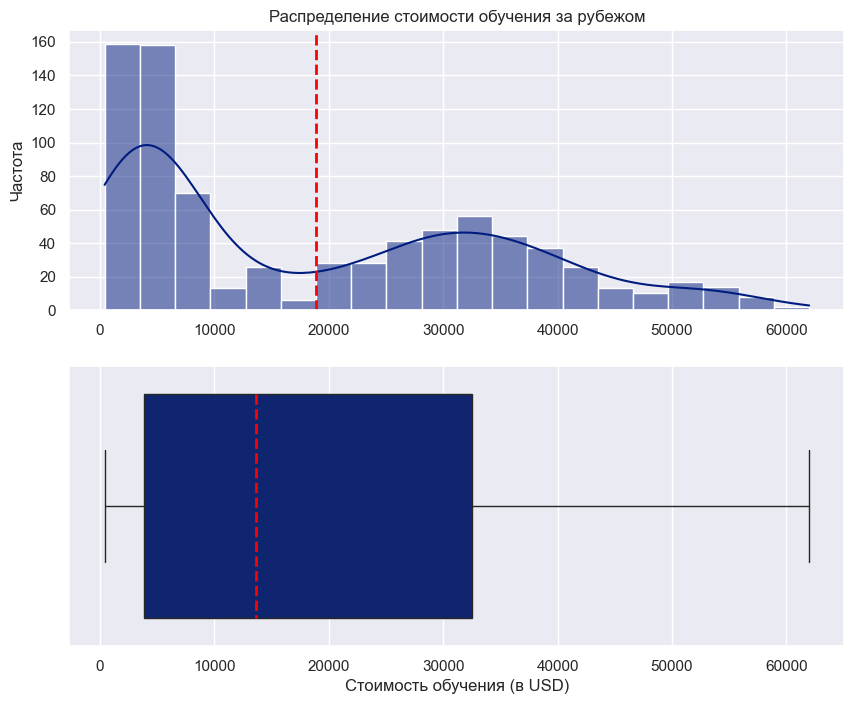

In [667]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Строим гистограмму распределения стоимости обучения за рубежом
sns.histplot(data=data['Tuition_USD'], kde=True, bins=20, ax=axes[0])
axes[0].axvline(data['Tuition_USD'].mean(), color='red', linestyle='--', linewidth=2)
axes[0].set(title='Распределение стоимости обучения за рубежом', xlabel='', ylabel='Частота')

# Строим коробчатую диаграмму распределения стоимости обучения за рубежом
sns.boxplot(data=data['Tuition_USD'], ax=axes[1], orient='h', medianprops={'color': 'red', 'linestyle': '--', 'linewidth': '2'})
axes[1].set(xlabel='Стоимость обучения (в USD)');

In [668]:
# Посмотрим на статистическую характеристику признака 
data['Tuition_USD'].describe().round()

count      804.0
mean     18845.0
std      16428.0
min        400.0
25%       3875.0
50%      13650.0
75%      32500.0
max      62000.0
Name: Tuition_USD, dtype: float64

**Выводы по графику**

1. `Сильный разброс цен` — стоимость обучения варьируется от $400 до $62.000 при стандартном отклонении $16.428, что указывает на огромную разницу между бюджетными и премиальными программами.

2. `Неравномерное распределение` — медиана (в $13.650) значительно ниже среднего ($18.845), что свидетельствует о правосторонней асимметрии - большинство программ дешевле среднего, но есть небольшое количество очень дорогих вариантов, которые "тянут" среднее вверх.

3. `Основной диапазон цен` — 75% программ стоят до $32.500, при этом четверть самых доступных вариантов — ниже $3.875, что может представлять особый интерес для бюджетных абитуриентов.

### Описательные статистики для количественных переменных

#### Распределение длительности обучения за рубежом 

<Figure size 3000x2000 with 0 Axes>

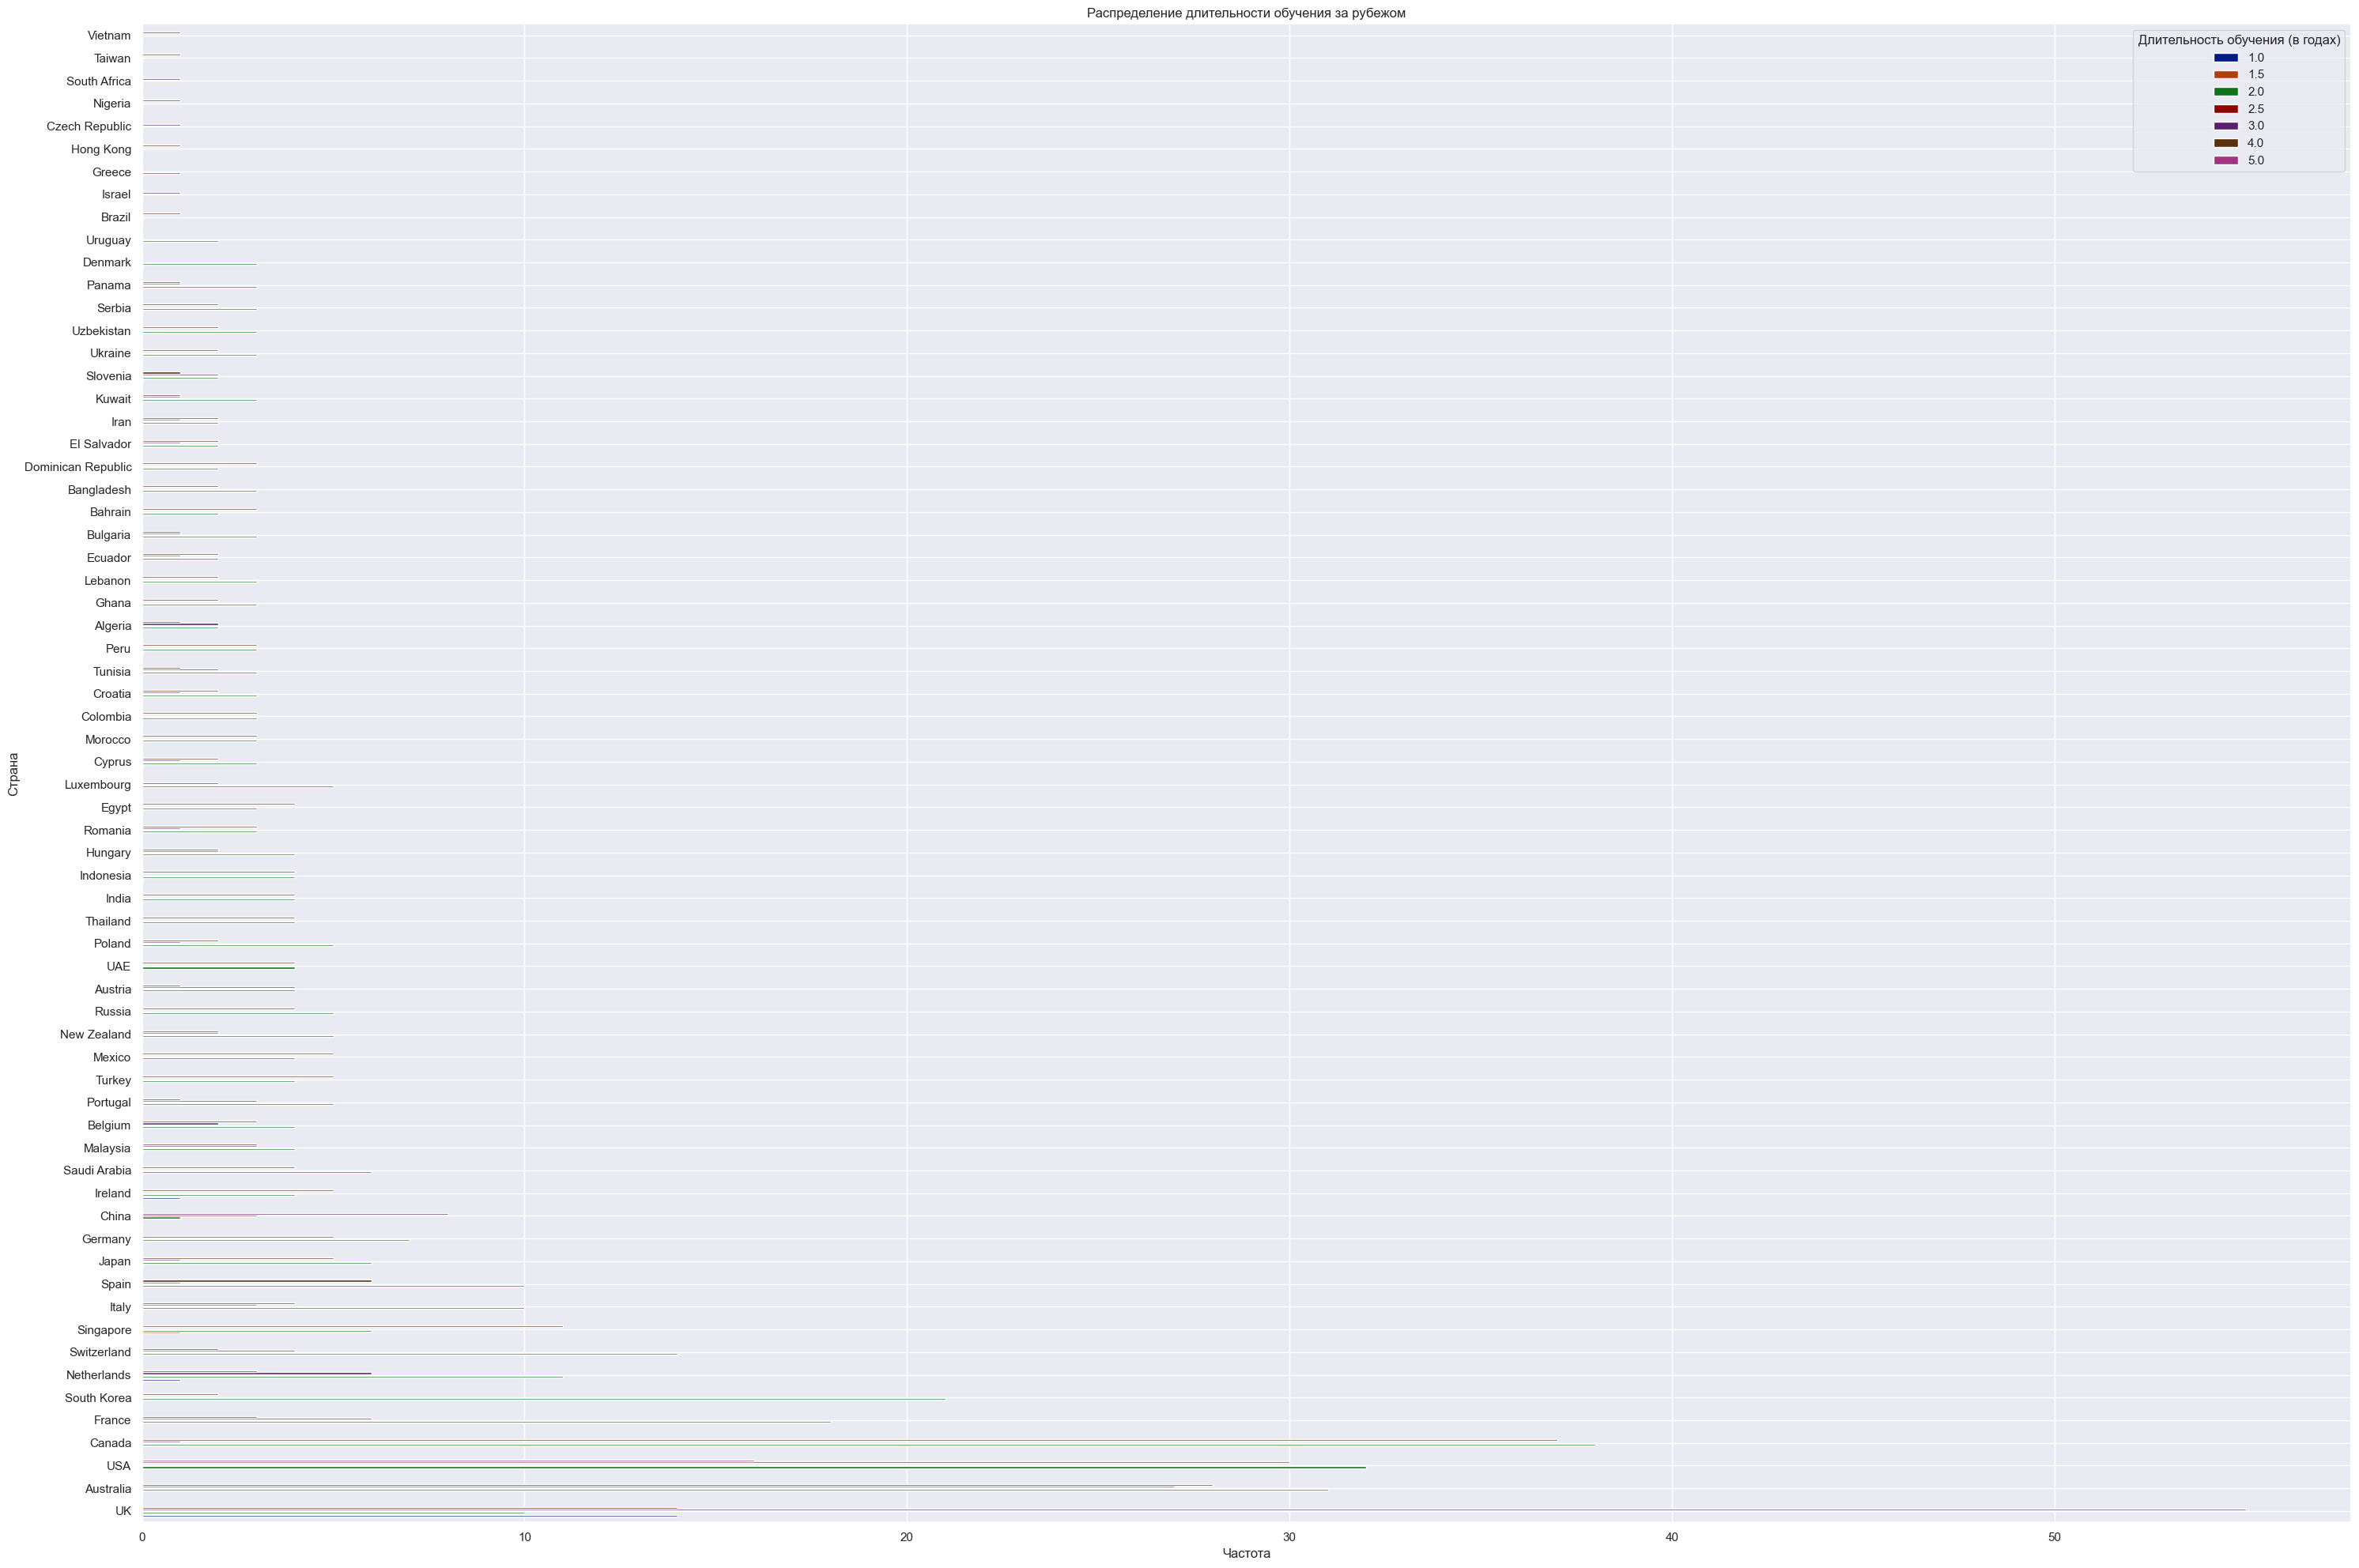

In [669]:
# Подсчитаем общее количество наблюдений по каждой стране
country_counts = data.groupby('Country')['Duration_Years'].count()

# Сортируем наблюдения по убыванию
sorted_countries = country_counts.sort_values(ascending=False)

# Создаём DataFrame с отсортированными странами
duration_years_country = data[data['Country'].isin(sorted_countries.index)]
duration_years_country = duration_years_country.groupby('Country')['Duration_Years'].value_counts().unstack().fillna(0)

# Убедимся, что порядок соответствует отсортированным странам
duration_years_country = duration_years_country.loc[sorted_countries.index]

# Визуализируем распределение
plt.figure(figsize=(30, 20))
duration_years_country.plot(kind='barh', figsize=(30, 20))
plt.title('Распределение длительности обучения за рубежом')
plt.xlabel('Частота')
plt.ylabel('Страна')
plt.legend(title='Длительность обучения (в годах)')
plt.tight_layout()
plt.show();

In [670]:
# Посмотрим на точные значения
sorted_countries

Country
UK                    93
Australia             86
USA                   78
Canada                76
France                27
South Korea           23
Netherlands           21
Switzerland           20
Singapore             18
Italy                 17
Spain                 17
Japan                 12
Germany               12
China                 12
Ireland               10
Saudi Arabia          10
Malaysia              10
Belgium                9
Portugal               9
Turkey                 9
Mexico                 9
New Zealand            9
Russia                 9
Austria                9
UAE                    8
Poland                 8
Thailand               8
India                  8
Indonesia              8
Hungary                8
Romania                7
Egypt                  7
Luxembourg             7
Cyprus                 6
Morocco                6
Colombia               6
Croatia                6
Tunisia                6
Peru                   6
Algeria          

In [671]:
# Выясним самую распространённую длительность обучения
duration_years_country.mean().round(2)

Duration_Years
1.0    0.24
1.5    0.02
2.0    5.47
2.5    0.05
3.0    2.33
4.0    3.83
5.0    0.24
dtype: float64

**Выводы по графику**

1. `Географическое доминирование англоязычных стран` — Великобритания (93), Австралия (86), США (78) и Канада (76) составляют более 40% всех наблюдений, подтверждая их статус самых популярных направлений для обучения за рубежом.

2. `Преобладание программ стандартной длительности` — наиболее распространены 2-летние программы (5.47 средних наблюдений на страну), за которыми следуют 4-летние (3.83) и 3-летние (2.33) программы, что отражает типичную структуру магистратур и бакалавриатов.

3. `Ограниченный выбор нестандартных программ` — программы с промежуточной длительностью (1.5, 2.5 года) встречаются редко (менее 5% наблюдений), что указывает на жесткую стандартизацию образовательных систем в большинстве стран.

#### Распределение индекса стоимости жизни за рубежом

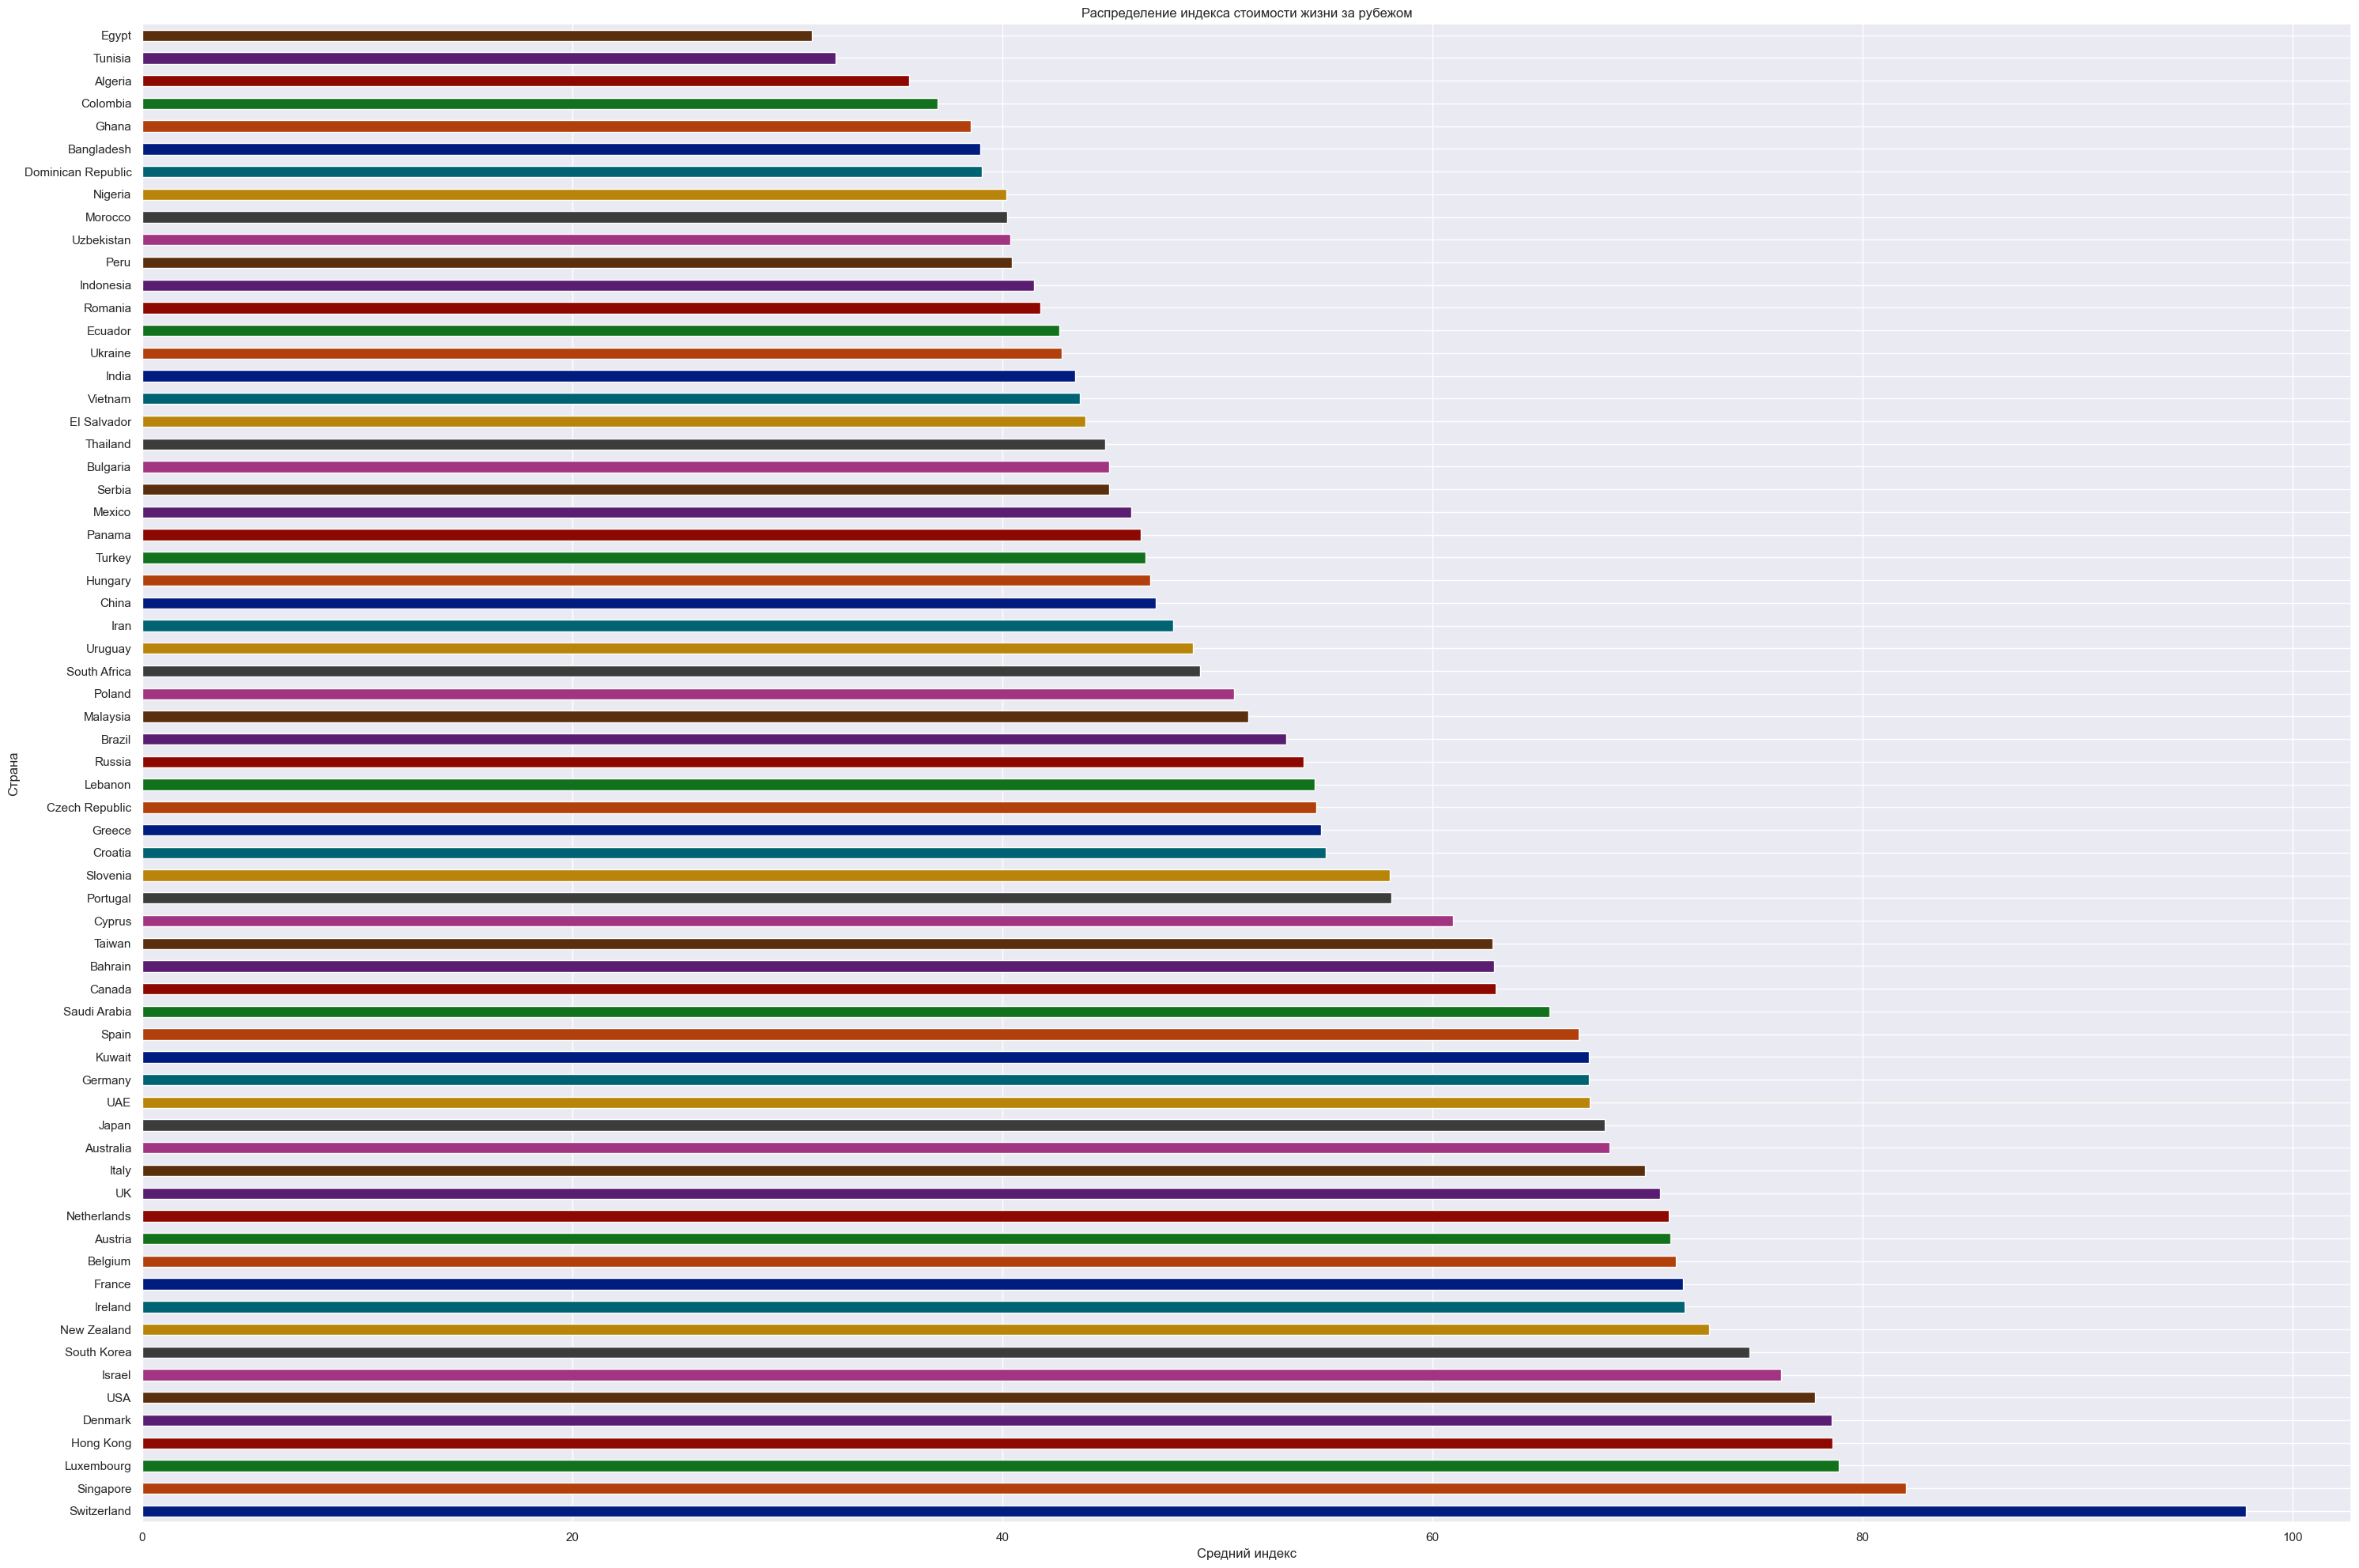

In [672]:
# Подсчитаем среднее для индекса стоимости жизни по каждой стране
country_avg_cost = data.groupby('Country')['Living_Cost_Index'].mean()

# Сортируем страны по убыванию
sorted_countries = country_avg_cost.sort_values(ascending=False)

# Создаём DataFrame с отсортированными странами
avg_cost_by_country = country_avg_cost.loc[sorted_countries.index]

# Создаём палитру 'dark'
palette = sns.color_palette('dark', n_colors=len(avg_cost_by_country))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
ax = avg_cost_by_country.plot(kind='barh', legend=False, color=palette)
plt.title('Распределение индекса стоимости жизни за рубежом')
plt.xlabel('Средний индекс')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [673]:
# Посмотрим на точные значения
avg_cost_by_country.round()

Country
Switzerland           98.0
Singapore             82.0
Luxembourg            79.0
Hong Kong             79.0
Denmark               79.0
USA                   78.0
Israel                76.0
South Korea           75.0
New Zealand           73.0
Ireland               72.0
France                72.0
Belgium               71.0
Austria               71.0
Netherlands           71.0
UK                    71.0
Italy                 70.0
Australia             68.0
Japan                 68.0
UAE                   67.0
Germany               67.0
Kuwait                67.0
Spain                 67.0
Saudi Arabia          65.0
Canada                63.0
Bahrain               63.0
Taiwan                63.0
Cyprus                61.0
Portugal              58.0
Slovenia              58.0
Croatia               55.0
Greece                55.0
Czech Republic        55.0
Lebanon               55.0
Russia                54.0
Brazil                53.0
Malaysia              51.0
Poland              

**Выводы по графику**

1. `Явные лидеры по дороговизне` — Швейцария (98) и Сингапур (82) значительно опережают остальные страны, формируя отдельную группу с экстремально высокими затратами на жизнь. Разрыв между Швейцарией и следующими за ней Люксембургом, Гонконгом и Данией (79) составляет 19 пунктов - это максимальный разрыв между соседними позициями в топ-20.

2. `Географические закономерности`:

    * Европейские страны (особенно Западная и Северная Европа) доминируют в верхней части рейтинга (средний индекс 70+).

    * Азиатские страны демонстрируют полярность: от дорогого Сингапура, Гонконга и Японии до бюджетных Вьетнама и Индии (44-43).

    * Африка и Латинская Америка составляют нижнюю треть рейтинга (31-49).

3. `Практически непрерывный градиент значений` — индекс плавно снижается от 98 до 31 без резких скачков, что свидетельствует:

    * О хорошей сбалансированности методики расчета

    * О постепенном характере изменения экономических условий между странами

    * При этом разница между крайними позициями (Швейцария и Египет) более чем в 3 раза, что подчеркивает глобальное неравенство стоимости жизни.

#### Распределение ежемесячной стоимости аренды студенческого жилья

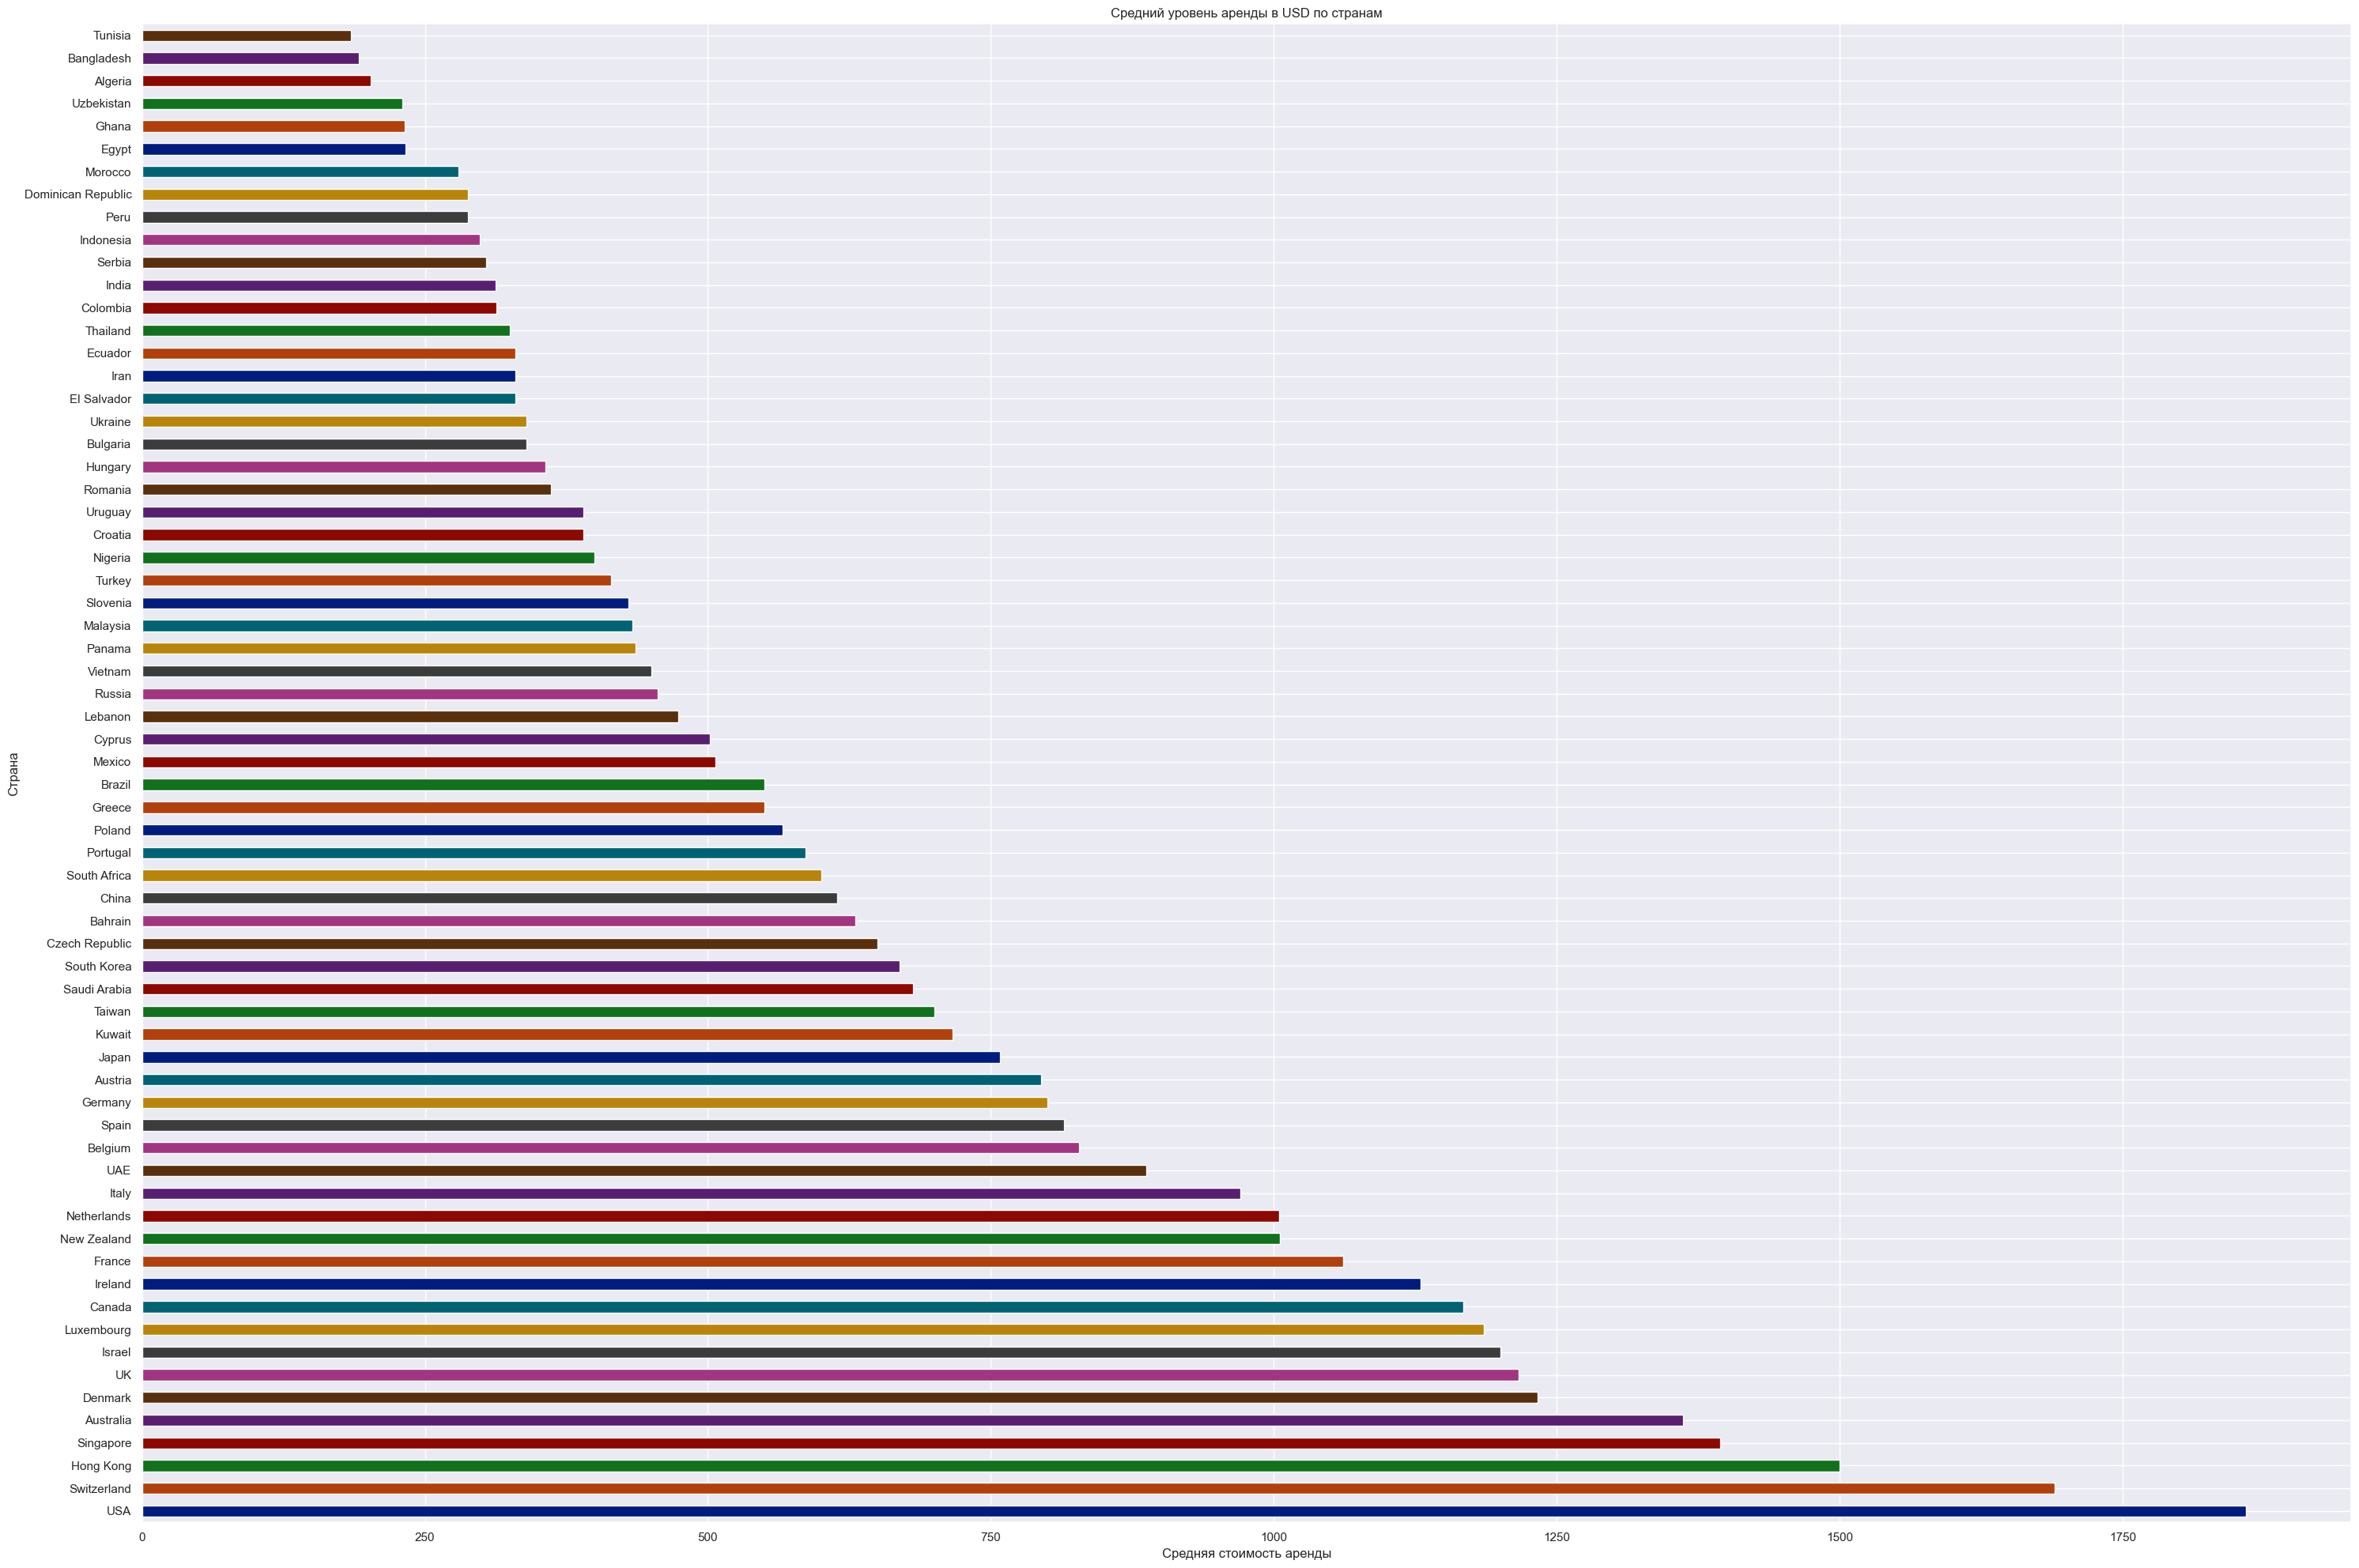

In [674]:
# Подсчитаем среднее для значения аренды в USD по каждой стране
country_avg_rent = data.groupby('Country')['Rent_USD'].mean()

# Сортируем страны по убыванию
sorted_countries = country_avg_rent.sort_values(ascending=False)

# Создаём Series с отсортированными странами
avg_rent_by_country = country_avg_rent.loc[sorted_countries.index]

# Создаём палитру 'dark'
colors = sns.color_palette('dark', len(avg_rent_by_country))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
avg_rent_by_country.plot(kind='barh', color=colors, legend=False)
plt.title('Средний уровень аренды в USD по странам')
plt.xlabel('Средняя стоимость аренды')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [675]:
# Посмотрим на точные значения
avg_rent_by_country.round()

Country
USA                   1859.0
Switzerland           1690.0
Hong Kong             1500.0
Singapore             1394.0
Australia             1362.0
Denmark               1233.0
UK                    1216.0
Israel                1200.0
Luxembourg            1186.0
Canada                1168.0
Ireland               1130.0
France                1061.0
New Zealand           1006.0
Netherlands           1005.0
Italy                  971.0
UAE                    888.0
Belgium                828.0
Spain                  815.0
Germany                800.0
Austria                794.0
Japan                  758.0
Kuwait                 716.0
Taiwan                 700.0
Saudi Arabia           681.0
South Korea            670.0
Czech Republic         650.0
Bahrain                630.0
China                  614.0
South Africa           600.0
Portugal               587.0
Poland                 566.0
Greece                 550.0
Brazil                 550.0
Mexico                 507.0
Cyprus

**Выводы по графику**

1. `Абсолютное лидерство США и Швейцарии` — США ($1859) и Швейцария ($1690) формируют отдельную группу с самыми высокими арендными ставками, значительно опережая даже такие дорогие города как Гонконг ($1500) и Сингапур ($1394). Разрыв между США и третьей позицией (Гонконг) составляет $359 — больше, чем вся аренда в Тунисе ($185).

2. `Четкая региональная стратификация`:

    * Топ-15 (аренда $1000+): исключительно развитые страны Запада + Азия (Гонконг, Сингапур, Израиль)

    * Средний сегмент ($400-900): Восточная Европа, нефтяные монархии, развивающиеся экономики (Китай, Мексика)

    * Бюджетный сегмент (<$400): Африка, Южная Азия, отдельные страны Латинской Америки

3. `Парадоксальная доступность в развитых азиатских странах` — При высоком индексе стоимости жизни, аренда в Японии ($758) и Южной Корее ($670) заметно дешевле, чем в Европе аналогичного уровня (например, Германия — $800, Франция — $1061). Это может объясняться:

    * Культурными особенностями (меньшие площади жилья)

    * Государственным регулированием арендного рынка

    * Концентрацией данных по пригородам мегаполисов

    **Наиболее контрастные пары:**

    * США ($1859) и Бангладеш ($192) — разница почти в 10 раз

    * Швейцария ($1690) и Алжир ($202) — разница в 8.4 раза

    * Разрыв внутри ЕС: Дания ($1233) и Болгария ($340) — 3.6 раза

#### Распределение суммы единовременного сбора за оформление визы

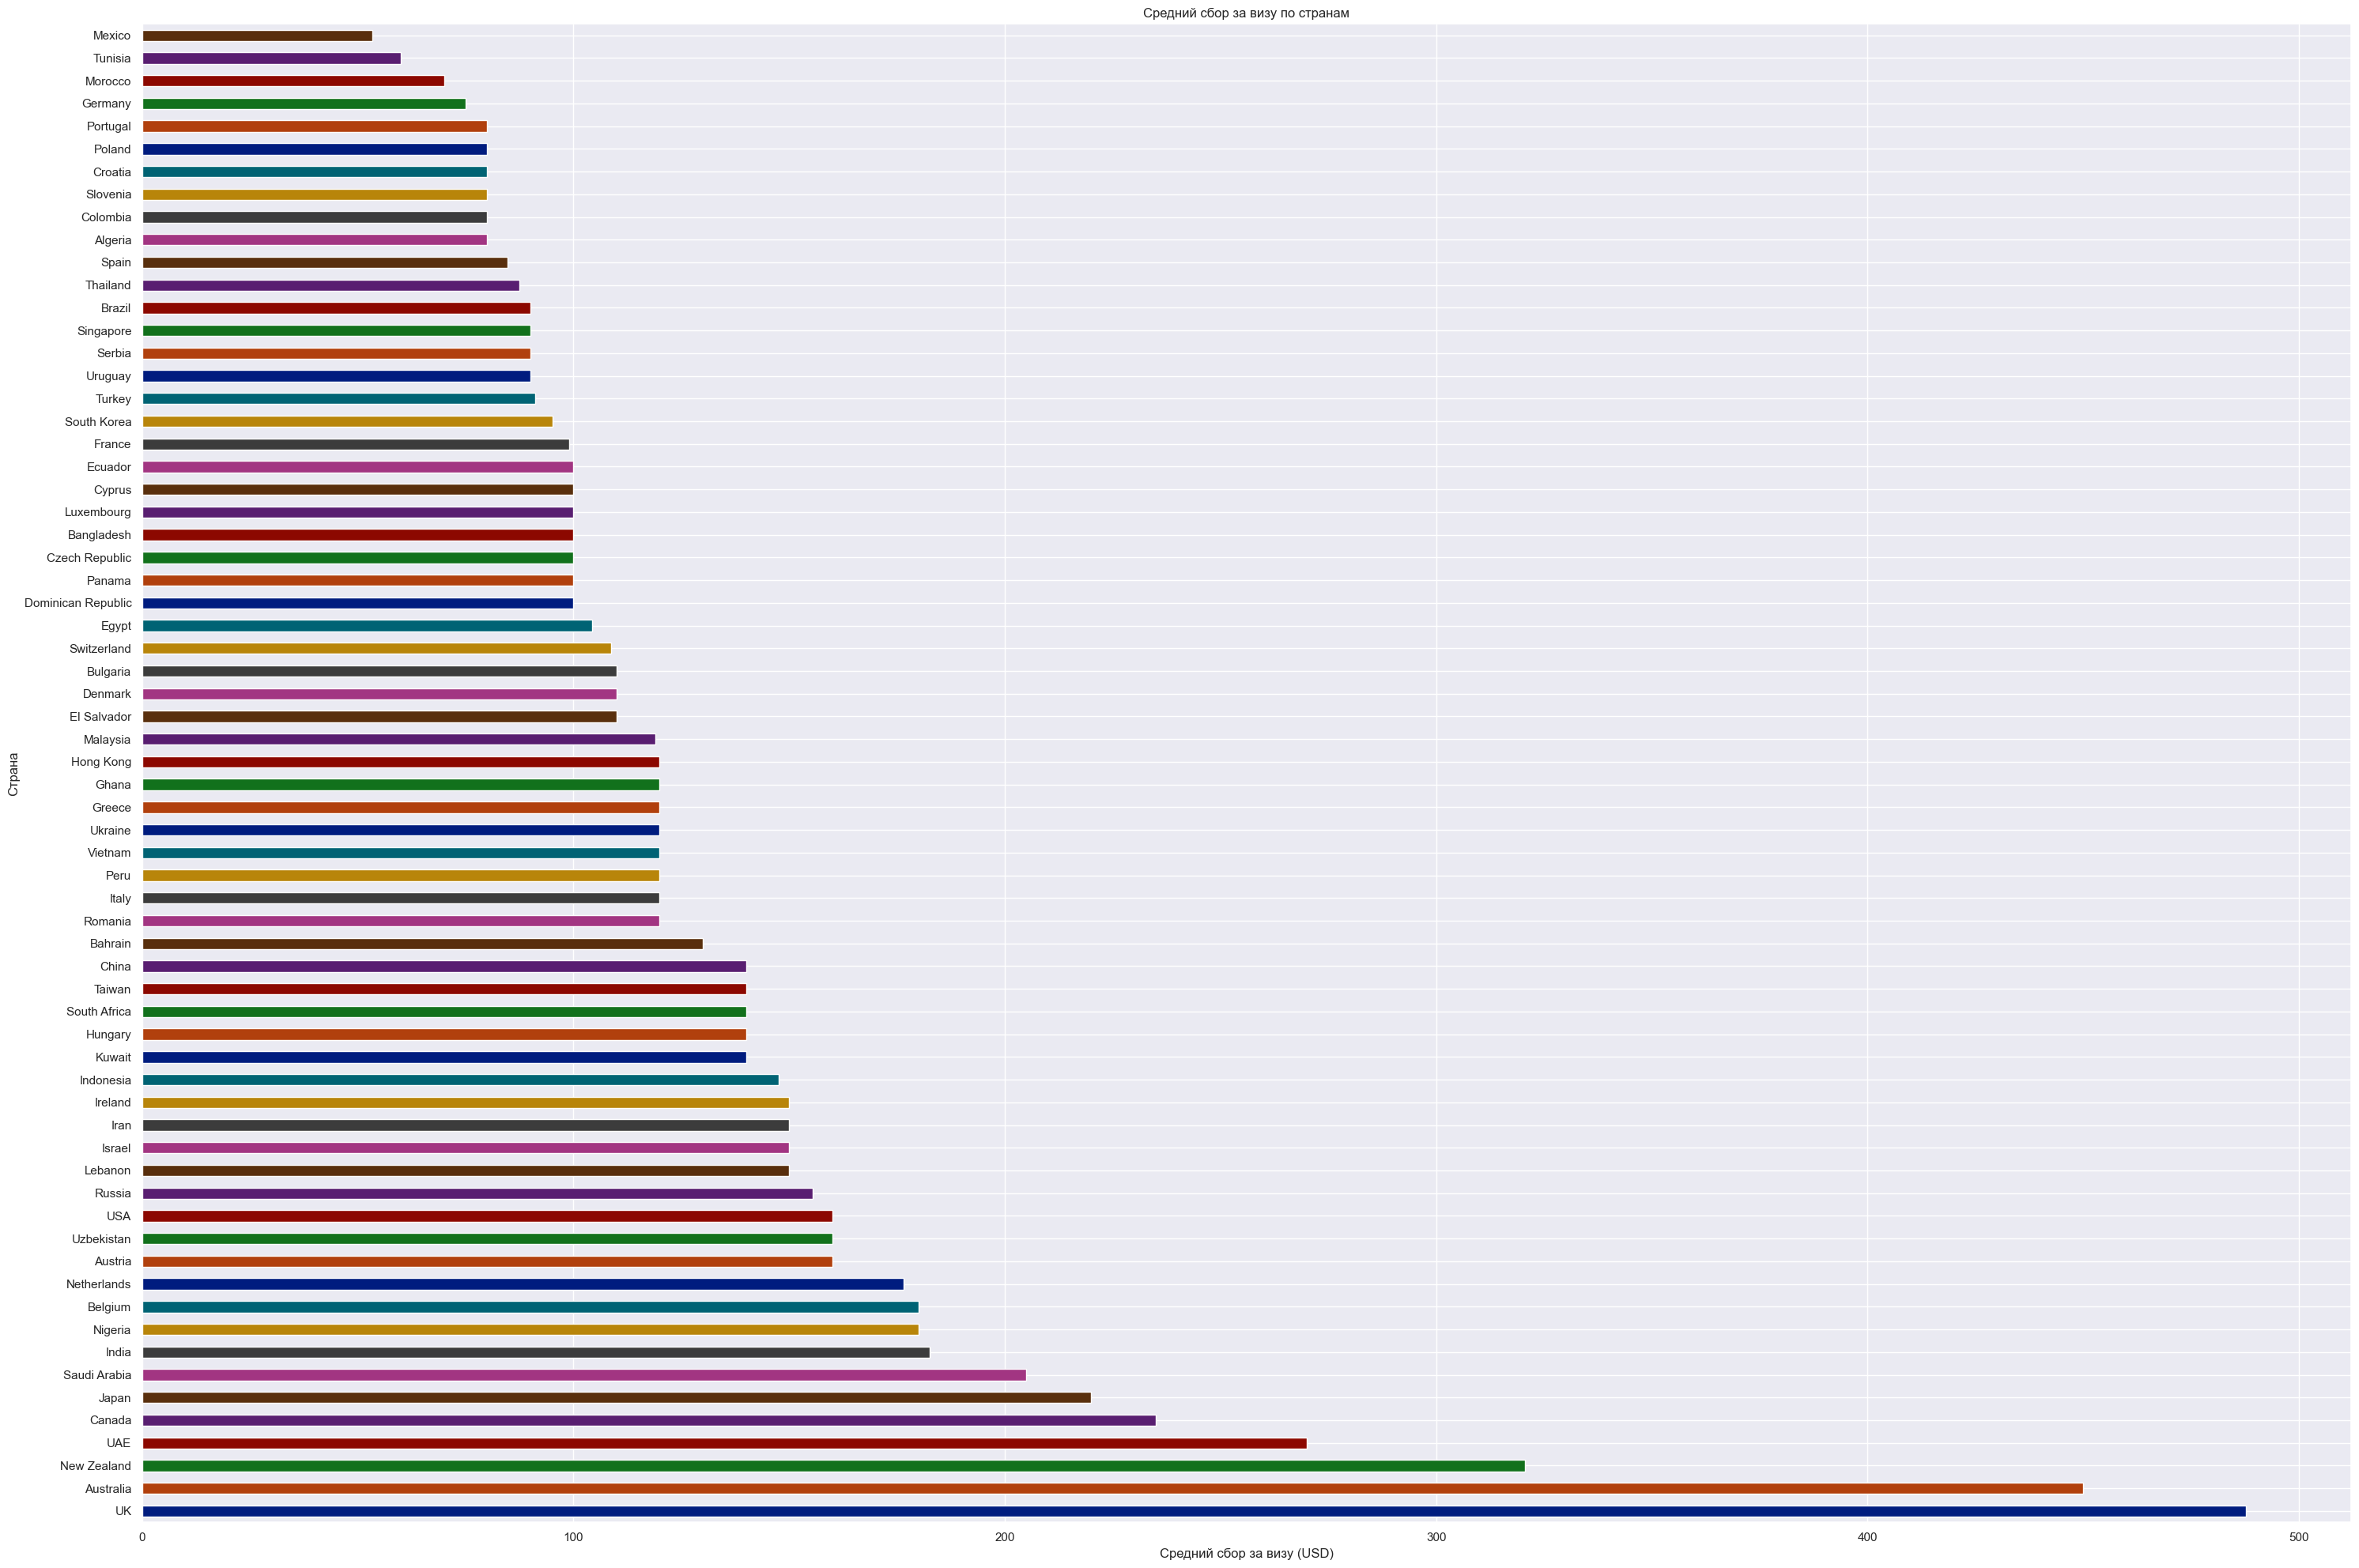

In [676]:
# Подсчитаем среднее для значения стоимости визового сбора в USD по каждой стране
country_avg_visa_fee = data.groupby('Country')['Visa_Fee_USD'].mean()

# Сортируем страны по убыванию
sorted_countries = country_avg_visa_fee.sort_values(ascending=False)

# Создаём Series с отсортированными странами
avg_visa_fee_by_country = country_avg_visa_fee.loc[sorted_countries.index]

# Создаём палитру 'dark'
colors = sns.color_palette('dark', len(avg_visa_fee_by_country))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
avg_visa_fee_by_country.plot(kind='barh', color=colors, legend=False)
plt.title('Средний сбор за визу по странам')
plt.xlabel('Средний сбор за визу (USD)')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [677]:
# Посмотрим на точные значения
avg_visa_fee_by_country.round()

Country
UK                    488.0
Australia             450.0
New Zealand           321.0
UAE                   270.0
Canada                235.0
Japan                 220.0
Saudi Arabia          205.0
India                 182.0
Nigeria               180.0
Belgium               180.0
Netherlands           177.0
Austria               160.0
Uzbekistan            160.0
USA                   160.0
Russia                156.0
Lebanon               150.0
Israel                150.0
Iran                  150.0
Ireland               150.0
Indonesia             148.0
Kuwait                140.0
Hungary               140.0
South Africa          140.0
Taiwan                140.0
China                 140.0
Bahrain               130.0
Romania               120.0
Italy                 120.0
Peru                  120.0
Vietnam               120.0
Ukraine               120.0
Greece                120.0
Ghana                 120.0
Hong Kong             120.0
Malaysia              119.0
El Salvador 

**Выводы по графику**

1. `Премиум-сегмент визовых сборов` — Великобритания ($488) и Австралия ($450) выделяются как самые дорогие направления с визовыми сборами в 2-3 раза выше среднего (особенно заметен разрыв между Австралией и следующей за ней Новой Зеландией — $321). Это отражает их жесткую иммиграционную политику и высокий спрос на въезд.

2. `Поляризация по географическому принципу`:

    * Высокие сборы ($150+): преимущественно англоязычные страны и нефтяные монархии Персидского залива

    * Умеренные сборы ($80-150): большинство европейских и азиатских стран

    * Бюджетные варианты (<$80): развивающиеся экономики Латинской Америки и Северной Африки (рекордно низкий сбор у Мексики — $53)

3. `Неожиданные дисбалансы среди развитых стран` — Германия ($75) и Франция ($99) имеют значительно более низкие сборы по сравнению с США ($160) и Канадой ($235), что может объясняться:

    * Разной структурой визовых программ (краткосрочные и долгосрочные визы)

    * Политикой привлечения определенных категорий мигрантов

    * Включением/исключением дополнительных сервисных сборов

    **Наиболее контрастные сравнения:**

    * Великобритания и Мексика: разница в 9.2 раза

    * Австралия и Германия: разница в 6 раз

    * США ($160) и соседняя Мексика ($53): разница в 3 раза при географической близости

#### Распределение стоимости ежегодного медицинского страхования

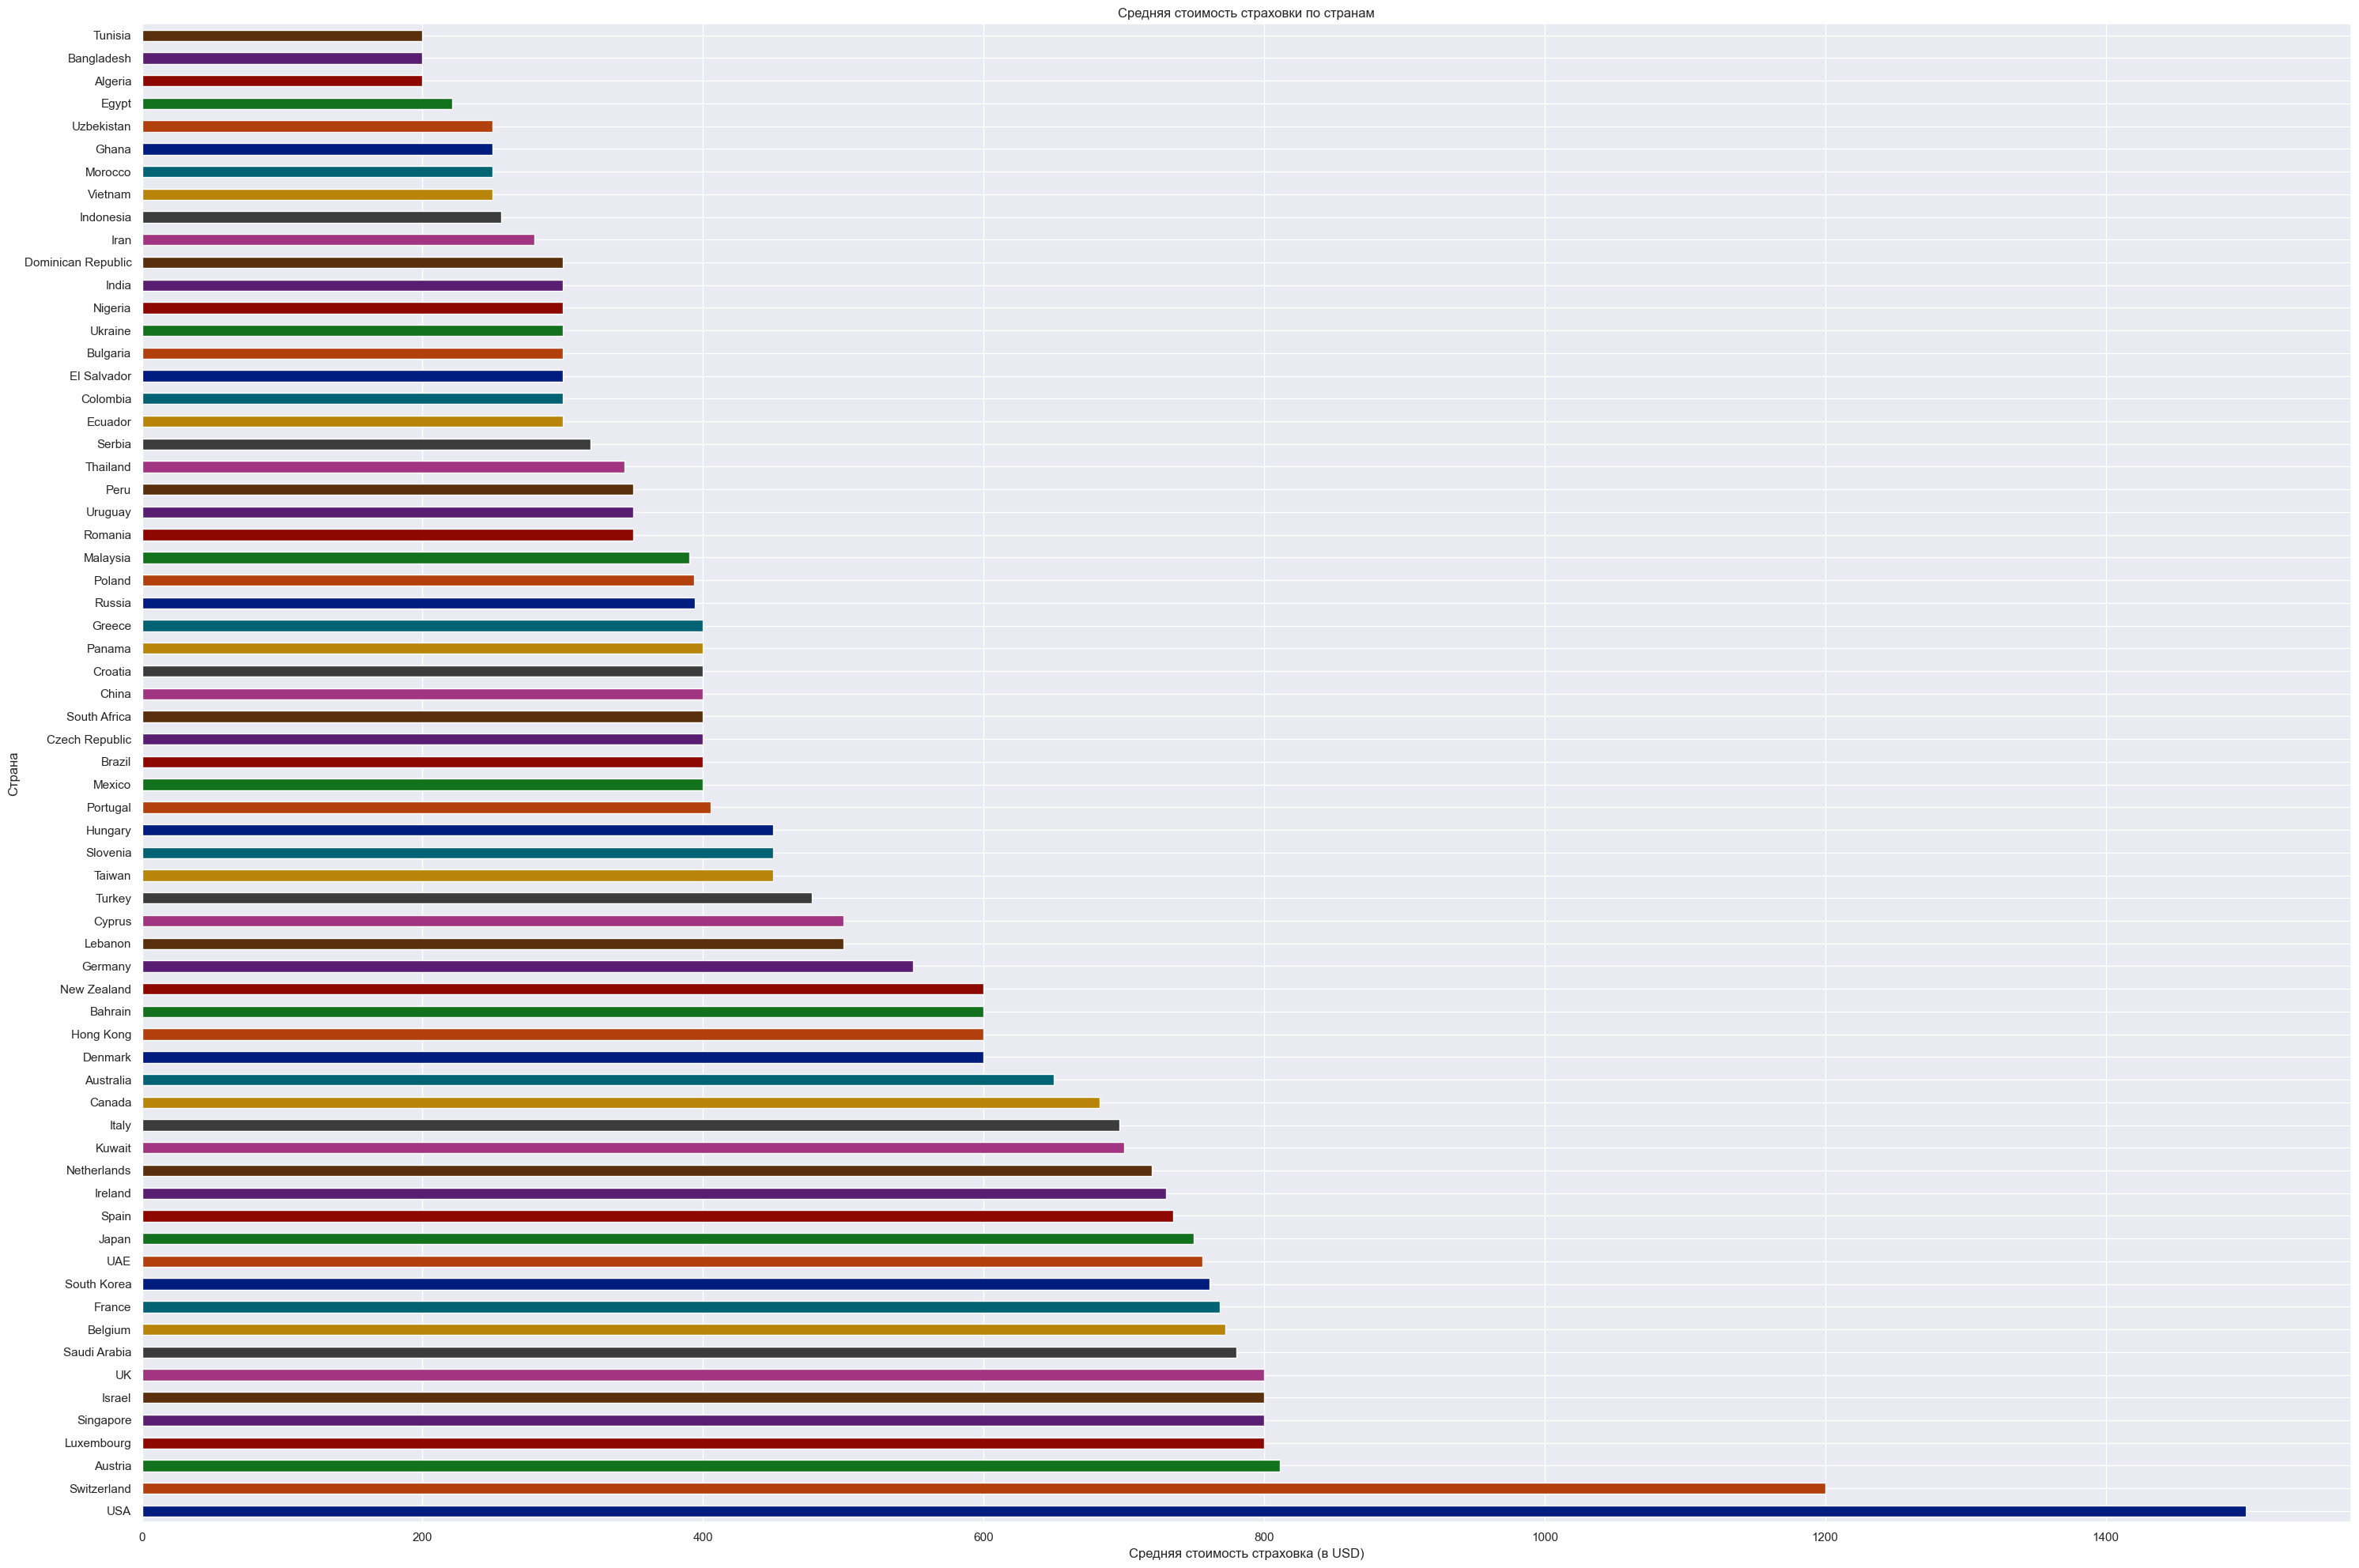

In [678]:
# Подсчитаем среднее для значения стоимости страховки в USD по каждой стране
country_avg_insurance = data.groupby('Country')['Insurance_USD'].mean()

# Сортируем страны по убыванию
sorted_countries = country_avg_insurance.sort_values(ascending=False)

# Создаём Series с отсортированными странами
avg_insurance_by_country = country_avg_insurance.loc[sorted_countries.index]

# Создаём палитру 'dark'
colors = sns.color_palette('dark', len(avg_insurance_by_country))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
avg_insurance_by_country.plot(kind='barh', color=colors, legend=False)
plt.title('Средняя стоимость страховки по странам')
plt.xlabel('Средняя стоимость страховка (в USD)')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [679]:
# Посмотрим на точные значения
avg_insurance_by_country.round()

Country
USA                   1500.0
Switzerland           1200.0
Austria                811.0
Luxembourg             800.0
Singapore              800.0
Israel                 800.0
UK                     800.0
Saudi Arabia           780.0
Belgium                772.0
France                 769.0
South Korea            761.0
UAE                    756.0
Japan                  750.0
Spain                  735.0
Ireland                730.0
Netherlands            720.0
Kuwait                 700.0
Italy                  697.0
Canada                 683.0
Australia              650.0
Denmark                600.0
Hong Kong              600.0
Bahrain                600.0
New Zealand            600.0
Germany                550.0
Lebanon                500.0
Cyprus                 500.0
Turkey                 478.0
Taiwan                 450.0
Slovenia               450.0
Hungary                450.0
Portugal               406.0
Mexico                 400.0
Brazil                 400.0
Czech 

**Выводы по графику**

1. `США и Швейцария` — лидеры по стоимости страховки ($1500 и $1200 соответственно), что может быть связано с высокими ценами на медицину в этих странах.

2. `Европа и развитые азиатские страны` (Австрия, Люксембург, Сингапур, Япония и др.) — держат средний диапазон $700–800, тогда как развивающиеся страны (Индия, Египет, Вьетнам, Украина и др.) имеют значительно более низкие цены ($200–400).

3. `Самая дешёвая страховка` — в Алжире, Бангладеше и Тунисе ($200), что может отражать разницу в стоимости медицинских услуг или требованиях к покрытию.

#### Распределение курса местных валют за доллар США

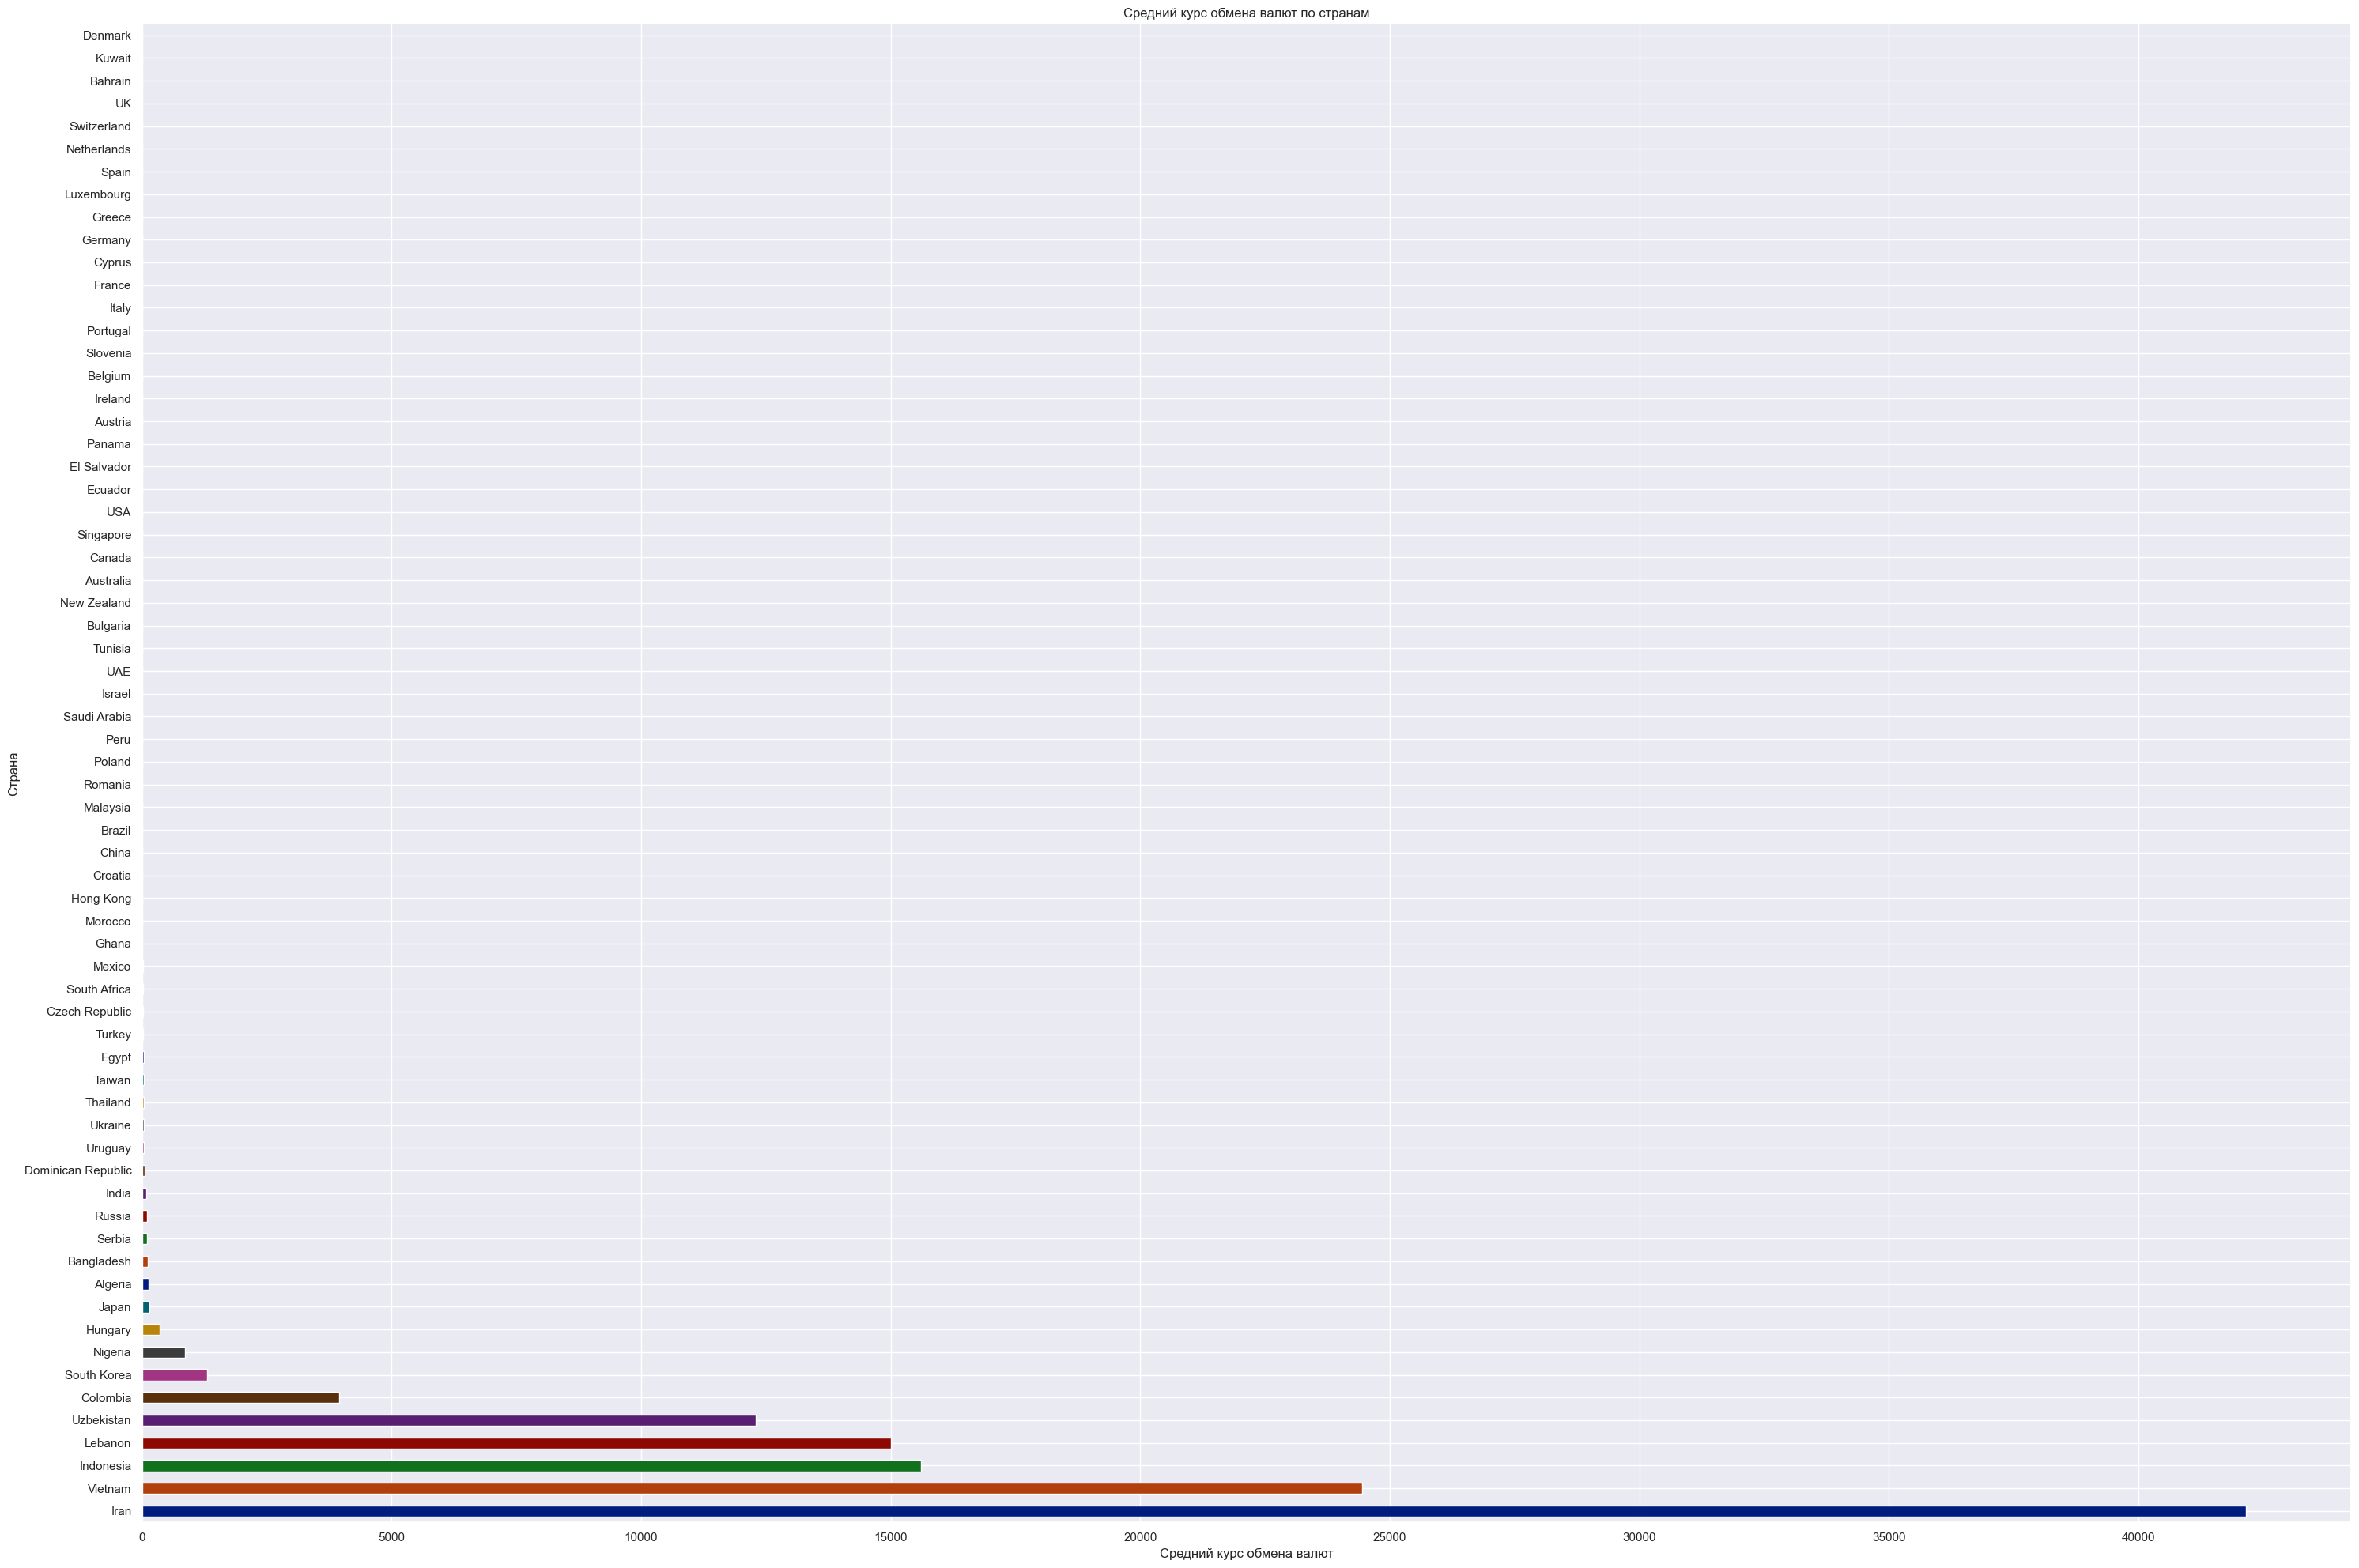

In [680]:
# Подсчитаем среднее для значения курса обмена валют по каждой стране
country_avg_exchange_rate = data.groupby('Country')['Exchange_Rate'].mean()

# Сортируем страны по убыванию
sorted_countries = country_avg_exchange_rate.sort_values(ascending=False)

# Создаём Series с отсортированными странами
avg_exchange_rate_by_country = country_avg_exchange_rate.loc[sorted_countries.index]

# Создаём палитру 'dark'
colors = sns.color_palette('dark', len(avg_exchange_rate_by_country))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
avg_exchange_rate_by_country.plot(kind='barh', color=colors, legend=False)
plt.title('Средний курс обмена валют по странам')
plt.xlabel('Средний курс обмена валют')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [681]:
# Посмотрим на точные значения
avg_exchange_rate_by_country

Country
Iran                  42150.000000
Vietnam               24450.000000
Indonesia             15605.000000
Lebanon               15000.000000
Uzbekistan            12300.000000
Colombia               3950.000000
South Korea            1302.673913
Nigeria                 860.200000
Hungary                 350.250000
Japan                   145.800000
Algeria                 137.500000
Bangladesh              109.500000
Serbia                  108.500000
Russia                   95.200000
India                    82.806250
Dominican Republic       56.800000
Uruguay                  39.500000
Ukraine                  36.800000
Thailand                 35.243750
Taiwan                   31.200000
Egypt                    30.900000
Turkey                   28.722222
Czech Republic           22.500000
South Africa             18.720000
Mexico                   17.066667
Ghana                    12.000000
Morocco                  10.150000
Hong Kong                 7.820000
Croatia     

**Вывод по графику**

1. `Гиперинфляционные валюты` — Иран (42.150), Вьетнам (24.450) и Индонезия (15.605) имеют крайне слабые курсы к доллару, что может указывать на экономическую нестабильность, санкции или высокую инфляцию в этих странах.

2. `Сильные валюты развитых стран` — Швейцария (0.89), ЕС (0.92 для еврозоны) и Великобритания (0.79) демонстрируют высокую устойчивость к доллару, что отражает стабильность их экономик.
Кувейт (0.31) и Бахрейн (0.38) имеют самые крепкие курсы благодаря нефтяным доходам и привязке к доллару.

3. `Долларизация и независимая денежная политика` — Эквадор, Сальвадор и Панама (курс 1:1) официально используют доллар, тогда как Китай (7.15) и Россия (95.2) поддерживают контролируемый курс, но с разной степенью гибкости.

#### Распределение общих ежегодных затрат

In [682]:
# Определяем функцию для расчёта предполагаемой ежегодной стоимости обучения и проживания
def estimate_annual_cost(row):
    # Расчёт стоимости обучения в год: общую стоимость делим на продолжительность обучения в годах
    tuition_cost = row['Tuition_USD'] / row['Duration_Years']
    # Расчёт стоимости жизни: индекс стоимости жизни (в процентах) умножаем на базовую сумму (12,000$)
    living_cost = row['Living_Cost_Index'] / 100 * 12000
    # Расчёт стоимости аренды: месячная аренда умноженная на 12 месяцев
    rent_cost = row['Rent_USD'] * 12
    # Виза: фиксированная плата за визу
    visa_cost = row['Visa_Fee_USD']
    # Страховка: стоимость страховки
    insurance_cost = row['Insurance_USD']
    # Общие предполагаемые затраты в год — сумма всех вышеуказанных затрат
    res = tuition_cost + living_cost + rent_cost + visa_cost + insurance_cost
    # Округляем результат до ближайшего целого числа
    return round(res)

# Применяем функцию к каждой строке датасета и сохраняем результат в новый столбец
data['Estimated_Annual_Cost'] = data.apply(estimate_annual_cost, axis=1)

# Выводим полученный результат для каждой строки
data['Estimated_Annual_Cost']

0      65780
1      73181
2      48285
3      47444
4      22535
5      30188
6      43484
7      56755
8      28751
9      38198
12     19976
13     23274
14     57648
15     17993
16     33121
17     20648
18     22165
19     45035
20     41590
21     39773
22     33261
23     32180
24     33652
25     18345
26     28494
27     17826
28     18119
29     50840
30     48804
31     36875
32     38509
33     19800
34     33895
35     25116
36     32095
37     30486
38     33774
40     45050
41     55118
42     29371
43     56085
44     13222
46     16274
47     28670
48     18603
49     13394
50     48189
51     34560
52     37879
53     40703
55     20248
56     23026
57     28813
60     22014
61     24636
62     20140
63     20718
64     17821
65     19240
66     26305
67     17674
68     21456
69     16245
70     19026
71     33453
72     41126
73     32800
74     35748
75     28991
76     38214
77     29573
78     35996
79     30877
80     34326
81     17771
82     19195
83     20819

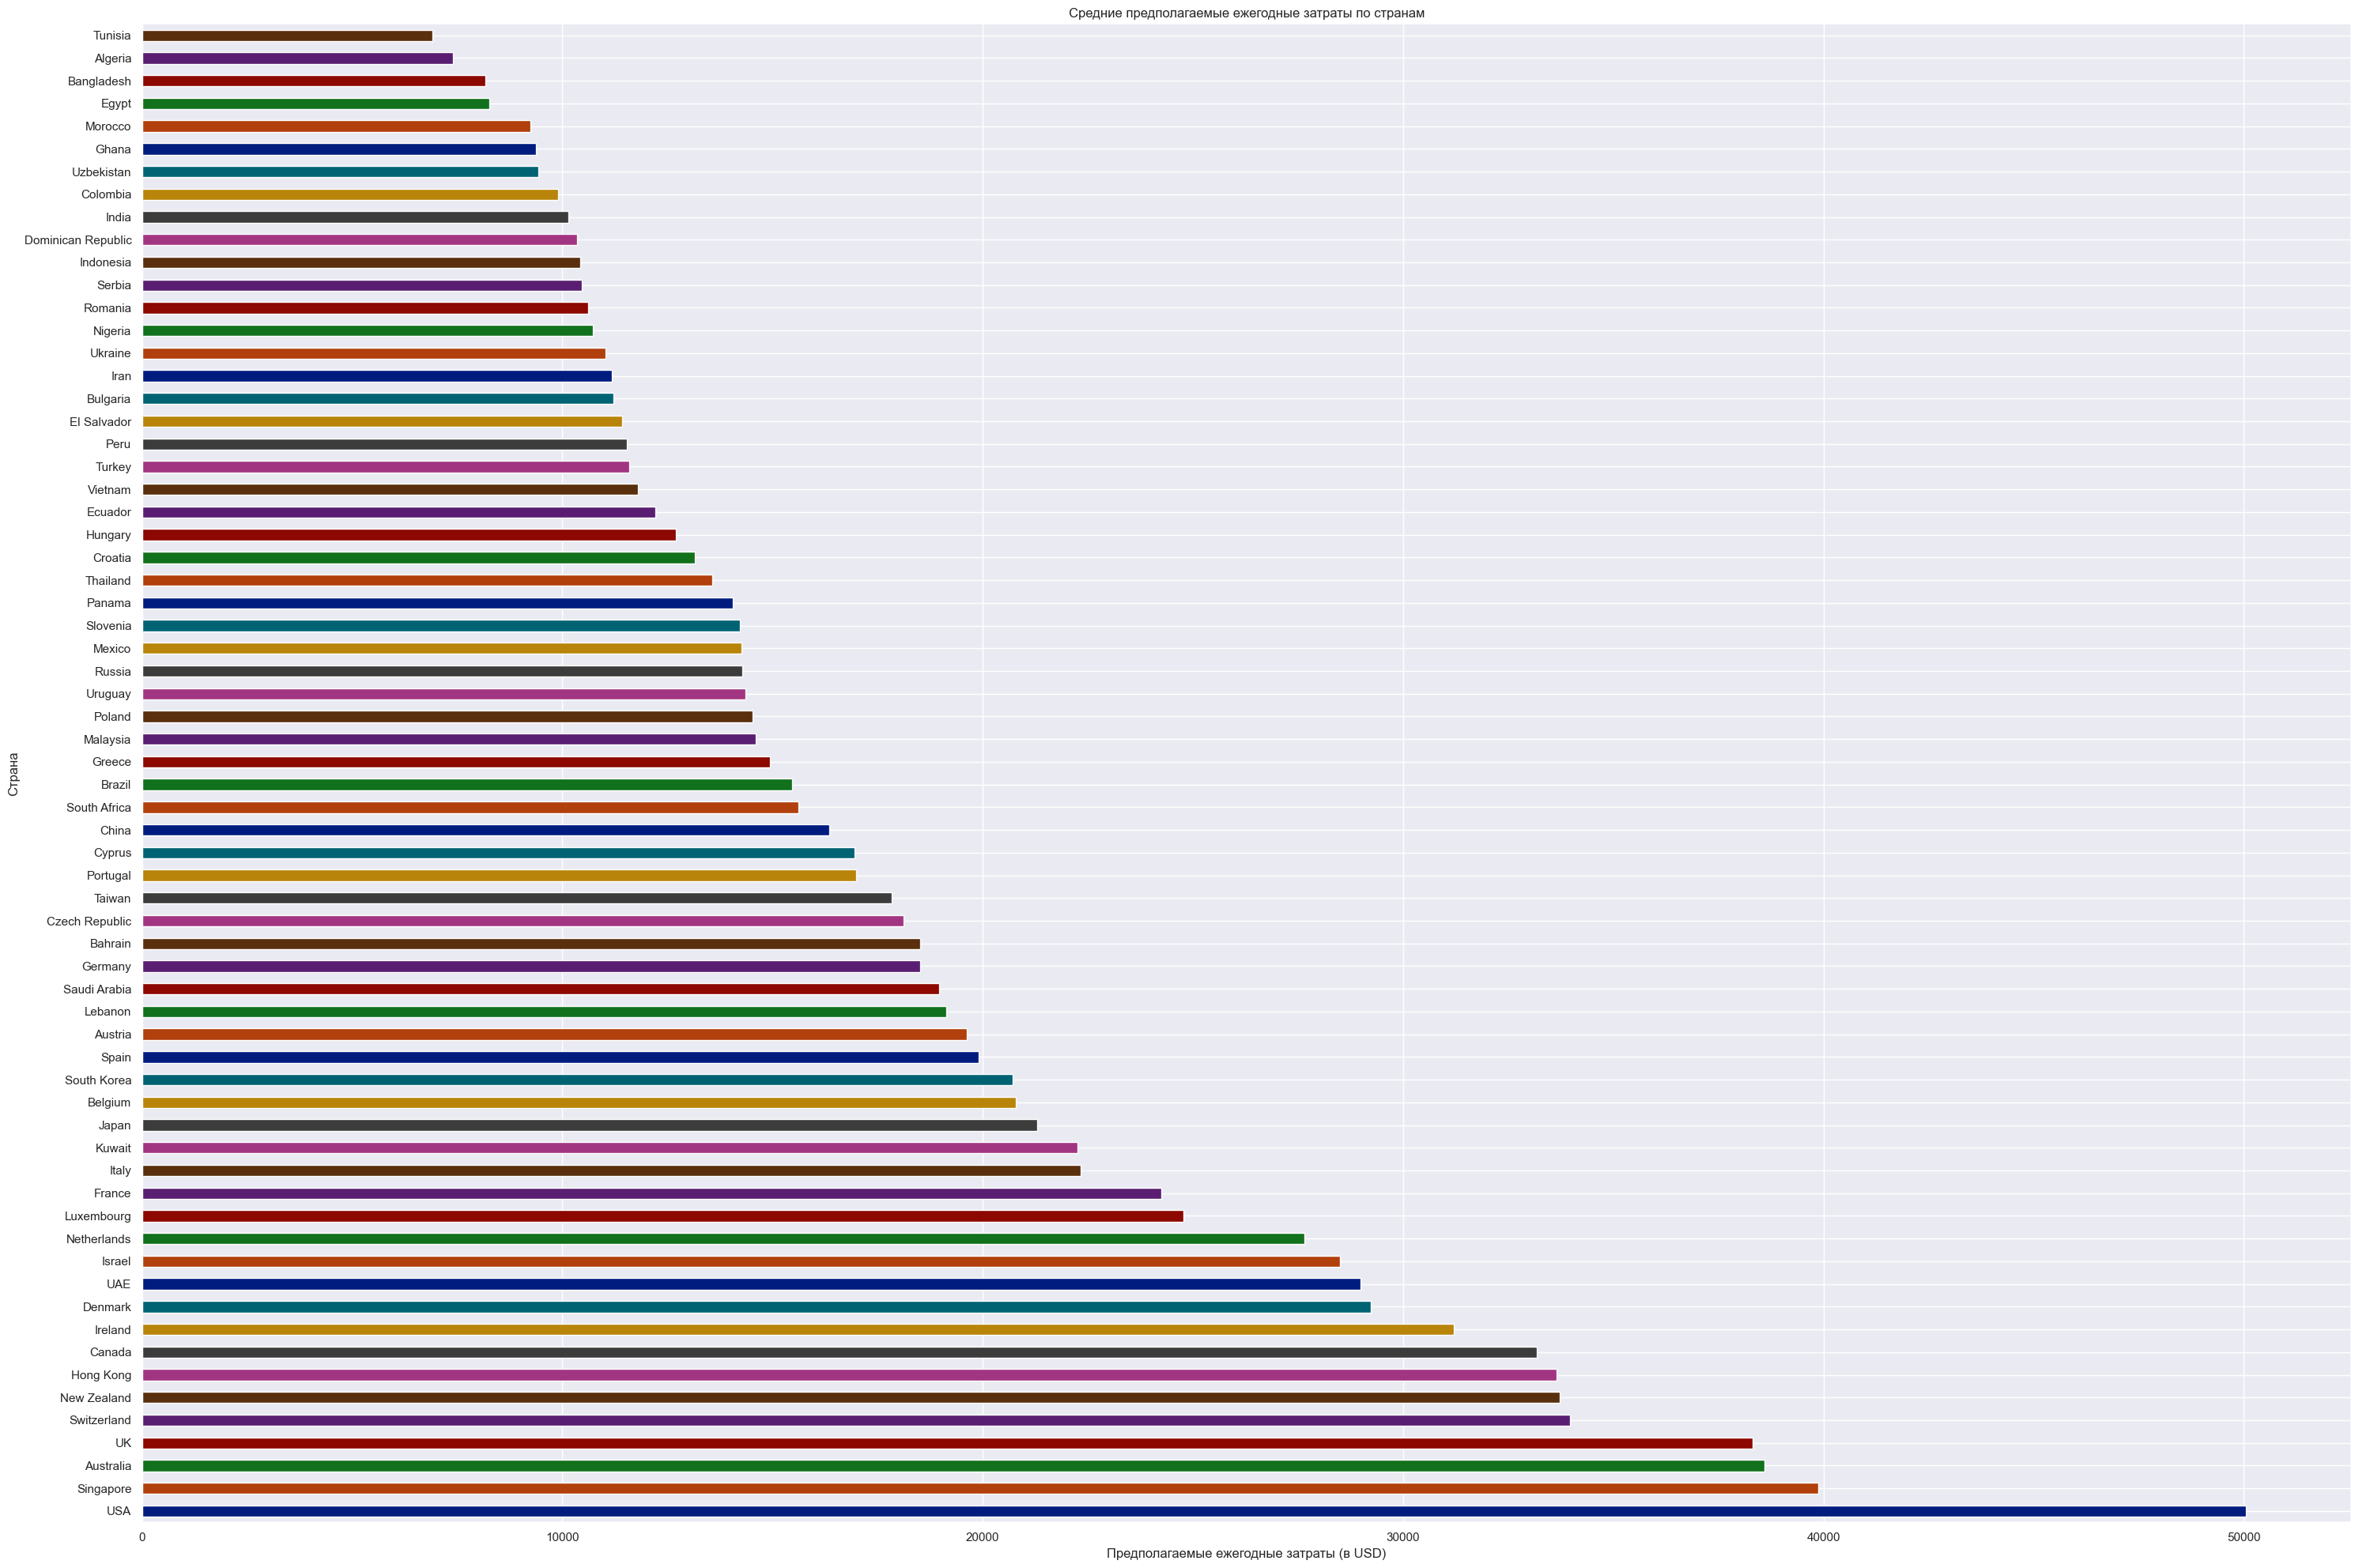

In [683]:
# Подсчитаем среднее для значения ежегодных затрат по каждой стране
country_avg_estimated_annual_cost = data.groupby('Country')['Estimated_Annual_Cost'].mean()

# Сортируем страны по убыванию
sorted_countries = country_avg_estimated_annual_cost.sort_values(ascending=False)

# Создаём Series с отсортированными странами
avg_estimated_annual_cost_by_country = country_avg_estimated_annual_cost.loc[sorted_countries.index]

# Создаём палитру 'dark'
colors = sns.color_palette('dark', len(avg_estimated_annual_cost_by_country))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
avg_estimated_annual_cost_by_country.plot(kind='barh', color=colors, legend=False)
plt.title('Средние предполагаемые ежегодные затраты по странам')
plt.xlabel('Предполагаемые ежегодные затраты (в USD)')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [684]:
# Посмотрим на точные значения
avg_estimated_annual_cost_by_country.round()

Country
USA                   50048.0
Singapore             39868.0
Australia             38606.0
UK                    38314.0
Switzerland           33973.0
New Zealand           33722.0
Hong Kong             33652.0
Canada                33186.0
Ireland               31210.0
Denmark               29238.0
UAE                   28990.0
Israel                28494.0
Netherlands           27648.0
Luxembourg            24777.0
France                24249.0
Italy                 22327.0
Kuwait                22256.0
Japan                 21289.0
Belgium               20790.0
South Korea           20713.0
Spain                 19900.0
Austria               19630.0
Lebanon               19133.0
Saudi Arabia          18966.0
Germany               18511.0
Bahrain               18508.0
Czech Republic        18119.0
Taiwan                17826.0
Portugal              16981.0
Cyprus                16951.0
China                 16346.0
South Africa          15611.0
Brazil                15474.0
Gr

**Выводы по графику**

1. `Лидеры затрат` – развитые англоязычные и европейские страны
США ($50.048), Сингапур ($39.868), Австралия ($38.606) и Великобритания ($38.314) возглавляют рейтинг, что отражает высокую стоимость жизни, зарплат и сервисов в этих странах.
Швейцария ($33.973) и Канада ($33.186) также в топ-10, несмотря на меньшее население, что подчеркивает их экономическую устойчивость.

2. `Разрыв между развитыми и развивающимися странами` – затраты в ТОП-10 странах в 3–5 раз выше, чем в нижней части списка (например, Тунис – $6.916, Бангладеш – $8.164).
Китай ($16.346) и Россия ($14.285) занимают промежуточное положение, демонстрируя рост, но пока не догоняют лидеров.

3. `Неожиданные позиции некоторых стран`:

    * ОАЭ ($28.990) и Саудовская Аравия ($18.966) выделяются на фоне Ближнего Востока благодаря нефтяной экономике и высоким доходам.

    * Украина ($11.021) и Иран ($11.177) оказались ниже многих соседей, вероятно, из-за политических и экономических кризисов.

### Описательные статистики для категориальных переменных

#### Распределение количества уникальных городов как универсальность направлений  

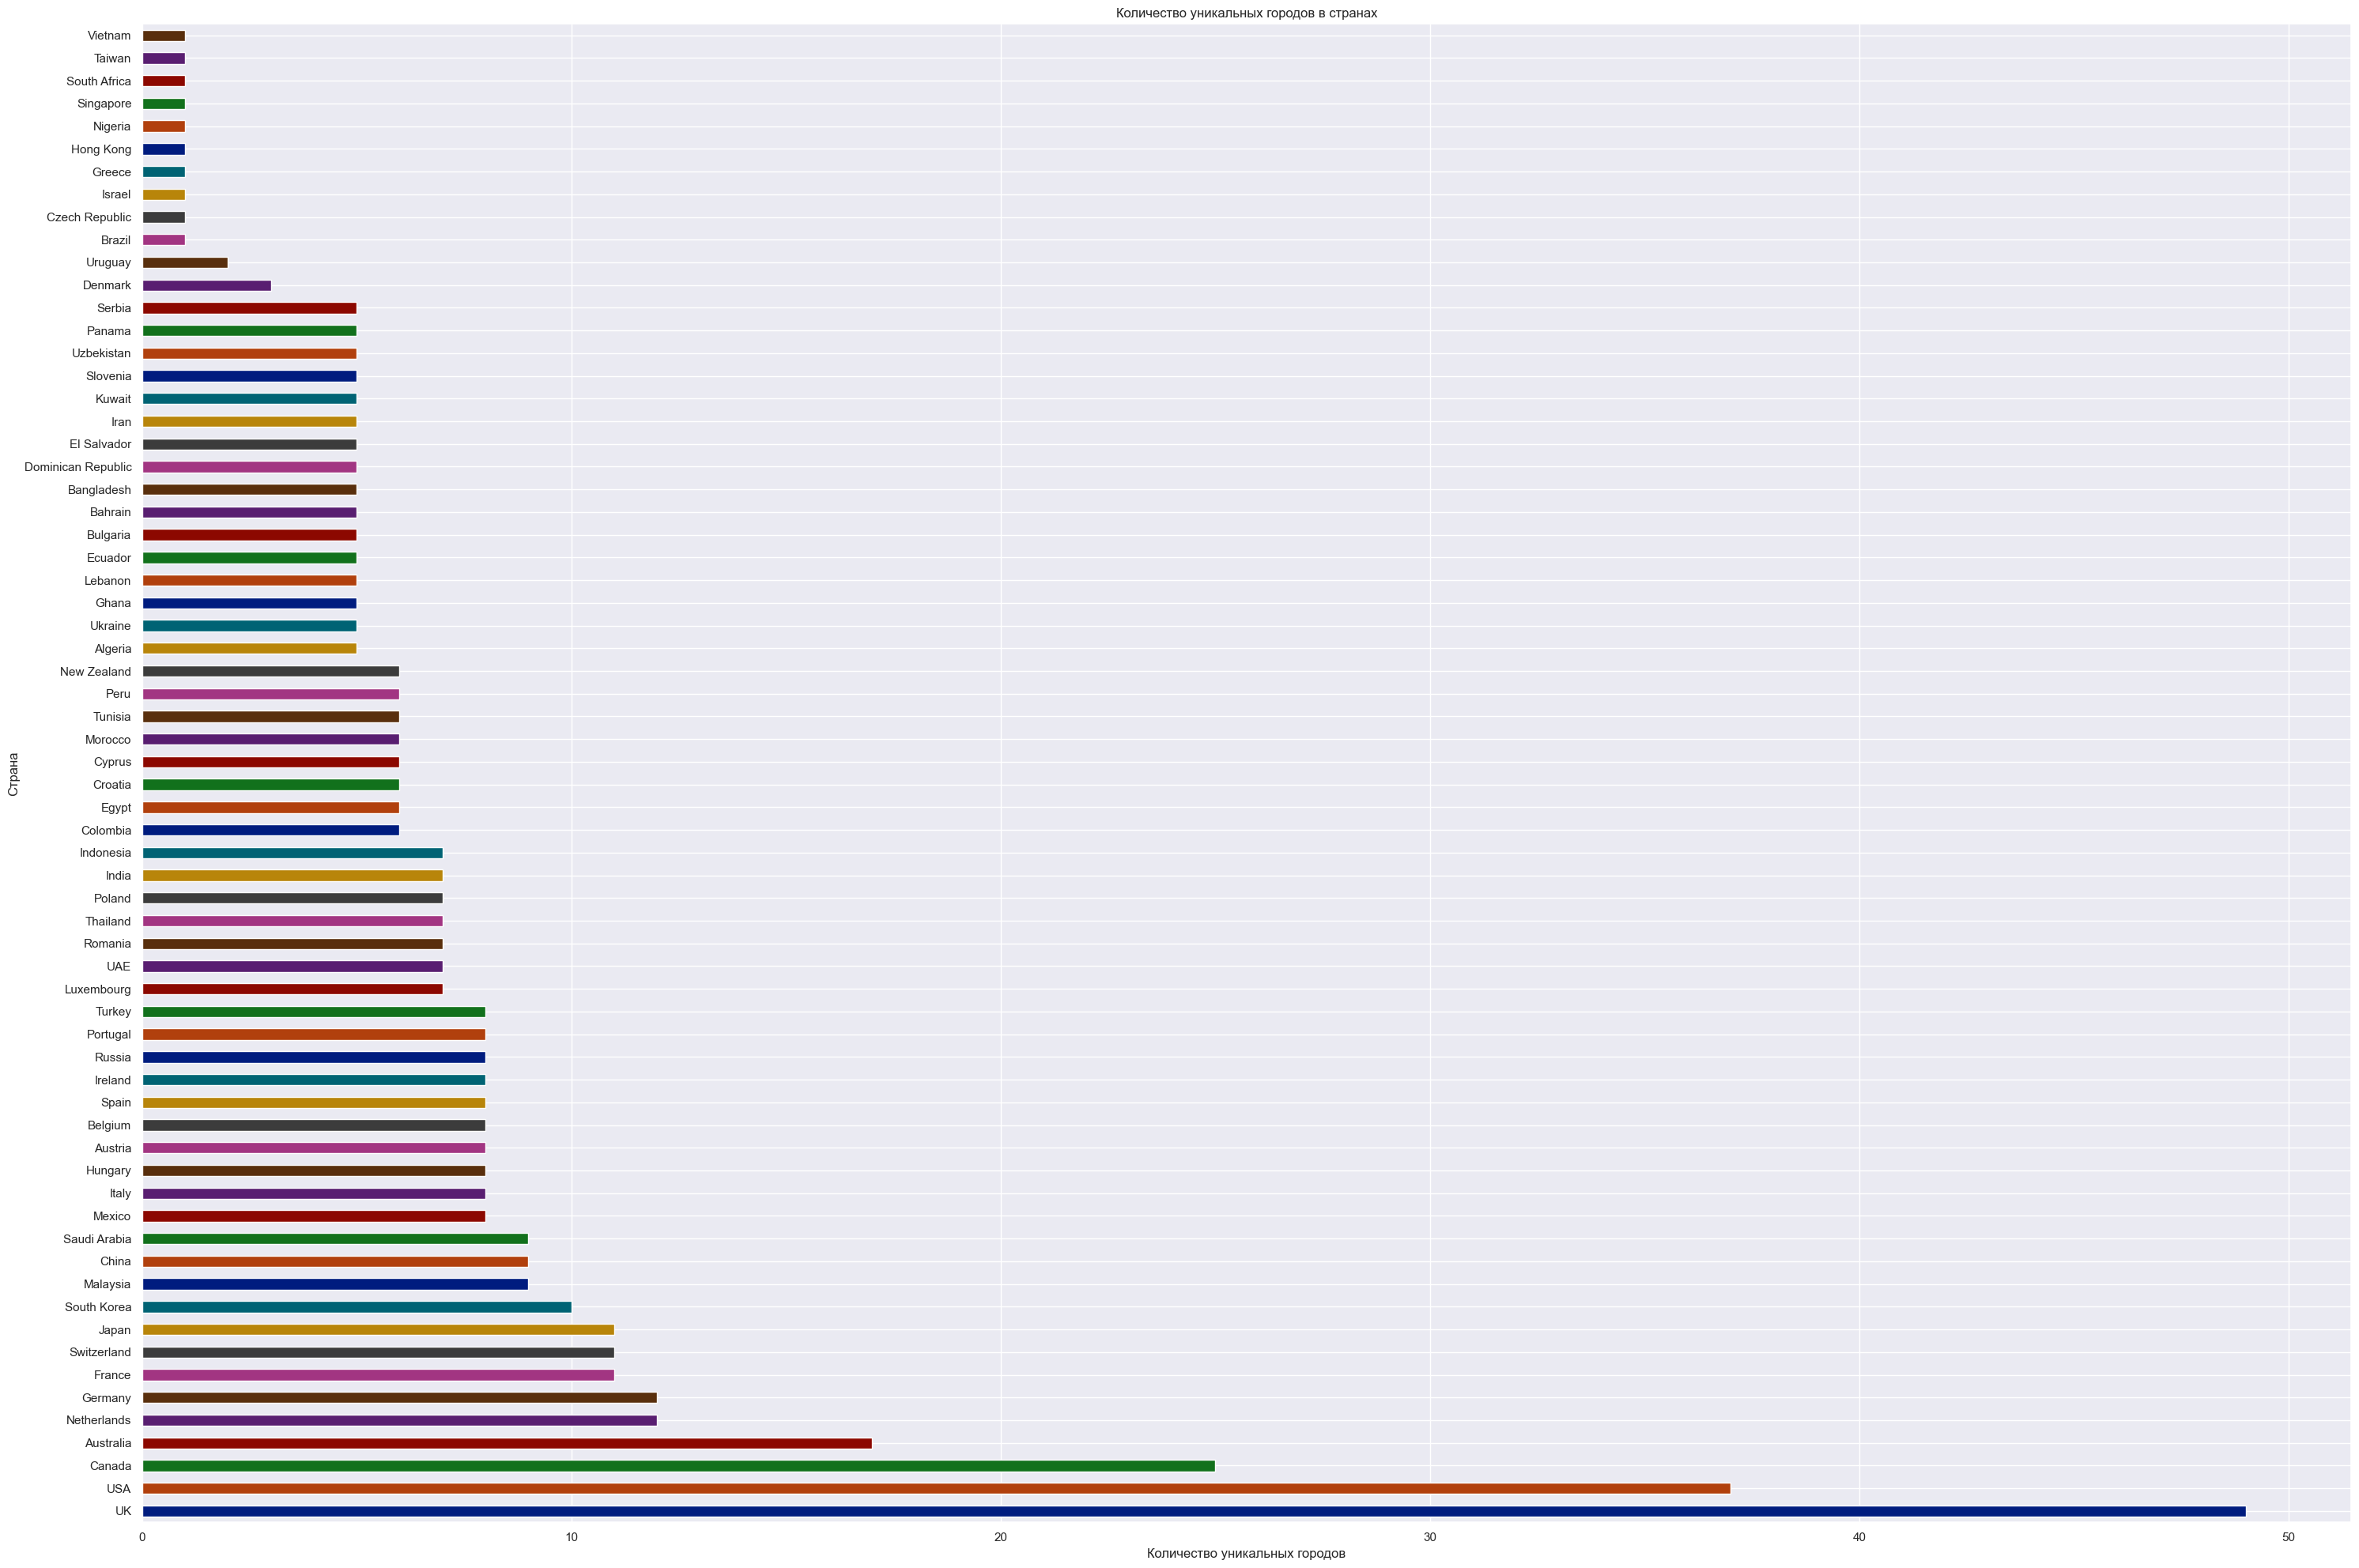

In [685]:
# Подсчитаем количество уникальных городов в каждой стране
country_unique_cities = data.groupby('Country')['City'].nunique()

# Сортируем страны по убыванию
sorted_countries = country_unique_cities.sort_values(ascending=False)

# Создаём Series с отсортированными странами
unique_cities_in_countries = country_unique_cities.loc[sorted_countries.index]

# Создаём палитру 'dark'
colors = sns.color_palette('dark', len(unique_cities_in_countries))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
unique_cities_in_countries.plot(kind='barh', color=colors, legend=False)
plt.title('Количество уникальных городов в странах')
plt.xlabel('Количество уникальных городов')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [686]:
# Посмотрим на точные значения
unique_cities_in_countries

Country
UK                    49
USA                   37
Canada                25
Australia             17
Netherlands           12
Germany               12
France                11
Switzerland           11
Japan                 11
South Korea           10
Malaysia               9
China                  9
Saudi Arabia           9
Mexico                 8
Italy                  8
Hungary                8
Austria                8
Belgium                8
Spain                  8
Ireland                8
Russia                 8
Portugal               8
Turkey                 8
Luxembourg             7
UAE                    7
Romania                7
Thailand               7
Poland                 7
India                  7
Indonesia              7
Colombia               6
Egypt                  6
Croatia                6
Cyprus                 6
Morocco                6
Tunisia                6
Peru                   6
New Zealand            6
Algeria                5
Ukraine          

**Выводы по графику**

1. `Великобритания и США` — абсолютные лидеры по универсальности направлений
Великобритания (49 городов) и США (37 городов) резко выделяются на фоне остальных стран, что отражает их развитую инфраструктуру, историческое влияние и привлекательность для бизнеса, туризма и образования.
Канада (25 городов) занимает третье место, демонстрируя высокую диверсификацию территорий.

2. `Европа и Азия доминируют в середине рейтинга` — страны ЕС (Германия, Франция, Нидерланды — по 8–12 городов) и развитые азиатские государства (Япония, Южная Корея — 10–11 городов) показывают сбалансированное распределение, подтверждая их статус глобальных узлов.
При этом Китай (9 городов) и Малайзия (9 городов) опережают многие европейские страны, что подчеркивает их растущую международную роль.

3. `Неожиданно низкие показатели у ключевых экономик`:

    * Сингапур (1 город), Гонконг (1 город) и Бразилия (1 город) имеют минимальное количество уникальных направлений, несмотря на их экономическую мощь. Это может быть связано с высокой концентрацией активности в столицах/мегаполисах.

    * Африканские страны (Нигерия, Гана, ЮАР — 1–5 городов) и Латинская Америка (кроме Мексики) представлены слабо, что указывает на региональную неравномерность развития.

#### Распределение количества уникальных университетов как универсальность направлений

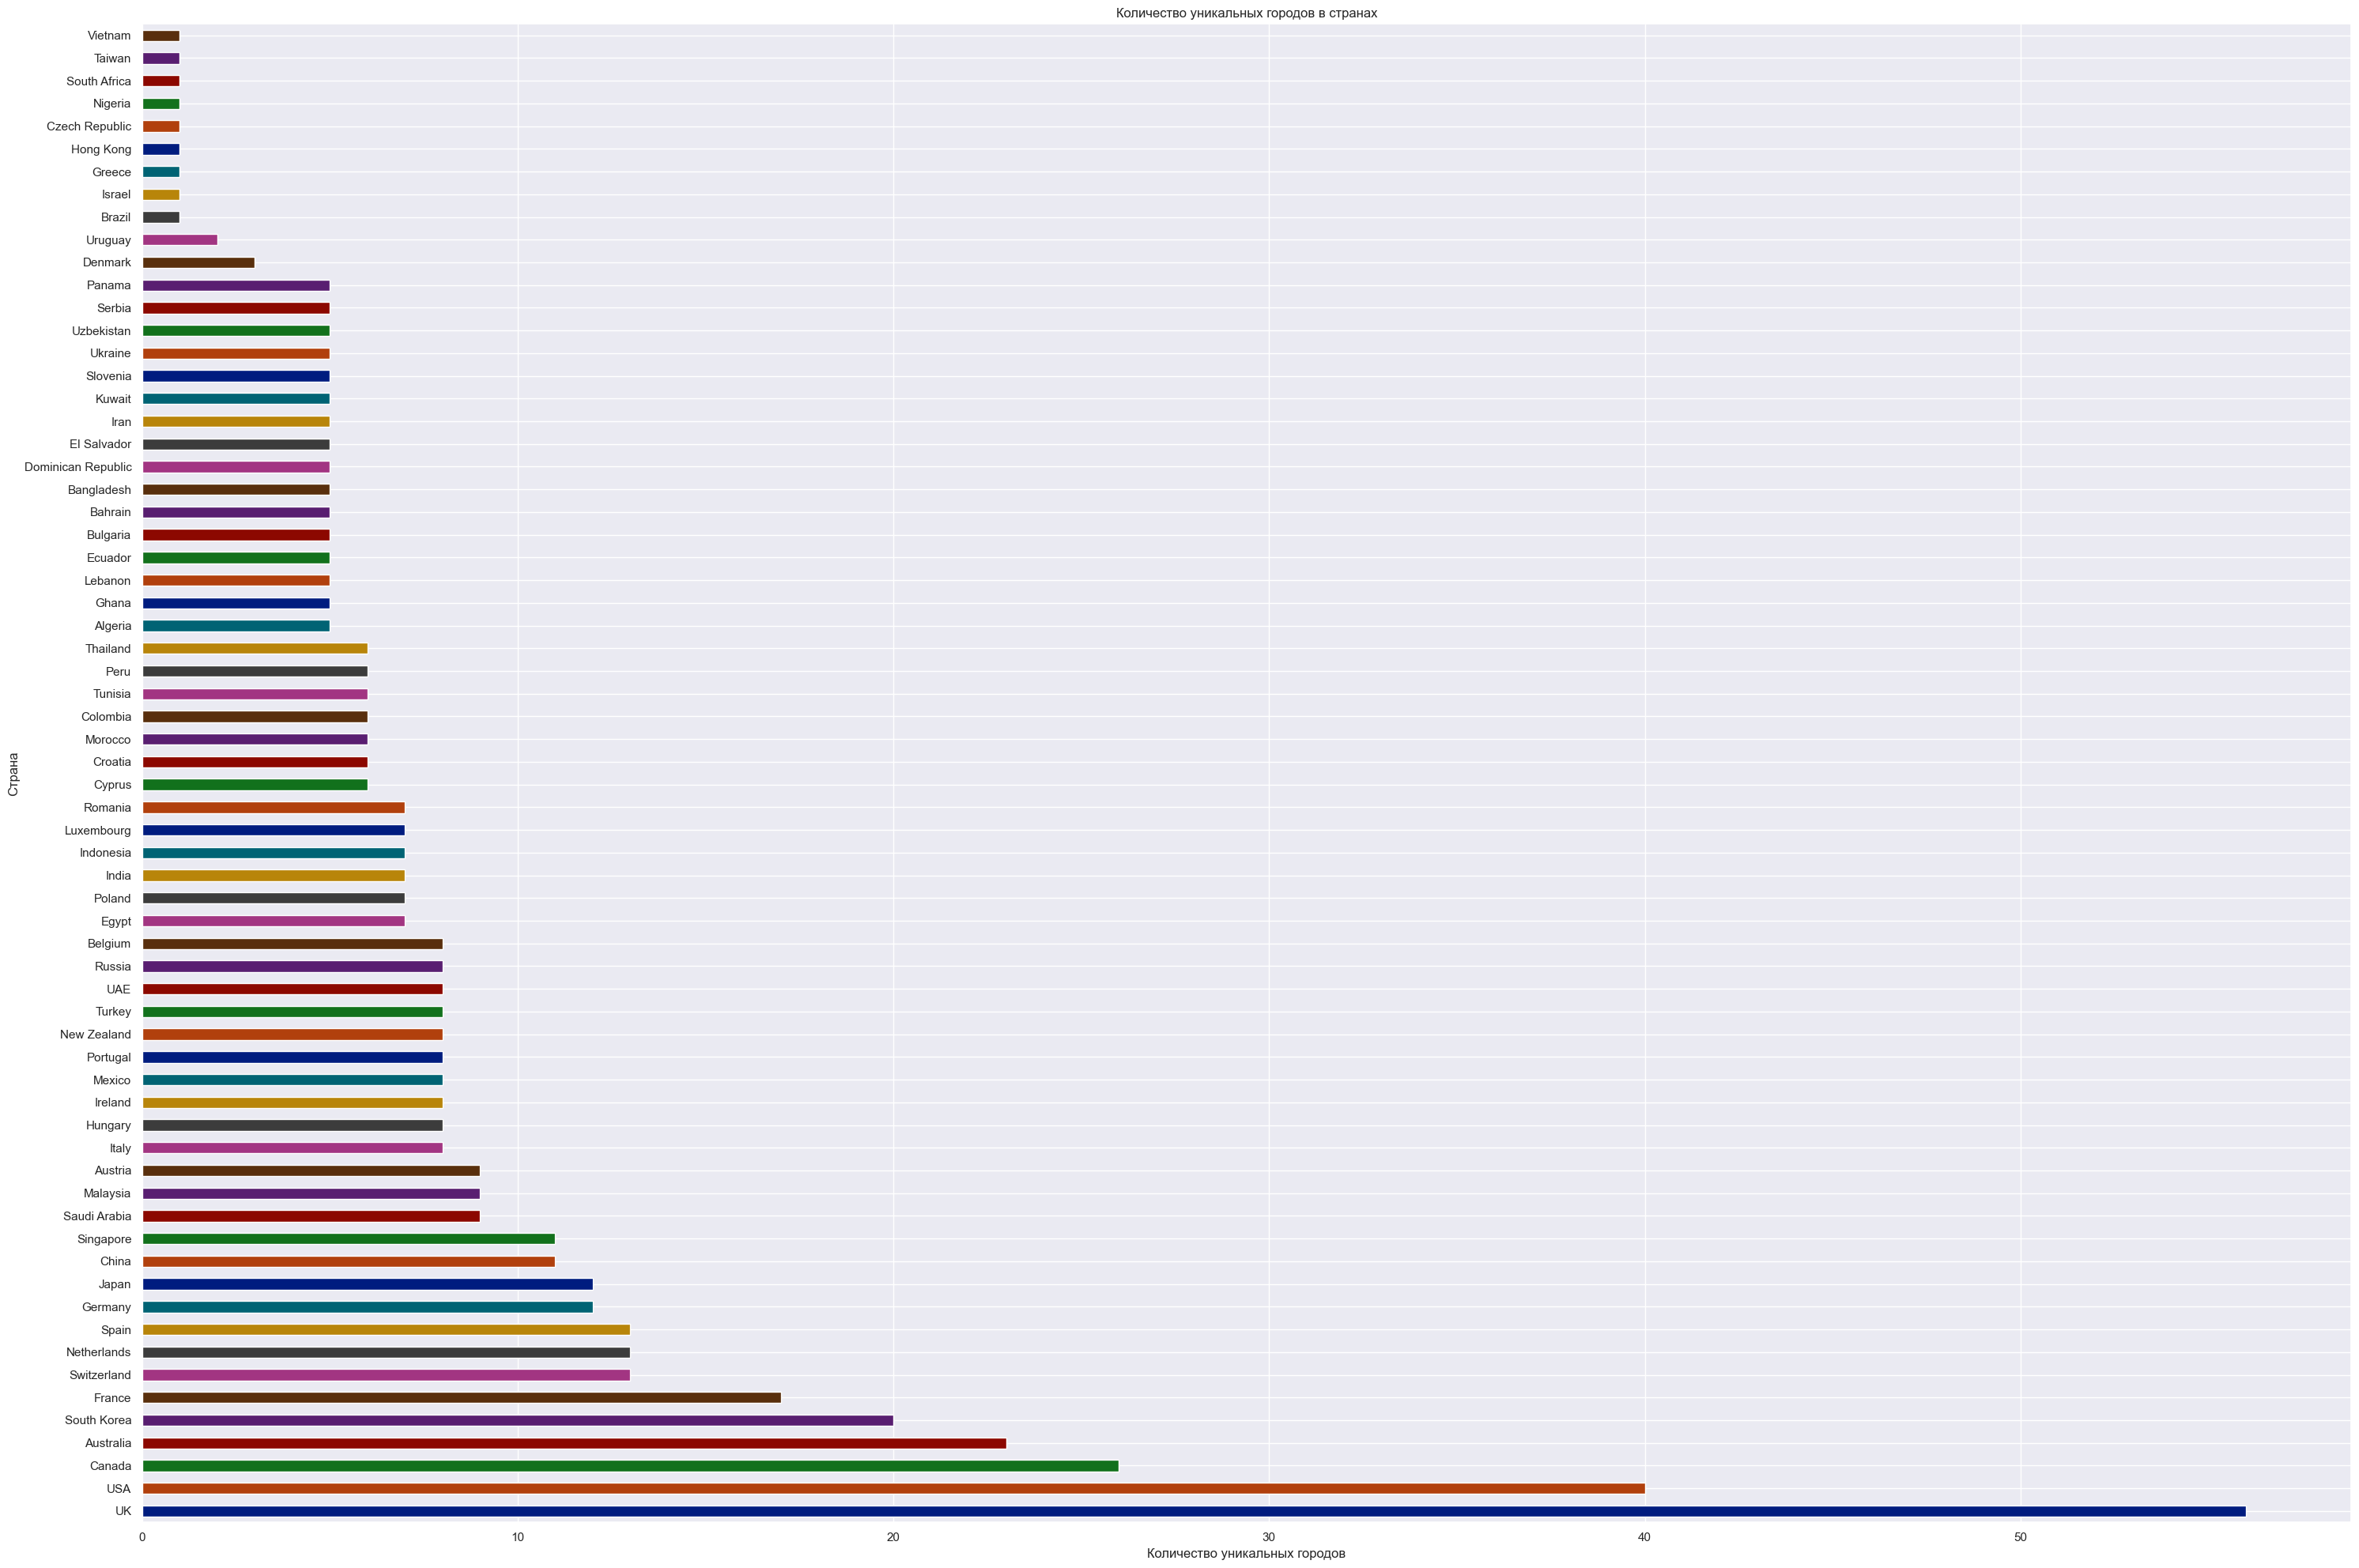

In [687]:
# Подсчитаем количество уникальных городов в каждой стране
country_unique_universities = data.groupby('Country')['University'].nunique()

# Сортируем страны по убыванию
sorted_countries = country_unique_universities.sort_values(ascending=False)

# Создаём Series с отсортированными странами
unique_universities_in_countries = country_unique_universities.loc[sorted_countries.index]

# Создаём палитру 'dark'
colors = sns.color_palette('dark', len(unique_universities_in_countries))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
unique_universities_in_countries.plot(kind='barh', color=colors, legend=False)
plt.title('Количество уникальных городов в странах')
plt.xlabel('Количество уникальных городов')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [688]:
# Посмотрим на точные значения
unique_universities_in_countries

Country
UK                    56
USA                   40
Canada                26
Australia             23
South Korea           20
France                17
Switzerland           13
Netherlands           13
Spain                 13
Germany               12
Japan                 12
China                 11
Singapore             11
Saudi Arabia           9
Malaysia               9
Austria                9
Italy                  8
Hungary                8
Ireland                8
Mexico                 8
Portugal               8
New Zealand            8
Turkey                 8
UAE                    8
Russia                 8
Belgium                8
Egypt                  7
Poland                 7
India                  7
Indonesia              7
Luxembourg             7
Romania                7
Cyprus                 6
Croatia                6
Morocco                6
Colombia               6
Tunisia                6
Peru                   6
Thailand               6
Algeria          

**Выводы по графику**

1. `Академическое лидерство англоязычных стран` — Великобритания (56 университетов) и США (40 университетов) с большим отрывом возглавляют рейтинг, подтверждая статус глобальных образовательных центров. Это связано с историческим влиянием, концентрацией топовых вузов (Оксфорд, Гарвард и др.) и активной интернационализацией высшего образования.
Канада (26) и Австралия (23) также входят в топ-4, что делает англоязычные страны наиболее привлекательными для иностранных студентов.

2. `Активная роль Азии и континентальной Европы`:

    * Южная Корея (20 университетов) и Китай (11) демонстрируют быстрый рост академического присутствия, инвестируя в международные рейтинги и исследовательские программы.

    * Франция (17), Швейцария (13) и Нидерланды (13) лидируют в Европе, предлагая качественное образование на английском языке, особенно в области STEM и бизнеса.

3. `Несоответствие экономического и академического влияния у некоторых стран`:

    * Сингапур (11 университетов) и ОАЭ (8) выделяются на фоне других малых стран, делая ставку на образование как часть стратегии развития.

    * При этом Бразилия (1), ЮАР (1) и Нигерия (1) имеют минимальное представительство, несмотря на крупные экономики и население. Это указывает на слабую интеграцию их вузов в глобальную систему высшего образования.

#### Распределение количества уникальных программ как универсальность направлений

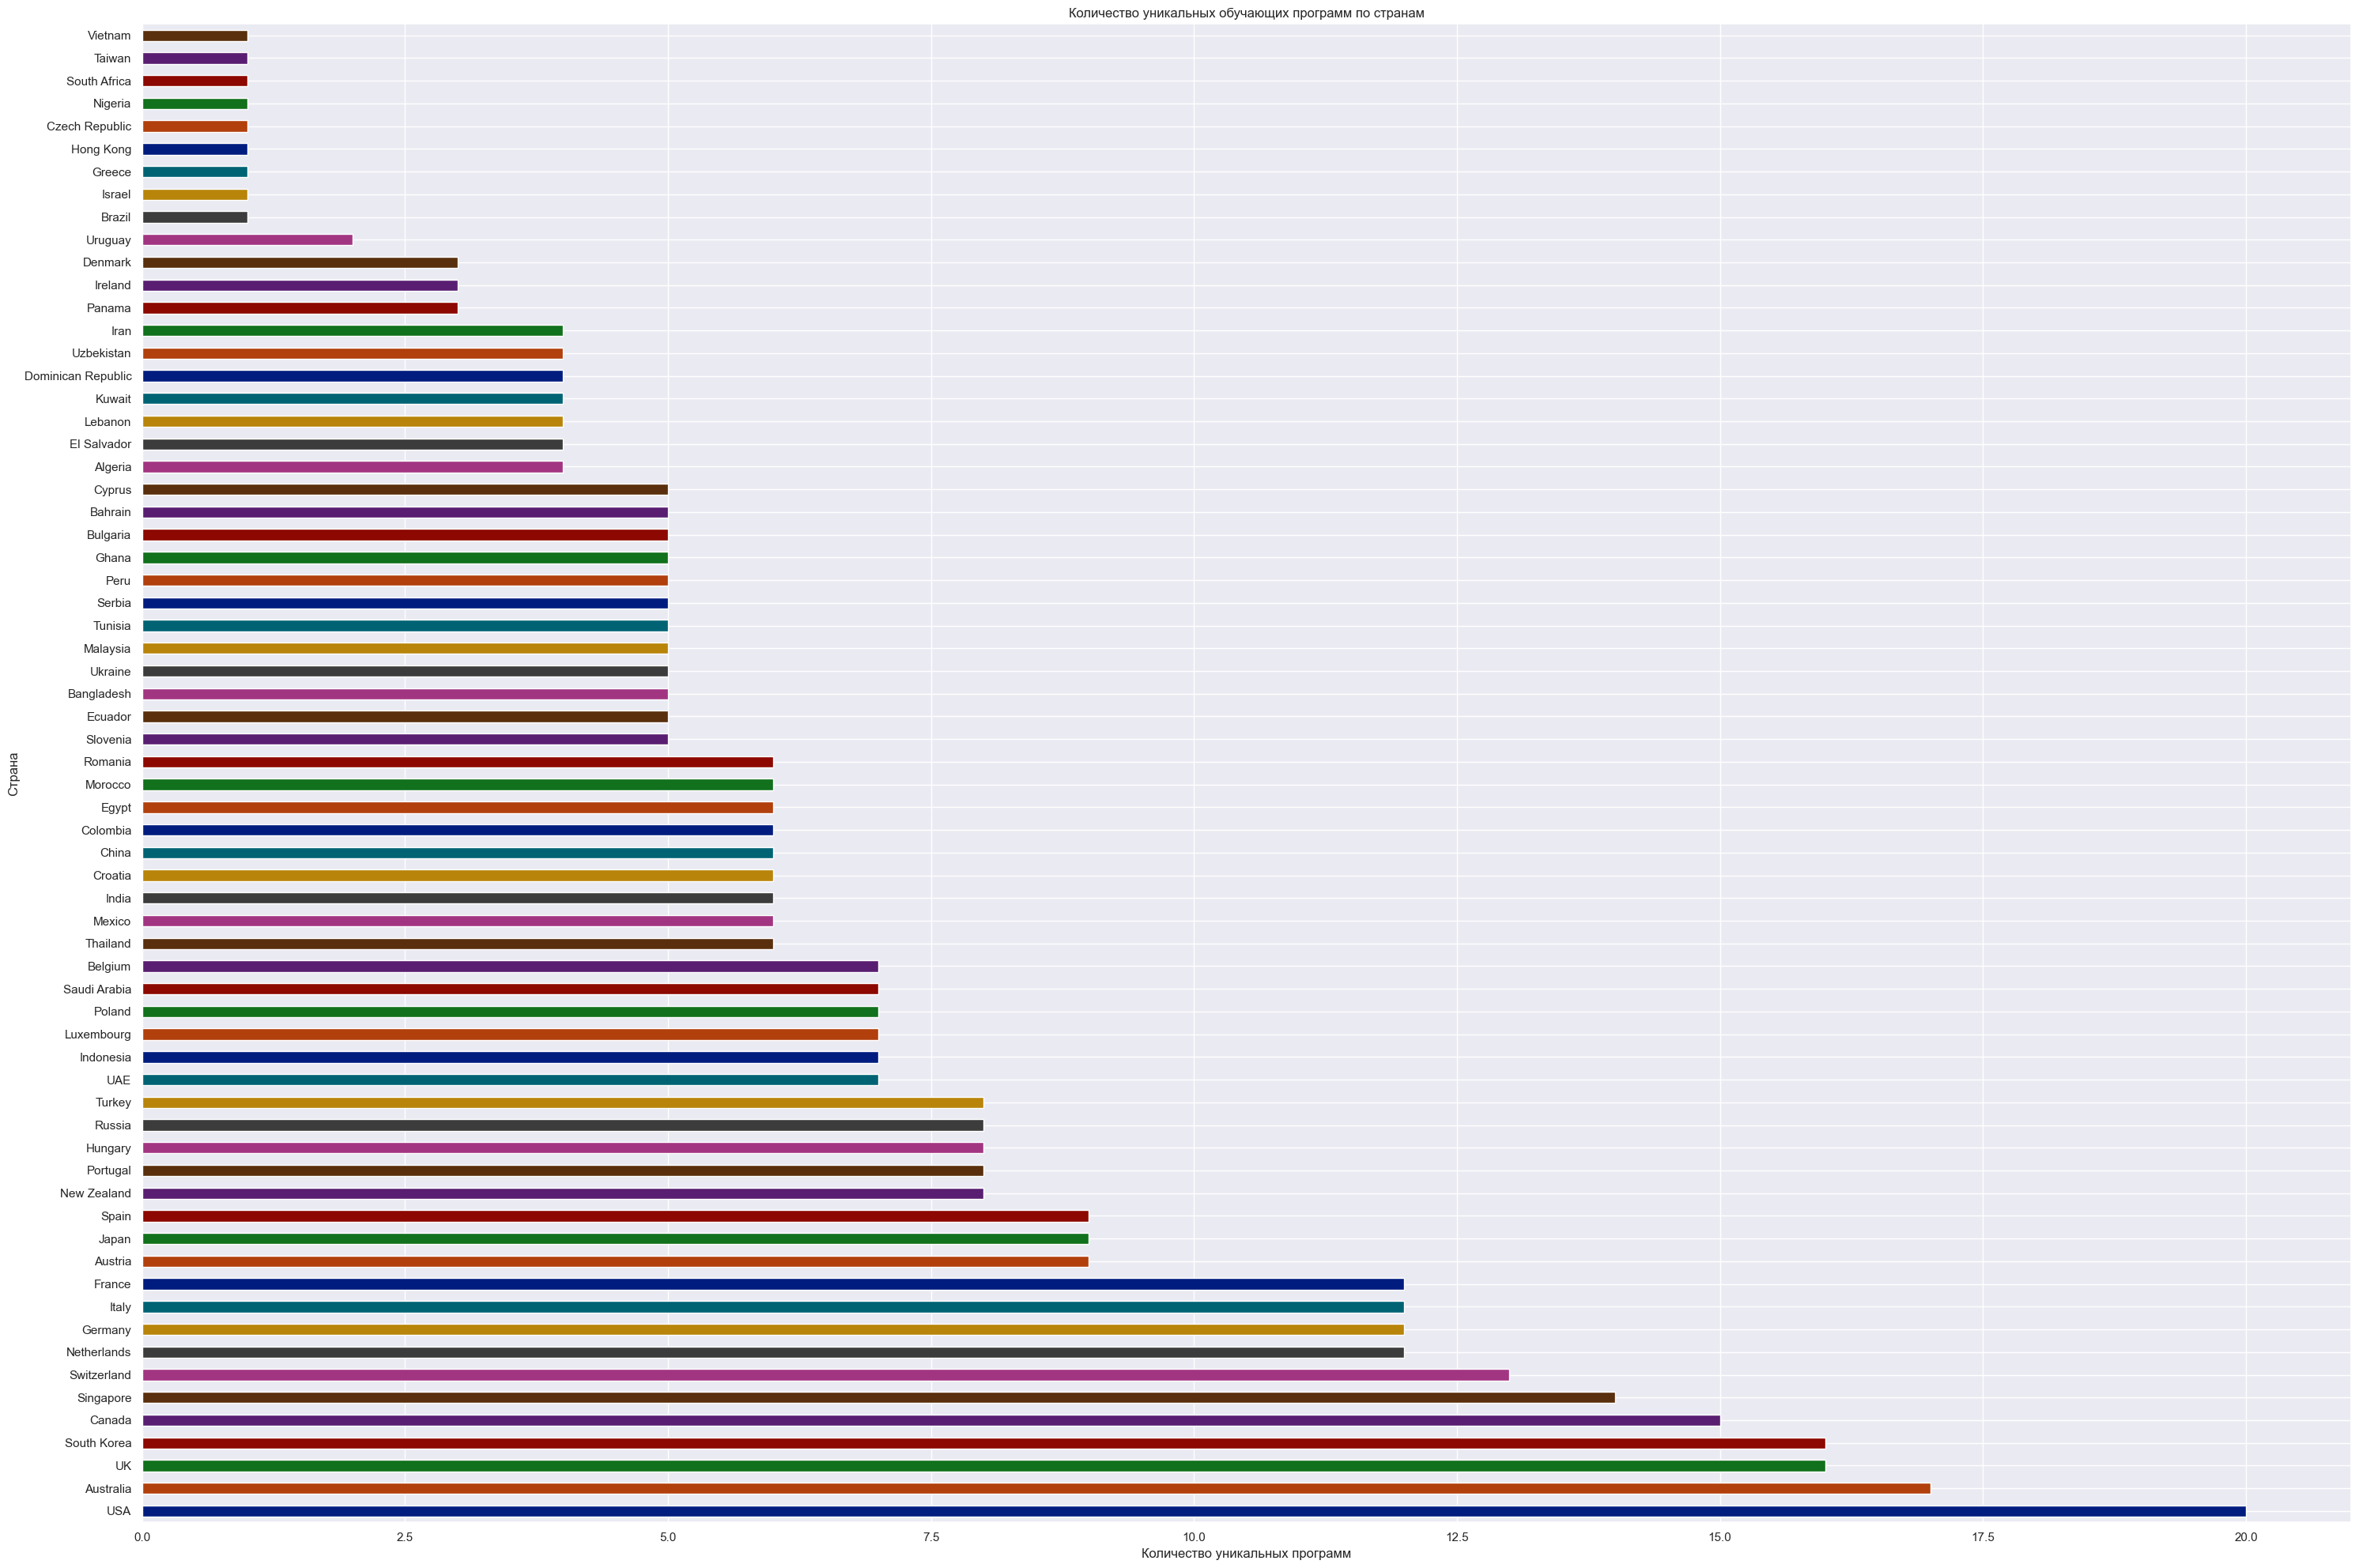

In [689]:
# Подсчитаем количество уникальных программ в каждой стране
country_unique_program_counts = data.groupby('Country')['Program'].nunique()

# Сортируем страны по убыванию
sorted_countries = country_unique_program_counts.sort_values(ascending=False)

# Создаём Series с отсортированными странами
unique_program_counts_by_country = country_unique_program_counts.loc[sorted_countries.index]

# Создаём палитру 'dark'
colors = sns.color_palette('dark', len(unique_program_counts_by_country))

# Визуализируем распределение
plt.figure(figsize=(30, 20))
ax = unique_program_counts_by_country.plot(kind='barh', color=colors, legend=False)
plt.title('Количество уникальных обучающих программ по странам')
plt.xlabel('Количество уникальных программ')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [690]:
# Посмотрим на точные значения
unique_program_counts_by_country

Country
USA                   20
Australia             17
UK                    16
South Korea           16
Canada                15
Singapore             14
Switzerland           13
Netherlands           12
Germany               12
Italy                 12
France                12
Austria                9
Japan                  9
Spain                  9
New Zealand            8
Portugal               8
Hungary                8
Russia                 8
Turkey                 8
UAE                    7
Indonesia              7
Luxembourg             7
Poland                 7
Saudi Arabia           7
Belgium                7
Thailand               6
Mexico                 6
India                  6
Croatia                6
China                  6
Colombia               6
Egypt                  6
Morocco                6
Romania                6
Slovenia               5
Ecuador                5
Bangladesh             5
Ukraine                5
Malaysia               5
Tunisia          

**Выводы по графику**

1. `Доминирование США и англоязычных стран в образовательных программах` — США (20 программ) лидируют с заметным отрывом, подчеркивая их роль как мирового центра высшего образования и исследовательских возможностей.
Австралия (17), Великобритания (16) и Канада (15) также входят в топ-5, что подтверждает глобальную привлекательность англоязычных образовательных систем.

2. `Активное участие азиатских и европейских стран`:

    * Южная Корея (16) и Сингапур (14) демонстрируют сильные позиции, сопоставимые с ведущими европейскими странами, благодаря инвестициям в международное образование.

    * Германия (12), Франция (12) и Италия (12) представляют Европу, предлагая разнообразные программы, особенно в технических и гуманитарных областях.

3. `Ограниченное предложение программ в развивающихся странах`:

    * Крупные экономики, такие как Бразилия (1), Нигерия (1) и ЮАР (1), имеют минимальное количество программ, что может отражать недостаточную интеграцию их вузов в глобальные образовательные сети.

    * Китай (6) и Россия (8) показывают средние результаты, несмотря на масштабы их высшего образования, что говорит о сохраняющихся барьерах для международного признания.

#### Распределение количества уровней образования как универсальности направлений

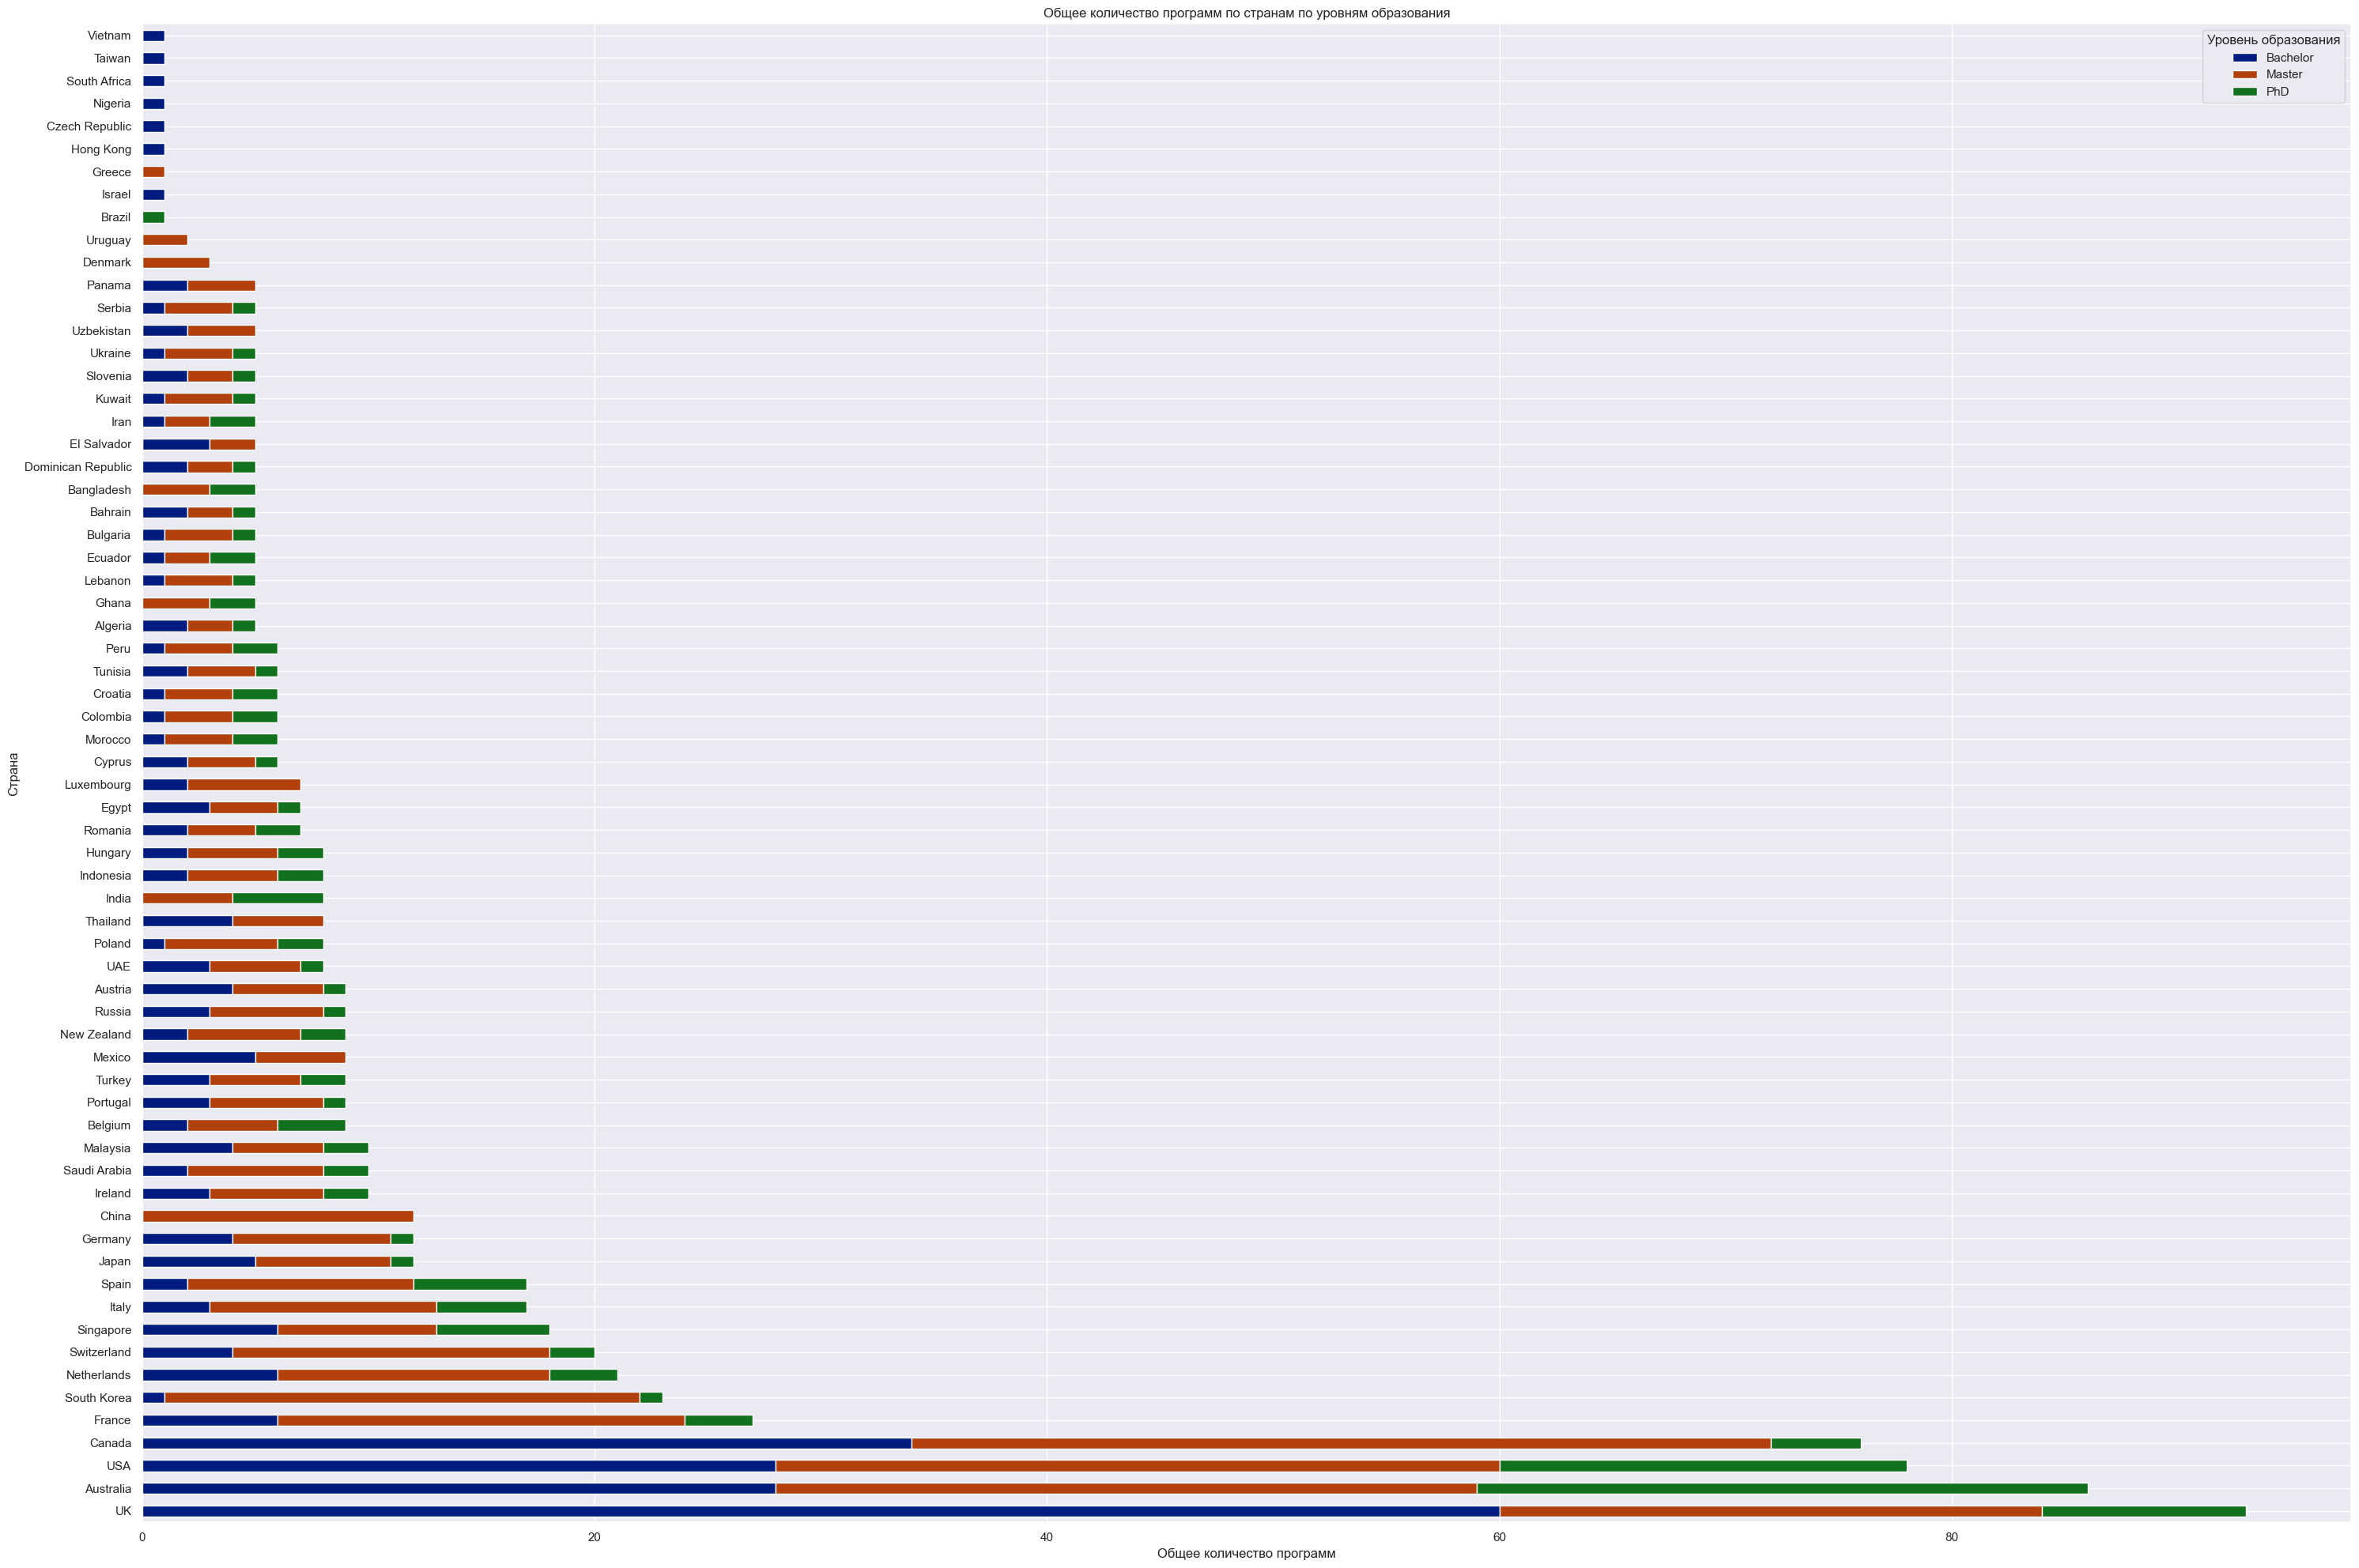

In [691]:
# Сгруппируем данные по странам и уровням образования, подсчитаем количество программ
grouped = data.groupby(['Country', 'Level'])['Program'].count().reset_index()

# Создадим сводную таблицу для дальнейшего удобства
pivot_table = grouped.pivot(index='Country', columns='Level', values='Program').fillna(0)

# Сортируем страны по общему количеству программ, по убыванию
pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values('Total', ascending=False)

# Зададим цветовую палитру 'dark' для уровней
levels = pivot_table.columns[:-1]  # не включая 'Total'
colors = sns.color_palette('dark', len(levels))

# Визуализируем распределение
pivot_table[levels].plot(
    kind='barh',
    stacked=True,
    figsize=(30, 20),
    color=colors
)
plt.title('Общее количество программ по странам по уровням образования')
plt.xlabel('Общее количество программ')
plt.ylabel('Страна')
plt.legend(title='Уровень образования')
plt.tight_layout()
plt.show()

In [692]:
# Посмотрим на получившуюся сводную таблицу
pivot_table

Level,Bachelor,Master,PhD,Total
Country,,,,
UK,60.0,24.0,9.0,93.0
Australia,28.0,31.0,27.0,86.0
USA,28.0,32.0,18.0,78.0
Canada,34.0,38.0,4.0,76.0
France,6.0,18.0,3.0,27.0
South Korea,1.0,21.0,1.0,23.0
Netherlands,6.0,12.0,3.0,21.0
Switzerland,4.0,14.0,2.0,20.0
Singapore,6.0,7.0,5.0,18.0


**Выводы по графику**

1. `Абсолютное лидерство англоязычных стран в многоуровневом образовании` — Великобритания (93 программы), Австралия (86) и США (78) доминируют по общему количеству программ на всех уровнях (бакалавриат, магистратура, PhD):

    * Особенно выделяется Великобритания с рекордным числом бакалаврских программ (60), что подтверждает её статус мирового центра undergraduate-образования.

    * Австралия демонстрирует сбалансированность: 28 (бакалавриат) vs. 31 (магистратура) vs. 27 (PhD), делая её привлекательной для студентов всех ступеней.

2. `Разные стратегии стран в развитии образовательных уровней`:

    * Канада (76 программ) делает ставку на бакалавриат (34) и магистратуру (38), но почти не представлена на PhD-уровне (4).

    * Китай (12 программ) и Индия (8) фокусируются исключительно на магистратуре и PhD, что отражает их ориентацию на подготовку высококвалифицированных специалистов.

    * Южная Корея (23) и Франция (27) уделяют особое внимание магистратуре (21 и 18 программ соответственно), минимизируя бакалавриат.

3. `Ограниченные возможности для PhD в развивающихся странах`:

    * Подавляющее большинство стран предлагает 1–2 PhD-программы, а Бразилия, Греция, Уругвай и другие имеют лишь 0–1 программу.

    * Исключение — Австралия (27 PhD) и Великобритания (9 PhD), что подчёркивает их роль в глобальной исследовательской системе.

    * Нигерия, ЮАР, Вьетнам и другие представлены только на уровне бакалавриата (1 программа), что указывает на слабую интеграцию в мировую академическую среду.

### Общая описательная статистика и распределения

#### Распределение стоимости обучения по программам и уровням образования

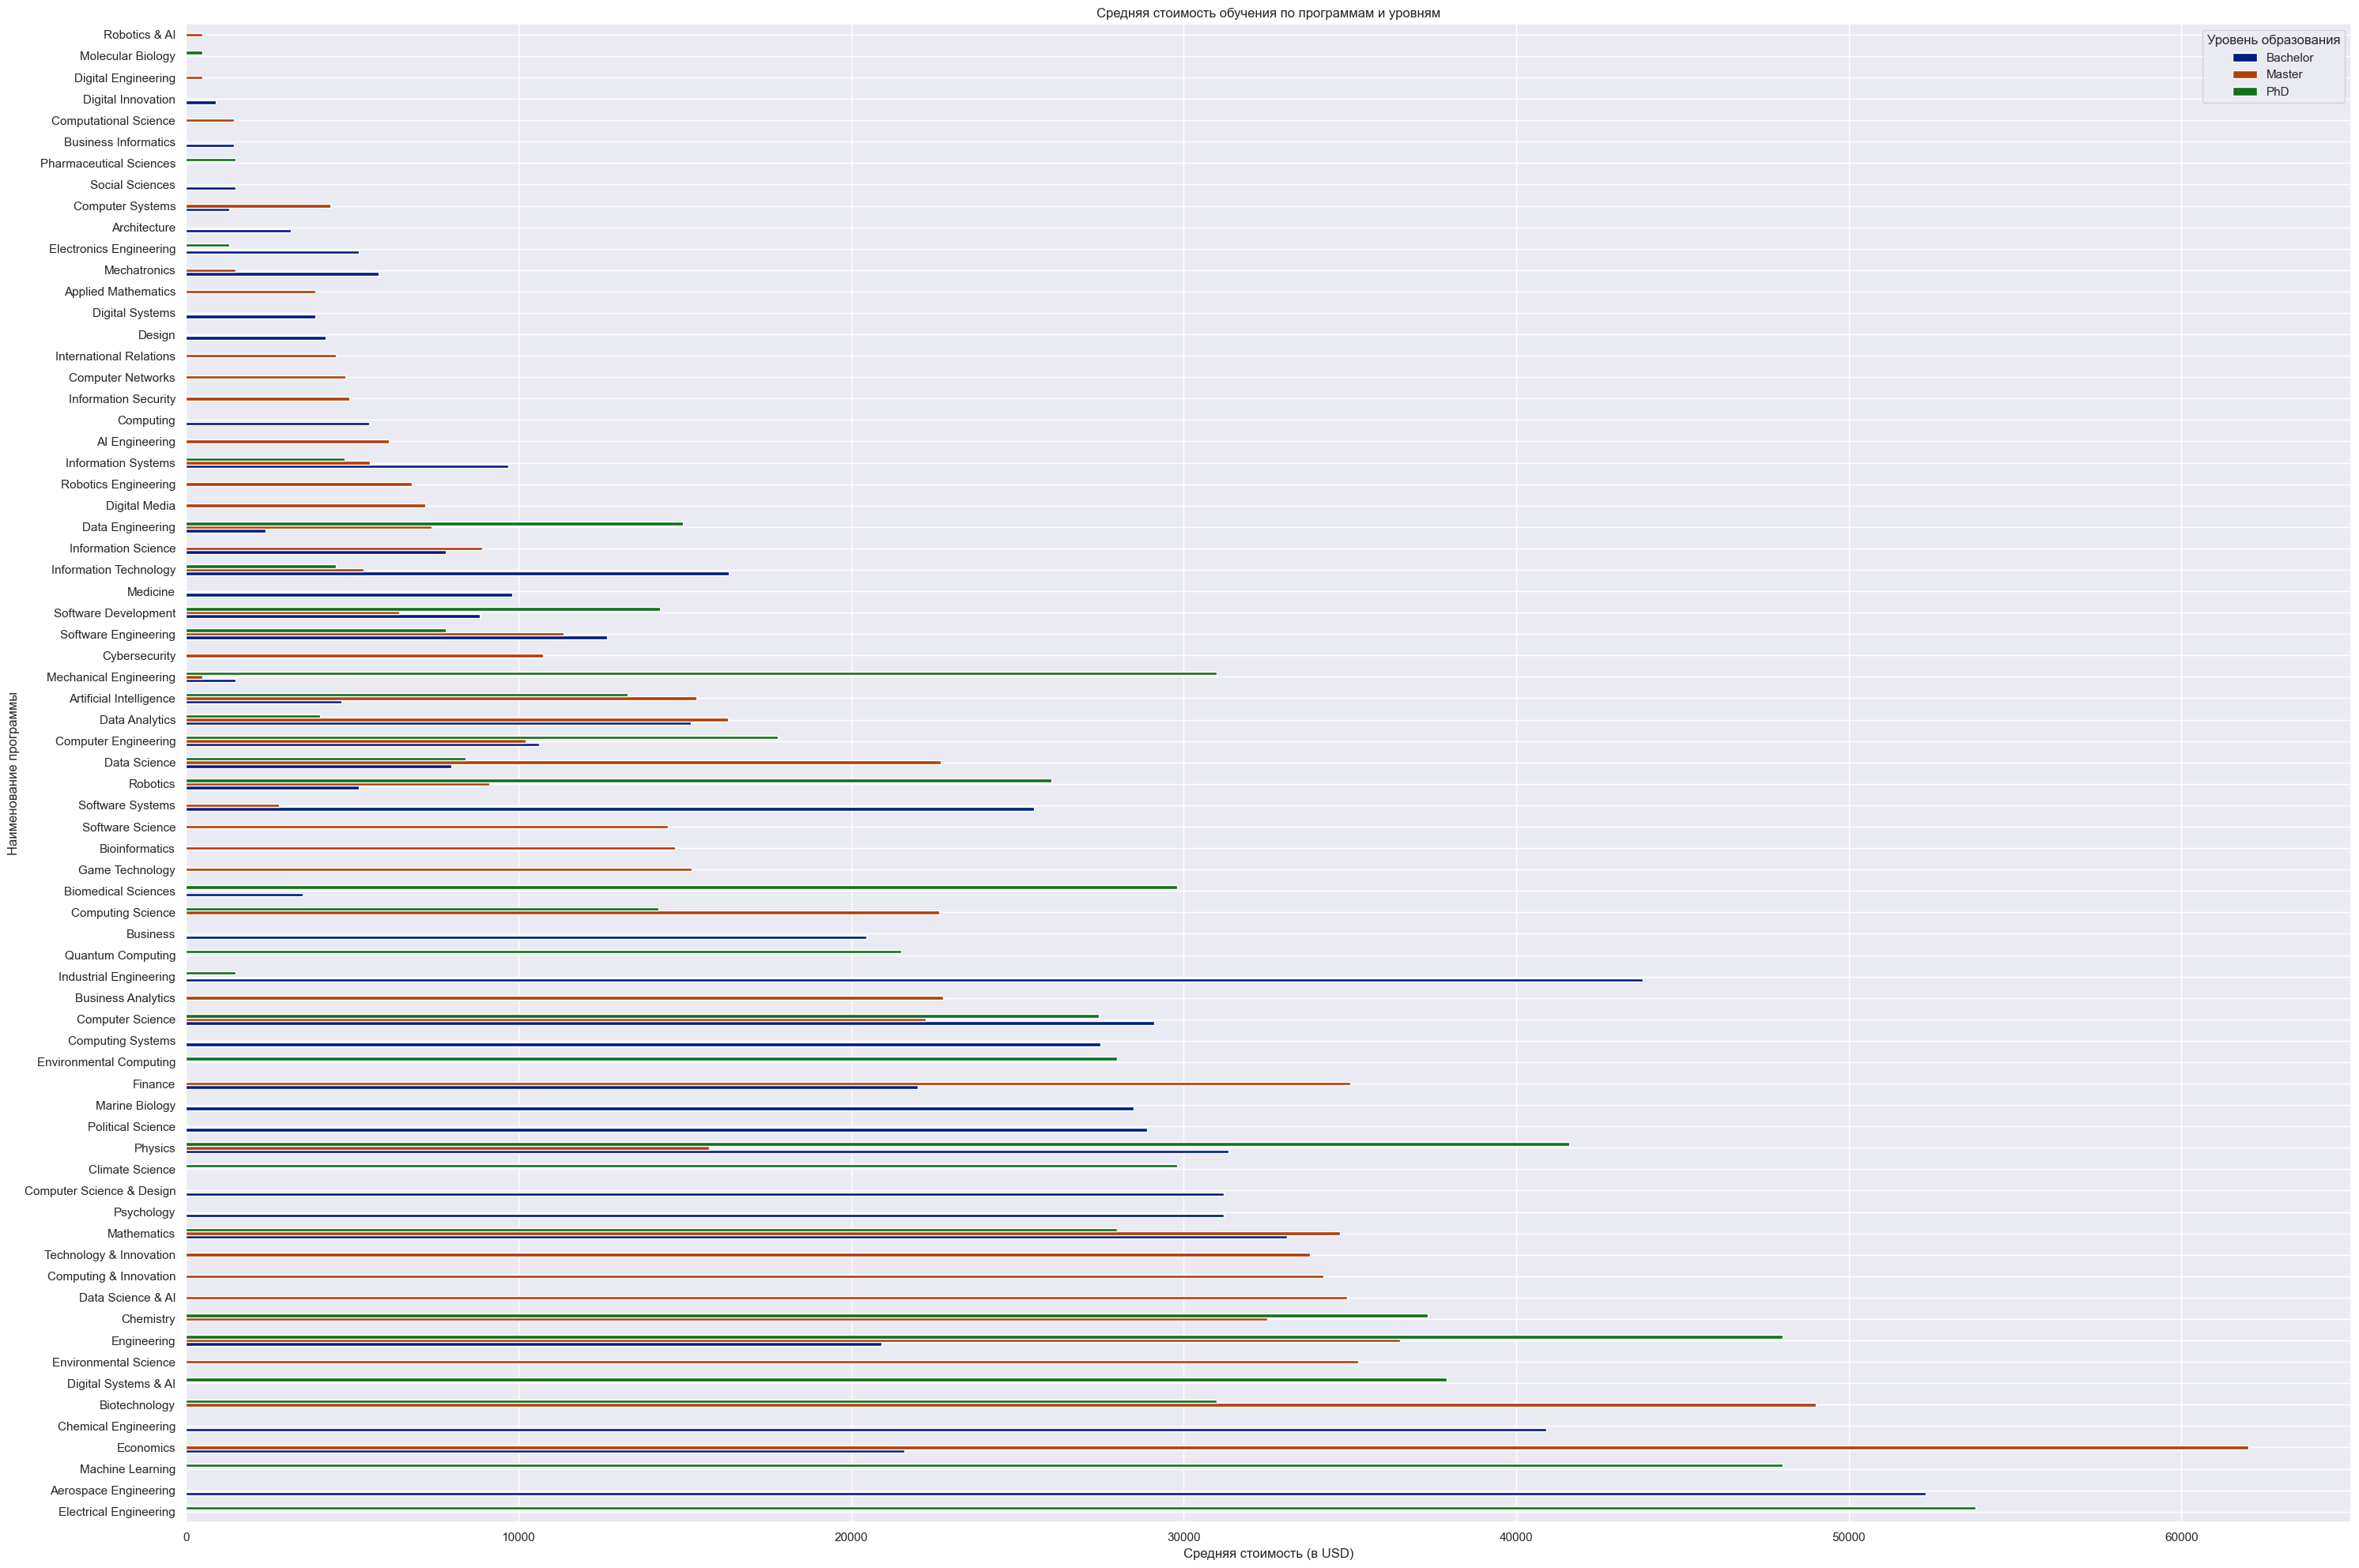

In [693]:
# Подсчитаем среднюю стоимость обучения по программам и уровням образования
avg_tuition = data.groupby(['Program', 'Level'])['Tuition_USD'].mean().unstack()

# Отсортируем программы по средней стоимости обучения (средней по обоим уровням)
avg_tuition['Mean'] = avg_tuition.mean(axis=1)
avg_tuition_sorted = avg_tuition.sort_values(by='Mean', ascending=False)

# Удаляем вспомогательный столбец — он нам больше не нужен
avg_tuition_sorted = avg_tuition_sorted.drop(columns='Mean').fillna(0)

# Визуализируем распределение
avg_tuition_sorted.plot(kind='barh', figsize=(30, 20))
plt.title('Средняя стоимость обучения по программам и уровням')
plt.xlabel('Средняя стоимость (в USD)')
plt.ylabel('Наименование программы')
plt.legend(title='Уровень образования')
plt.tight_layout()
plt.show()

In [694]:
# Посмотрим на статистическую характеристику получившегося распределения
avg_tuition_sorted.describe().round()

Level,Bachelor,Master,PhD
count,70.0,70.0,70.0
mean,9105.0,9925.0,8971.0
std,12981.0,13885.0,14698.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,1950.0,4425.0,0.0
75%,14557.0,15075.0,14245.0
max,52300.0,62000.0,53800.0


**Выводы по графику**

1. `Магистратура — самый дорогой уровень образования`:

    * Средняя стоимость обучения на магистратуре ($9.925) выше, чем на бакалавриате ($9.105) и PhD ($8.971).

    * Максимальная цена также приходится на магистратуру ($62.000), что может быть связано с премиальными программами (MBA, Executive Education) в топовых вузах.

    * PhD в среднем дешевле, но разброс цен огромен (от $0 до $53.800), так как многие аспирантуры финансируются за счёт грантов или стипендий.

2. `Половина программ PhD бесплатны или сильно субсидированы`:

* Медианная стоимость PhD ($0) указывает, что 50% программ не требуют оплаты от студента (например, в Европе с государственным финансированием или в США при наличии teaching/research assistantships).

  Для сравнения:

  * Бакалавриат: медиана $1.950 (бесплатных программ меньше).
  
  * Магистратура: медиана $4.425 (платных программ больше).

3. `Экстремальный разброс цен по всем уровням`:

* Стандартное отклонение высокое для всех уровней (~$13.000–$14.700), что означает:

    * Есть очень дорогие программы (например, бакалавриат в US/UK до $52.300).

    * Есть полностью бесплатные (особенно в странах с бесплатным высшим образованием: Германия, Норвегия для EU-студентов).

* 75-й перцентиль показывает, что 25% самых дорогих программ стоят:

  * Бакалавриат: от $14.557.

  * Магистратура: от $15.075.

  * PhD: от $14.245.

#### Распределение средних затрат в год по странам и уровням образования

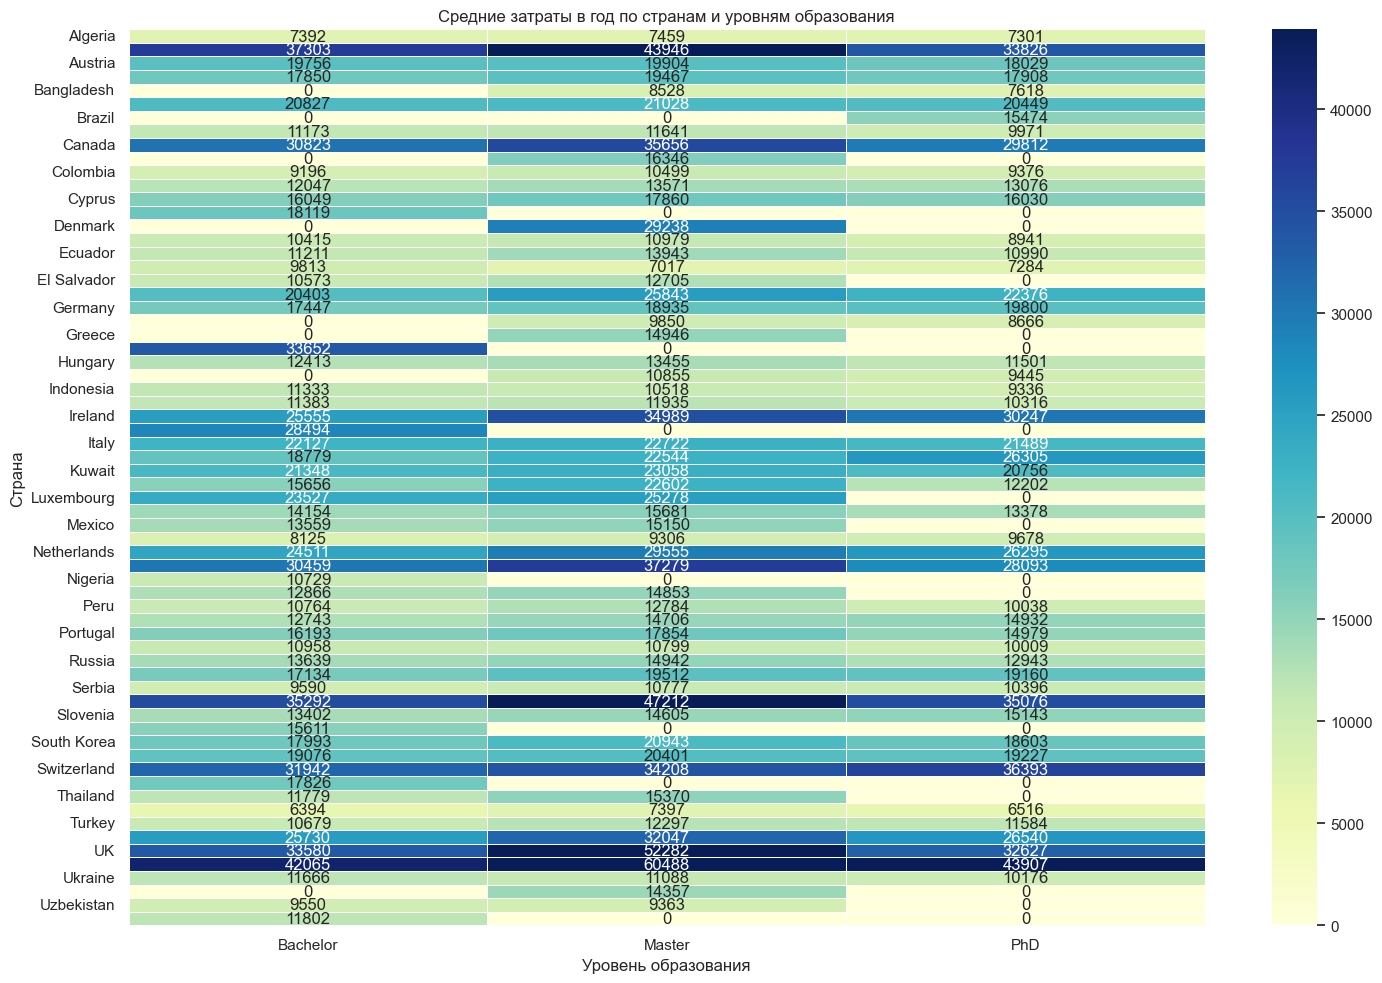

In [695]:
# Для удобства визуализации создадим сводную таблицу средней оценочной суммы затрат
pivot_table = data.pivot_table(
    values='Estimated_Annual_Cost',
    index='Country',
    columns='Level',
    aggfunc='mean'
).fillna(0)

# Визуализируем распределение
plt.figure(figsize=(15, 10))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    cbar=True,
    linecolor='white',
    linewidths=0.5,
    robust=True
)
plt.title('Средние затраты в год по странам и уровням образования')
plt.xlabel('Уровень образования')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

In [696]:
# Посмотрим на получившуюся сводную таблицу
pivot_table

Level,Bachelor,Master,PhD
Country,,,
Algeria,7392.000000,7459.000000,7301.000000
Australia,37303.321429,43946.387097,33826.000000
Austria,19755.500000,19904.000000,18029.000000
Bahrain,17849.500000,19467.000000,17908.000000
Bangladesh,0.000000,8528.000000,7618.500000
Belgium,20827.000000,21027.500000,20449.000000
Brazil,0.000000,0.000000,15474.000000
Bulgaria,11173.000000,11641.333333,9971.000000
Canada,30822.676471,35655.947368,29812.500000


**Выводы по графику**

1. `США и Великобритания — самые дорогие для обучения, особенно на магистратуре`:

    * Магистратура в США ($60.488) и Великобритании ($52.281) дороже, чем в других странах, что связано с престижем вузов (например, Ivy League, Оксбридж) и высокими административными расходами.

    * PhD в США ($43.907) также самый затратный, но многие студенты получают финансирование через стипендии или ассистентуры.

    * Сингапур выделяется высокой стоимостью магистратуры ($47.212), опережая даже Швейцарию ($34.207).

2. `Бесплатное или условно-бесплатное образование в отдельных странах`:

    * Германия, Франция, Австрия, Норвегия (не в списке) предлагают низкую или нулевую стоимость обучения для бакалавров и магистров (особенно для локальных и EU-студентов). Например:

      * Бакалавриат в Германии: ~$1.700–3.500 в год (госвузы).

      * PhD в Дании: $0 (но в данных указано $0 только для магистратуры).

    * Бразилия, Греция, Бангладеш имеют бесплатные программы на некоторых уровнях (например, магистратура в Бангладеш — $8.528).

3. `Развивающиеся страны дешевле, но с ограниченным выбором`:

    * Самые низкие цены:

        * Тунис ($6.394–7.396), Алжир (~$7.300), Украина (~$10.000–11.600).

        * Индия ($9.445–10.855) и Индонезия ($9.336–11.333) предлагают недорогие PhD.

    * Проблема доступности:

        * Многие страны (Нигерия, ЮАР, Вьетнам) имеют данные только для одного уровня, что ограничивает выбор.

        * PhD в развивающихся странах часто дешевле ($7.000–15.000), но качество и финансирование могут уступать.

#### Географическое распределение предполагаемых затрат в год

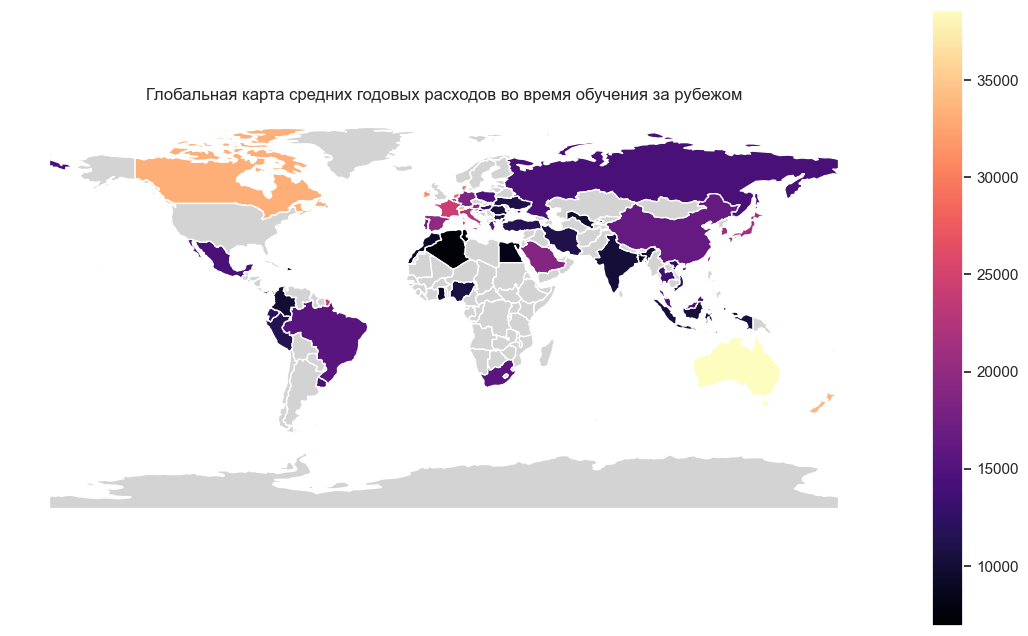

In [697]:
# Загружаем файл с границами стран
world_map = gpd.read_file('data/world_map/ne_110m_admin_0_countries.shp')

# Рассчитываем средние затраты в год по странам
country_cost = data.groupby('Country')['Estimated_Annual_Cost'].mean().reset_index()

# Соединяем получившиеся данные с GeoData
merged_data = world_map.merge(country_cost, left_on='ADMIN', right_on='Country', how='left')

# Визуализируем распределение
fig, axes = plt.subplots(1,1, figsize=(14,8))
merged_data.plot(column='Estimated_Annual_Cost', 
            ax=axes, 
            legend=True, 
            cmap='magma', 
            missing_kwds={'color': 'lightgrey'})
plt.title('Глобальная карта средних годовых расходов во время обучения за рубежом')
plt.axis('off')
plt.show()

In [698]:
# Посмотрим на точные значения получившейся группировки
country_cost.round().sort_values(by='Estimated_Annual_Cost', ascending=False)

,Country,Estimated_Annual_Cost
61,USA,50048.0
49,Singapore,39868.0
1,Australia,38606.0
60,UK,38314.0
54,Switzerland,33973.0
39,New Zealand,33722.0
23,Hong Kong,33652.0
8,Canada,33186.0
28,Ireland,31210.0
14,Denmark,29238.0


**Выводы по графику**

1. `Яркое доминирование англоязычных стран и финансовых центров`:

    * США ($50.048), Сингапур ($39.868), Австралия ($38.606) и Великобритания ($38.314) возглавляют рейтинг, подтверждая их статус самых дорогих стран для проживания и обучения. Это связано с высокими зарплатами, стоимостью жилья и премиальным образованием.

    * Швейцария ($33.973) и Гонконг ($33.652) дополняют топ-7, отражая их роль глобальных финансовых центров с высокой стоимостью услуг.

2. `Контраст Западной Европы и Восточной`:

    * Западная Европа (Ирландия — $31.210, Франция — $24.249, Германия — $18.511) остается дорогой, но доступнее лидеров.

    * Восточная Европа (Польша — $14.517, Болгария — $11.214, Румыния — $10.619) в 2–4 раза дешевле, что делает её привлекательной для студентов с ограниченным бюджетом.

    * Исключение: Прибалтика и Чехия ($18.119) ближе к западным ценам из-за быстрого экономического роста.

3. `Развивающиеся страны: минимальные затраты, но ограниченные возможности`:

    * Самые низкие расходы:

        * Тунис ($6.916), Алжир ($7.401), Бангладеш ($8.164) и Египет ($8.254) предлагают самые бюджетные варианты.

        * Украина ($11.021) и Россия ($14.285) дешевле соседей, но политические риски могут перевешивать экономию.

    * Частные случаи:

        * ОАЭ ($28.990) и Саудовская Аравия ($18.966) дороже многих европейских стран из-за жизни в экспат-ориентированных городах.

        * Китай ($16.346) и Турция ($11.599) балансируют между доступностью и качеством инфраструктуры.

#### Корреляция факторов ежегодных затрат

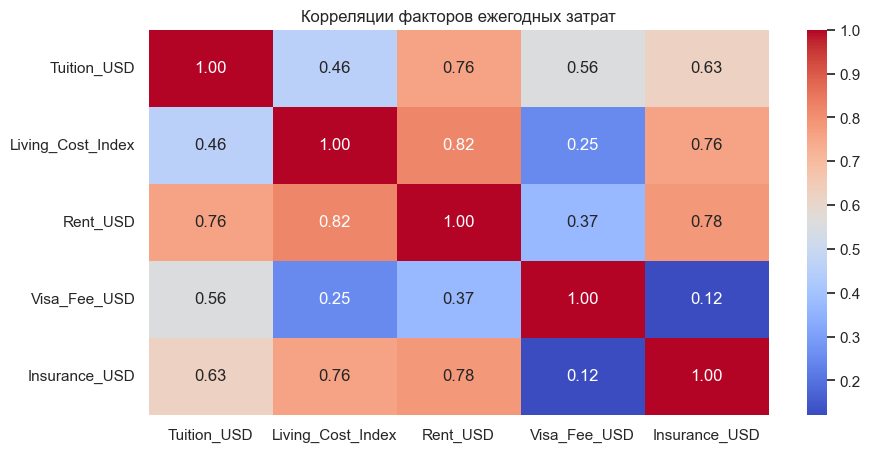

In [699]:
# Создаём матрицу корреляции интересующих нас признаков
corr_matrix = data[['Tuition_USD','Living_Cost_Index','Rent_USD','Visa_Fee_USD','Insurance_USD']].corr()

# Визуализируем получившуюся матрицу
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляции факторов ежегодных затрат')
plt.show()

**Выводы по графику**

1. `Аренда жилья (Rent_USD) — самый значимый фактор для общих расходов`:

    * Сильнее всего коррелирует с индексом стоимости жизни (0.82) и страховкой (0.78), что логично: в дорогих городах (Нью-Йорк, Лондон) высокие цены на жилье и услуги.

    * Влияет на стоимость обучения (0.76): вузы в таких локациях часто повышают цены из-за спроса и инфраструктурных затрат.

    * Практический вывод: выбор города с дешевой арендой (например, Берлин vs. Цюрих) значительно сократит бюджет.

2. `Стоимость обучения (Tuition_USD) зависит от аренды и страховки, но слабо — от визовых сборов`:

    * Корреляция с арендой (0.76) и страховкой (0.63) подтверждает, что страны с дорогим образованием (США, UK) обычно имеют высокие сопутствующие расходы.

    * Визовые сборы (Visa_Fee_USD) почти не связаны с другими факторами (корреляция <0.37). Например, виза в Австралию дорогая ($450), но страховка там дешевле, чем в США.

    * Исключение — страны с высокими ценами на обучение (Сингапур, Швейцария) могут компенсировать это низкими визовыми сборами.

3. `Страховка (Insurance_USD) — индикатор «премиальности» страны`:

    * Тесно связана с индексом жизни (0.76) и арендой (0.78), но почти не зависит от визовых сборов (0.12):

        * В США страховка ($1500) и аренда ($2000+) высокие, а виза ($160) — средняя.

        * В Германии страховка ($550) и аренда ($800) ниже, но виза ($75) почти не влияет на бюджет.

    * Слабую связь со стоимости обучения (0.63) можно объяснить тем, что некоторые страны (Канада, Франция) субсидируют медицину для студентов.

Итак, нам удалось получить максимально исчерпывающую информацию касательно как распределений признаков и их выборок, так об их взаимосвязи между собой.

Далее пользуясь методами статистических тестов мы выясним, какие признаки влияют на стоимость получения образования за рубежом.

## 3. Статистический анализ данных

Перед применением статистических тестов на необходимо задать уровень значимости $\alpha$ и создать функции принятия решений касательно наших гипотез:

In [700]:
# Задаём уровень значимости
alpha = 0.05 

# Функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# Функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

Теперь, когда всё настроено, мы можем приступать непосредственно к тестам

### Влияет ли регион мира на стоимость обучения?

In [701]:
# Задаём список стран
countries = ['USA', 'UK', 'Canada', 'Australia', 'Germany', 'Japan',
             'Netherlands', 'Singapore', 'France', 'Switzerland', 'China',
             'South Korea', 'Ireland', 'New Zealand', 'Austria', 'Belgium',
             'Hong Kong', 'Portugal', 'Israel', 'Taiwan', 'Czech Republic',
             'India', 'Poland', 'Malaysia', 'Spain', 'Italy', 'Turkey',
             'Russia', 'Mexico', 'Greece', 'Thailand', 'UAE', 'South Africa',
             'Egypt', 'Indonesia', 'Saudi Arabia', 'Nigeria', 'Vietnam',
             'Denmark', 'Hungary', 'Brazil', 'Colombia', 'Romania',
             'Luxembourg', 'Tunisia', 'Cyprus', 'Croatia', 'Dominican Republic',
             'Morocco', 'Peru', 'Ecuador', 'Lebanon', 'Bahrain', 'Bulgaria',
             'Ghana', 'Algeria', 'Panama', 'Uruguay', 'Bangladesh', 'Kuwait',
             'Ukraine', 'Slovenia', 'Serbia', 'Iran', 'Uzbekistan',
             'El Salvador']

# Определяем регионы и их страны
regions = {
    'North America': ['USA', 'Canada', 'Mexico'],
    'Europe': ['UK', 'Germany', 'Netherlands', 'France', 'Switzerland', 
              'Ireland', 'Austria', 'Belgium', 'Portugal', 'Czech Republic', 
              'Poland', 'Spain', 'Italy', 'Greece', 'Denmark', 'Hungary', 
              'Romania', 'Luxembourg', 'Croatia', 'Slovenia', 'Serbia', 
              'Bulgaria', 'Turkey', 'Ukraine', 'Russia', 'Cyprus'],
    'Asia': ['Japan', 'Singapore', 'China', 'South Korea', 'Hong Kong', 
            'Taiwan', 'India', 'Malaysia', 'Thailand', 'Indonesia', 
            'Saudi Arabia', 'UAE', 'Vietnam', 'Iran', 'Kuwait', 'Bahrain', 
            'Bangladesh', 'Uzbekistan', 'Israel', 'Lebanon'],
    'Oceania': ['Australia', 'New Zealand'],
    'South America': ['Brazil', 'Colombia', 'Peru', 'Ecuador', 'Uruguay'],
    'Africa': ['South Africa', 'Egypt', 'Nigeria', 'Morocco', 'Tunisia', 
              'Ghana', 'Algeria'],
    'Central America & Caribbean': ['Dominican Republic', 'Panama', 'El Salvador']
}

# Создаём словарь для быстрого поиска региона по стране
country_region = {}

# Заполняем словарь
for region, country_list in regions.items():
    for country in country_list:
        country_region[country] = region

# Теперь добавим столбец 'Region' в датасет
data['Region'] = data['Country'].map(country_region)

# Выводим результат
data['Region'].value_counts()

Region
Europe                         329
North America                  163
Asia                           151
Oceania                         95
Africa                          31
South America                   20
Central America & Caribbean     15
Name: count, dtype: int64

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: стоимость обучения не отличается для разных регионов: Europe ($μ_1$), North America ($μ_2$), Asia ($μ_3$), Oceania ($μ_4$), Africa ($μ_5$), South America ($μ_6$), Central America & Caribbean ($μ_7$).

<center>

$H_0: μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6 = μ_7$

</center>

*Альтернативная гипотеза*: стоимость обучения отличается для разных регионов: Europe ($μ_1$), North America ($μ_2$), Asia ($μ_3$), Oceania ($μ_4$), Africa ($μ_5$), South America ($μ_6$), Central America & Caribbean ($μ_7$).

<center>

$H_0: μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5 \neq μ_6 \neq μ_7$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально:

In [702]:
# Находим значения стоимости обучения для каждого региона
europe_tuition_cost = data.loc[data['Region'] == 'Europe', 'Tuition_USD']

north_america_tuition_cost = data.loc[data['Region'] == 'North America', 'Tuition_USD']

asia_tuition_cost = data.loc[data['Region'] == 'Asia', 'Tuition_USD']

oceania_tuition_cost = data.loc[data['Region'] == 'Oceania', 'Tuition_USD']

africa_tuition_cost = data.loc[data['Region'] == 'Africa', 'Tuition_USD']

south_america_tuition_cost = data.loc[data['Region'] == 'South America', 'Tuition_USD']

central_america_and_caribbean_tuition_cost = data.loc[data['Region'] == 'Central America & Caribbean', 'Tuition_USD']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для Europe:')
result = stats.shapiro(europe_tuition_cost)
decision_normality(result[1])
print('')

print('Для North_America:')
result = stats.shapiro(north_america_tuition_cost)
decision_normality(result[1])
print('')

print('Для Asia:')
result = stats.shapiro(asia_tuition_cost)
decision_normality(result[1])
print('')

print('Для Oceania:')
result = stats.shapiro(oceania_tuition_cost)
decision_normality(result[1])
print('')

print('Для Africa:')
result = stats.shapiro(africa_tuition_cost)
decision_normality(result[1])
print('')

print('Для South America:')
result = stats.shapiro(south_america_tuition_cost)
decision_normality(result[1])
print('')

print('Для Central America & Caribbean:')
result = stats.shapiro(central_america_and_caribbean_tuition_cost)
decision_normality(result[1])

Для Europe:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для North_America:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Asia:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Oceania:
p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Africa:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для South America:
p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Central America & Caribbean:
p-value = 0.532
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака `Tuition_USD`? — Количественный.

* Сколько сравниваемых групп? — 7.

* Группы зависимы? — Нет.

* Признак распределён по нормальному закону? — 1 группа из 7 (нет).

In [703]:
# Проводим тест
_, p = stats.kruskal(europe_tuition_cost,
                     north_america_tuition_cost,
                     asia_tuition_cost,
                     oceania_tuition_cost,
                     africa_tuition_cost,
                     south_america_tuition_cost,
                     central_america_and_caribbean_tuition_cost)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть статистически значимая разница в стоимости обучения для разного региона мира.

### Влияет ли направление на стоимость обучения?

In [704]:
# Задаём исходный список программ обучения
programs = [
    'Computer Science', 'Data Science', 'Business Analytics',
    'Engineering', 'Mechanical Engineering', 'Information Science',
    'Artificial Intelligence', 'Finance', 'International Relations',
    'Physics', 'Computer Engineering', 'Digital Media',
    'Data Analytics', 'Business', 'Marine Biology', 'Social Sciences',
    'Biomedical Sciences', 'Aerospace Engineering',
    'Industrial Engineering', 'Chemical Engineering', 'Mathematics',
    'Political Science', 'Architecture', 'Electronics Engineering',
    'Medicine', 'Electrical Engineering', 'Molecular Biology',
    'Pharmaceutical Sciences', 'Robotics', 'Quantum Computing',
    'Climate Science', 'Economics', 'Psychology', 'Design',
    'Software Engineering', 'Information Systems',
    'Information Technology', 'Software Development',
    'Computing Science', 'Data Engineering', 'Software Systems',
    'Digital Engineering', 'Robotics & AI', 'Cybersecurity',
    'Computing Systems', 'Applied Mathematics', 'Software Science',
    'Game Technology', 'Bioinformatics', 'Computer Science & Design',
    'Data Science & AI', 'Technology & Innovation',
    'Computing & Innovation', 'Digital Systems & AI',
    'Digital Systems', 'Business Informatics', 'Computational Science',
    'Digital Innovation', 'Robotics Engineering', 'AI Engineering',
    'Computer Systems', 'Information Security', 'Computer Networks',
    'Chemistry', 'Environmental Science', 'Biotechnology',
    'Machine Learning', 'Environmental Computing', 'Computing',
    'Mechatronics'
]

# Определяем направления и ключевые слова для классификации
direction_mapping = {
    'Computer Science & IT': [
        'Computer Science', 'Information Science', 'Software Engineering',
        'Information Systems', 'Information Technology', 'Software Development',
        'Computing Science', 'Software Systems', 'Computing', 'Computing Systems',
        'Software Science', 'Computer Science & Design', 'Computing & Innovation',
        'Digital Systems', 'Computer Systems', 'Information Security',
        'Computer Networks', 'Environmental Computing', 'Computing'
    ],
    'Data Science & AI': [
        'Data Science', 'Business Analytics', 'Artificial Intelligence',
        'Data Analytics', 'Machine Learning', 'Data Engineering',
        'Robotics & AI', 'Data Science & AI', 'AI Engineering',
        'Quantum Computing', 'Computational Science'
    ],
    'Engineering': [
        'Engineering', 'Mechanical Engineering', 'Computer Engineering',
        'Electronics Engineering', 'Electrical Engineering',
        'Aerospace Engineering', 'Industrial Engineering',
        'Chemical Engineering', 'Robotics Engineering',
        'Digital Engineering', 'Mechatronics', 'Robotics'
    ],
    'Business & Economics': [
        'Business', 'Finance', 'Economics', 'Business Informatics',
        'Technology & Innovation', 'Digital Innovation'
    ],
    'Natural Sciences': [
        'Physics', 'Chemistry', 'Environmental Science', 'Climate Science',
        'Mathematics', 'Applied Mathematics'
    ],
    'Biology & Medicine': [
        'Marine Biology', 'Biomedical Sciences', 'Molecular Biology',
        'Pharmaceutical Sciences', 'Medicine', 'Biotechnology',
        'Bioinformatics'
    ],
    'Social Sciences & Humanities': [
        'International Relations', 'Social Sciences', 'Political Science',
        'Psychology'
    ],
    'Design & Media': [
        'Digital Media', 'Design', 'Architecture', 'Game Technology'
    ]
}

# Создаём функцию для определения направления
def classify_program(program_name):
    program_lower = program_name.lower()
    for direction, keywords in direction_mapping.items():
        if any(kw.lower() in program_lower for kw in keywords):
            return direction
    return 'Other'

# Добавляем новый столбец
data['Program_Category'] = data['Program'].apply(classify_program)

# Выводим результат
data['Program_Category'].value_counts()

Program_Category
Computer Science & IT           451
Data Science & AI               202
Engineering                      94
Natural Sciences                 23
Business & Economics             11
Biology & Medicine               10
Design & Media                    5
Social Sciences & Humanities      4
Other                             4
Name: count, dtype: int64

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: стоимость обучения не отличается для разных направлений: Computer Science & IT ($μ_1$), Data Science & AI ($μ_2$), Engineering ($μ_3$), Business & Economics ($μ_4$), Biology & Medicine ($μ_5$), Design & Media ($μ_6$), Social Sciences & Humanities ($μ_7$), Other ($μ_8$).

<center>

$H_0: μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6 = μ_7 = μ_8$

</center>

*Альтернативная гипотеза*: стоимость обучения отличается для разных направлений: Computer Science & IT ($μ_1$), Data Science & AI ($μ_2$), Engineering ($μ_3$), Business & Economics ($μ_4$), Biology & Medicine ($μ_5$), Design & Media ($μ_6$), Social Sciences & Humanities ($μ_7$), Other ($μ_8$).

<center>

$H_0: μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5 \neq μ_6 \neq μ_7 \neq μ_8$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально:

In [705]:
# Находим значения стоимости обучения для каждого направления
computer_science_it = data.loc[data['Program_Category'] == 'Computer Science & IT', 'Tuition_USD']

data_science_ai = data.loc[data['Program_Category'] == 'Data Science & AI', 'Tuition_USD']

engineering = data.loc[data['Program_Category'] == 'Engineering', 'Tuition_USD']

business_economics = data.loc[data['Program_Category'] == 'Business & Economics', 'Tuition_USD']

biology_medicine = data.loc[data['Program_Category'] == 'Biology & Medicine', 'Tuition_USD']

design_media = data.loc[data['Program_Category'] == 'Design & Media', 'Tuition_USD']

social_sciences_humanities = data.loc[data['Program_Category'] == 'Social Sciences & Humanities', 'Tuition_USD']

other = data.loc[data['Program_Category'] == 'Other', 'Tuition_USD']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для Computer Science & IT:')
result = stats.shapiro(computer_science_it)
decision_normality(result[1])
print('')

print('Для Data Science & AI:')
result = stats.shapiro(data_science_ai)
decision_normality(result[1])
print('')

print('Для Engineering:')
result = stats.shapiro(engineering)
decision_normality(result[1])
print('')

print('Для Business & Economics:')
result = stats.shapiro(business_economics)
decision_normality(result[1])
print('')

print('Для Biology & Medicine:')
result = stats.shapiro(biology_medicine)
decision_normality(result[1])
print('')

print('Для Central Design & Media:')
result = stats.shapiro(design_media)
decision_normality(result[1])
print('')

print('Для Social Sciences & Humanities:')
result = stats.shapiro(social_sciences_humanities)
decision_normality(result[1])
print('')

print('Для Other:')
result = stats.shapiro(other)
decision_normality(result[1])

Для Computer Science & IT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Data Science & AI:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Engineering:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Business & Economics:
p-value = 0.140
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Biology & Medicine:
p-value = 0.330
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Central Design & Media:
p-value = 0.083
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Social Sciences & Humanities:
p-value = 0.122
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Other:
p-value = 0.007
p-значение меньше, чем заданн

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака `Tuition_USD`? — Количественный.

* Сколько сравниваемых групп? — 8.

* Группы зависимы? — Нет.

* Признак распределён по нормальному закону? — 4 группы из 8 (нет).

In [706]:
# Проводим тест
_, p = stats.kruskal(computer_science_it,
                     data_science_ai,
                     engineering,
                     business_economics,
                     biology_medicine,
                     design_media,
                     social_sciences_humanities,
                     other)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть статистически значимая разница в стоимости обучения для разных направлений.

### Влияет ли уровень образования на его стоимость?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: стоимость обучения не отличается для разного уровня образования: Bachelor ($μ_1$), Master ($μ_2$), PhD ($μ_3$).

<center>

$H_0: μ_1 = μ_2 = μ_3$

</center>

*Альтернативная гипотеза*: стоимость обучения отличается для разного уровня образования: Bachelor ($μ_1$), Master ($μ_2$), PhD ($μ_3$).

<center>

$H_0: μ_1 \neq μ_2 \neq μ_3$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально:

In [707]:
# Находим значения стоимости обучения для каждого направления
bachelor_tuition_cost = data.loc[data['Level'] == 'Bachelor', 'Tuition_USD']

master_tuition_cost = data.loc[data['Level'] == 'Master', 'Tuition_USD']

phd_tuition_cost = data.loc[data['Level'] == 'PhD', 'Tuition_USD']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для Bachelor:')
result = stats.shapiro(computer_science_it)
decision_normality(result[1])
print('')

print('Для Master:')
result = stats.shapiro(data_science_ai)
decision_normality(result[1])
print('')

print('Для PhD:')
result = stats.shapiro(engineering)
decision_normality(result[1])

Для Bachelor:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для Master:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для PhD:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака `Tuition_USD`? — Количественный.

* Сколько сравниваемых групп? — 3.

* Группы зависимы? — Нет.

* Признак распределён по нормальному закону? — Нет.

In [708]:
# Проводим тест
_, p = stats.kruskal(bachelor_tuition_cost,
                     master_tuition_cost,
                     phd_tuition_cost)
decision_hypothesis(p)

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть статистически значимая разница в стоимости обучения для разного уровня образования.

### Влияет ли длительность обучения на его стоимость?

In [709]:
# Определяем группировку
years_groups = {
    'Short': [1.0, 1.5],
    'Standard': [2.0, 2.5, 3.0],
    'Extended': [4.0, 5.0]
}

# Создаем функцию для определения группы
def map_years_to_group(years):
    for group_name, years_list in years_groups.items():
        if years in years_list:
            return group_name
        
# Добавляем новый признак в датасет
data['Years_Group'] = data['Duration_Years'].apply(map_years_to_group)

# Выводим результат
data['Years_Group'].value_counts()

Years_Group
Standard    518
Extended    269
Short        17
Name: count, dtype: int64

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: стоимость получения образования не отличается для разной длительности обучения: Short ($μ_1$), Standard Bachelor ($μ_2$), Extended ($μ_3$).

<center>

$H_0: μ_1 = μ_2 = μ_3$

</center>

*Альтернативная гипотеза*: стоимость получения образования отличается для разной длительности обучения: Short ($μ_1$), Standard Bachelor ($μ_2$), Extended ($μ_3$).

<center>

$H_0: μ_1 \neq μ_2 \neq μ_3$

**Проверка на нормальность**

С помощью теста Шапиро — Уилка проверим, распределён ли признак нормально:

In [710]:
# Находим значения стоимости обучения для каждого направления
short_tuition_cost = data.loc[data['Years_Group'] == 'Short', 'Tuition_USD']

standard_tuition_cost = data.loc[data['Years_Group'] == 'Standard', 'Tuition_USD']

extended_tuition_cost = data.loc[data['Years_Group'] == 'Extended', 'Tuition_USD']

# Проводим тест Шапиро — Уилка (тест на нормальность распределения признака)
print('Для 1-года:')
result = stats.shapiro(short_tuition_cost)
decision_normality(result[1])
print('')

print('Для 1.5-года:')
result = stats.shapiro(standard_tuition_cost)
decision_normality(result[1])
print('')

print('Для 2-лет:')
result = stats.shapiro(extended_tuition_cost)
decision_normality(result[1])

Для 1-года:
p-value = 0.013
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для 1.5-года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для 2-лет:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака `Tuition_USD`? — Количественный.

* Сколько сравниваемых групп? — 3.

* Группы зависимы? — Нет.

* Признак распределён по нормальному закону? — Нет.

In [711]:
# Проводим тест
_, p = stats.kruskal(short_tuition_cost,
                     standard_tuition_cost,
                     extended_tuition_cost)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть статистически значимая разница в стоимости получения образования для разной длительности обучения.

**Общий вывод по статистическим тестам**

Путём применения статистических тестов мы выяснили, что все наши категориальные столбцы без исключения влияют на стоимость получения образования, необходимо иметь это в виду при дальнейшей разработке ML-модели, к которой мы далее приступим.

# 2. Применение ML и DL

## 1. Выбор ведущей ML-модели

Так мы уже получили всю необходимую нам информацию из вспомогательных признаков, удалим их из датасета:

In [712]:
# Удаляем временные столбцы
data.drop(['Estimated_Annual_Cost', 'Region', 'Program_Category', 'Years_Group'], axis=1, inplace=True)

Теперь нам необходимо закодировать наши категориальные столбцы для их подачи моделям:

In [713]:
# Задаём список кодируемых признаков
encoder_col = ['Country', 'City', 'University', 'Program', 'Level']

# Создаем и обучаем OneHotEncoder на выбранных столбцах
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
data_encoded = encoder.fit_transform(data[encoder_col])

# Получаем имена новых признаков
new_feature_names = encoder.get_feature_names_out(encoder_col)

# Создаем DataFrame из преобразованных данных
encoded_df = pd.DataFrame(data_encoded, columns=new_feature_names, index=data.index)

# Удаляем исходные категориальные колонки
data = data.drop(columns=encoder_col)

# Объединяем исходный DataFrame с новым
data = pd.concat([data, encoded_df], axis=1)

Кодировка прошла успешно, определяем предикторы и целевую переменную, а так же разбиваем их на выборки:

In [714]:
# Определяем 'X' — предикторы и 'y' — целевую переменную 
X = data.drop(['Tuition_USD'], axis=1)
y = data['Tuition_USD']

# Разделяем выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Как мы помним из анализа данных наши числовые предикторы имеют выбросы и имеют ненормальное распределение, а учитывая то, что перед нами стоит задача регрессии и многие модели чувствительны к масштабам данных это является прямым сигналом о том, что выборки необходимо масштабировать:

In [715]:
# Объявляем масштабировщик
scaler = RobustScaler()

# Масштабируем предикторы
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Возводим в логарифмический масштаб целевую переменную
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

Кодирование и масштабирование закончено, сверимся с результатами:

In [716]:
# Рассчитаем показатели размерности в выборках
print(f'Размер тренировочной выборки: {X_train_scaled.shape}')
print(f'Размер тестовой выборки: {X_test_scaled.shape}')

Размер тренировочной выборки: (562, 1183)
Размер тестовой выборки: (242, 1183)


Далее, нам необходимо выбрать ведущую модель, с которой мы и будем работать в дальнейшем. Для этого зададим словарь из ML-моделей подходящих под нашу задачу:

In [717]:
# Создадим словарь из ML-моделей с параметрами по умолчанию
models = {
    "Ridge": Ridge(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "KNeighbors": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(verbosity=0)
}

Модели объявлены, но для того, чтобы оценить качество каждой из них мы проведём следующие шаги:

* Создадим пустой список для результатов;

* Пройдёмся циклом по каждой из модели в словаре, обучим их и сделаем предсказание на каждой выборке;

* Добавим полученные результаты в список 'results'.

In [718]:
# Создадим пустой список для результатов
results = []

# Проходимся по нашему словарю моделей
for name, model in models.items():
    # Обучаем и делаем предсказание
    model.fit(X_train_scaled, y_train_log)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Рассчитываем метрики оценки качества для тренировочной выборки
    train_r2 = r2_score(y_train_log, y_train_pred)
    train_mse = mean_squared_error(y_train_log, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train_log, y_train_pred)

    # Рассчитываем метрики оценки качества для тестовой выборки
    test_r2 = r2_score(y_test_log, y_test_pred)
    test_mse = mean_squared_error(y_test_log, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_log, y_test_pred)
    
    # Добавляем результаты метрик в список
    results.append({
        'Model': name,
        'Train R2 Score': round(train_r2, 4),
        'Test R2 Score': round(test_r2, 4),
        'Train MSE': round(train_mse, 4),
        'Test MSE': round(test_mse, 4),
        'Train RMSE': round(train_rmse, 4),
        'Test RMSE': round(test_rmse, 4),
        'Train MAE': round(train_mae, 4),
        'Test MAE': round(test_mae, 4)
    })

Для более наглядного сравнения результатов моделей упакуем их в Data Frame:

In [719]:
# Создаём и сортируем датасет из полученных результатов каждой из моделей
results_data = pd.DataFrame(results).sort_values(by='Test R2 Score', ascending=False)

# Проверяем полученный датасет
results_data

,Model,Train R2 Score,Test R2 Score,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE
2,RandomForest,0.9920,0.9684,0.0118,0.0539,0.1087,0.2322,0.0579,0.1448
1,DecisionTree,1.0000,0.9678,0.0000,0.0551,0.0048,0.2346,0.0003,0.1276
6,XGBoost,0.9975,0.9626,0.0038,0.0638,0.0613,0.2526,0.0476,0.1460
3,GradientBoosting,0.9673,0.9525,0.0485,0.0811,0.2203,0.2847,0.1815,0.2169
0,Ridge,0.9878,0.9347,0.0181,0.1115,0.1344,0.3340,0.0940,0.2292
5,KNeighbors,0.9267,0.8886,0.1087,0.1901,0.3297,0.4360,0.1875,0.2358
4,AdaBoost,0.8299,0.8437,0.2524,0.2669,0.5024,0.5166,0.4026,0.4167


Сравнив все метрики на тренировочной и тестовой выборках, можно выявить ключевые проблемы и лучшие модели:

| Модель          | Наличие переобучения | Подтверждающие метрики                     |
|----------------|----------------------|--------------------------------------------|
| RandomForest   | Нет                  | Разрыв R² 2.4% (0.9920 и 0.9684)          |
| DecisionTree   | Да                   | Train R² = 1.0, Test MSE = 0.0551              |
| XGBoost        | Умеренное            | Разрыв R² 3.5% (0.9975 и 0.9626)         |
| GradientBoosting| Минимальное          | Разрыв R² 1.5% (0.9673 и 0.9525)         |
| Ridge          | Да                  | Разрыв R² 5.3% (0.9878 и 0.9347)         |
| KNeighbors     | Возможное            | Test R² = 0.8886 (ниже других моделей)      |
| AdaBoost       | Нет                  | Разрыв R² минимален (0.8299 и 0.8437)    |

Таким образом мы можем сделать вывод о том, что наилучшим выбором, в качестве ведущей модели будет `RandomForest` по следующим причинам:

* `Надёжность` — она не требует сложной настройки гиперпараметров.

* `Готовность к production` — она хорошо работает «из коробки» (в отличие от `XGBoost`, который нужно оптимизировать).

* `Баланс` — она предлагает лучший компромисс между точностью (Test R²) и переобучением (разрыв 2.4% против 3.5% у `XGBoost`).

Учитывая всё вышеперечисленное, перейдём к оптимизации гиперпараметрам ведущей модели.

## 2. Оптимизация гиперпараметров модели

### GridSearchCV

Начнём с простого перебора по сетке заданных параметров:

In [720]:
# Задаём сетку гиперпараметров
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 15, 25, 35],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [0.8, 'sqrt', 'log2']
}

# Создаём модель
rf = RandomForestRegressor(random_state=42)

# Создаём объект поиска 'GridSearchCV'
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1)

# Обучаем модель
grid_search.fit(X_train_scaled, y_train_log)

# Выводим лучшие параметры
print('Лучшие параметры: ', grid_search.best_params_)

Лучшие параметры:  {'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Получив параметры, мы можем снова создать список результатов, обучить модель и добавить метрики в список оценки:

In [655]:
results = []

grid_fr_model = RandomForestRegressor(max_depth=None,
                                      max_features=0.8,
                                      min_samples_leaf=1,
                                      min_samples_split=2,
                                      n_estimators=200,
                                      random_state=42).fit(X_train_scaled, y_train_log)
y_train_pred = grid_fr_model.predict(X_train_scaled)
y_test_pred = grid_fr_model.predict(X_test_scaled)


train_r2 = r2_score(y_train_log, y_train_pred)
train_mse = mean_squared_error(y_train_log, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_log, y_train_pred)


test_r2 = r2_score(y_test_log, y_test_pred)
test_mse = mean_squared_error(y_test_log, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_log, y_test_pred)
    

results.append({
    'Model': 'Grid_RF_Model',
    'Train R2 Score': round(train_r2, 4),
    'Test R2 Score': round(test_r2, 4),
    'Train MSE': round(train_mse, 4),
    'Test MSE': round(test_mse, 4),
    'Train RMSE': round(train_rmse, 4),
    'Test RMSE': round(test_rmse, 4),
    'Train MAE': round(train_mae, 4),
    'Test MAE': round(test_mae, 4)
})

### RandomizedSearchCV

Далее воспользуемся рандомизированным поиск по заданным гиперпараметрам:

In [648]:
# Задаём параметры
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 15, 25, 35],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [0.8, 'sqrt', 'log2']
}

# Создаём объект поиска 'RandomizedSearchCV' 
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

# Обучаем модель
random_search.fit(X_train_scaled, y_train_log)

# Выводим лучшие параметры
print('Лучшие параметры: ', random_search.best_params_)

Лучшие параметры:  {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 35}


Параметры отличны от предыдущего метода, следовательно, проводим все ранее пройденные шаги и для RandomizedSearchCV:

In [656]:
random_fr_model = RandomForestRegressor(n_estimators=400,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        max_features=0.8,
                                        max_depth=35,
                                        random_state=42).fit(X_train_scaled, y_train_log)
y_train_pred = random_fr_model.predict(X_train_scaled)
y_test_pred = random_fr_model.predict(X_test_scaled)


train_r2 = r2_score(y_train_log, y_train_pred)
train_mse = mean_squared_error(y_train_log, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_log, y_train_pred)


test_r2 = r2_score(y_test_log, y_test_pred)
test_mse = mean_squared_error(y_test_log, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_log, y_test_pred)
    

results.append({
    'Model': 'Random_RF_Model',
    'Train R2 Score': round(train_r2, 4),
    'Test R2 Score': round(test_r2, 4),
    'Train MSE': round(train_mse, 4),
    'Test MSE': round(test_mse, 4),
    'Train RMSE': round(train_rmse, 4),
    'Test RMSE': round(test_rmse, 4),
    'Train MAE': round(train_mae, 4),
    'Test MAE': round(test_mae, 4)
})

### Bayesian Optimization

В завершение применим Байесовскую оптимизацию гиперпараметров.

Этот метод эффективно исследует пространство параметров, используя вероятностный подход для нахождения оптимальных комбинаций, что существенно сокращает количество требуемых итераций по сравнению с полным перебором:

In [652]:
# Задаем диапазоны гиперпараметров
search_spaces = {
    'n_estimators': (100, 400),
    'max_depth': (15, 35),
    'min_samples_split': (2, 15),
    'min_samples_leaf': (1, 4),
    'max_features': [0.8, 'sqrt', 'log2']
}

# Создаём модель
rf = RandomForestRegressor(random_state=42)

# Создаём объект класса 'BayesSearchCV'
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=search_spaces,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

# Обучаем модель
bayes_search.fit(X_train_scaled, y_train_log)

# Выводим лучшие параметры
print('Лучшие параметры: ', bayes_search.best_params_)

Лучшие параметры:  OrderedDict({'max_depth': 34, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 263})


Подобранные параметры различны, следовательно — обучаем модель, делаем предсказание и добавляем результаты в список:

In [657]:
bayes_fr_model = RandomForestRegressor(max_depth=34,
                                       max_features=0.8,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       n_estimators=263,
                                       random_state=42).fit(X_train_scaled, y_train)
y_train_pred = random_fr_model.predict(X_train_scaled)
y_test_pred = random_fr_model.predict(X_test_scaled)


train_r2 = r2_score(y_train_log, y_train_pred)
train_mse = mean_squared_error(y_train_log, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_log, y_train_pred)


test_r2 = r2_score(y_test_log, y_test_pred)
test_mse = mean_squared_error(y_test_log, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_log, y_test_pred)
    
results.append({
    'Model': 'Bayes_RF_Model',
    'Train R2 Score': round(train_r2, 4),
    'Test R2 Score': round(test_r2, 4),
    'Train MSE': round(train_mse, 4),
    'Test MSE': round(test_mse, 4),
    'Train RMSE': round(train_rmse, 4),
    'Test RMSE': round(test_rmse, 4),
    'Train MAE': round(train_mae, 4),
    'Test MAE': round(test_mae, 4)
})

Все модели, обучены и протестированы. Самое время сравнить полученные результаты и оценить качество подобранных гиперпараметров.

## 3. Сравнение методов и итоговый выбор модели

Как и в случае с базовыми моделями, мы обернём результаты в Data Frame:

In [658]:
# Создаём и сортируем датасет из полученных результатов каждой из моделей
results_data = pd.DataFrame(results).sort_values(by='Test R2 Score', ascending=False)

# Проверяем полученный датасет
results_data

,Model,Train R2 Score,Test R2 Score,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE
1,Random_RF_Model,0.9923,0.9682,0.0115,0.0542,0.1071,0.2329,0.0584,0.1460
2,Bayes_RF_Model,0.9923,0.9682,0.0115,0.0542,0.1071,0.2329,0.0584,0.1460
0,Grid_RF_Model,0.9921,0.9675,0.0117,0.0554,0.1082,0.2354,0.0587,0.1468


Как мы можем наблюдать, подбор параметров не дал весомого прироста в качестве предсказания, наоборот, она ухудшилась, хоть и незначительно (~0.1%), что статистически не даёт нам поводов для опасений в использовании Random_RF_Model.

Тем не менее, мы остановим свой выбор именно на нашей изначальной модели RandomForestRegressor в виду её лучшего качества предсказаний (хоть и незначительных) и её безопасности для production.